## EC Analysis -  A/B Class
- Data Preprocessing
- Focus on each product class
- Analyzing Rücksprung Kommentar - frequent words (unigram/bigram/trigram)
- Analyzing influencing factors of processing time of Bündels
- Change Impact Analysis: predicting affected components of new Bündel
- Predicting processing time of new Bündel

In [574]:
# import libraries

import pandas as pd
import numpy as np
import scipy
from scipy import spatial
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import utils as skl_utils
from tqdm import tqdm
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler  
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer


from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from skmultilearn.ensemble import MajorityVotingClassifier, LabelSpacePartitioningClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

import multiprocessing

import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns #visualisation
sns.set(color_codes=True)

## 1. Data Preprocessing - Load Data into Dataframes

In [575]:
# load EC releted entities
# EC_Entity, EC_Kategorie, Kategorie, Modulekomponente

home_dir_tables = "/home/yuwepan/Promotion/Data/cmm2.0/"
# load EC Entity
df_ec_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_ECEntity.parquet', engine='pyarrow')
df_ec_entity = df_ec_entity[['ID','EC_NUMMER','STATUS','STICHWORT','IST_ZUSTAND',
                            'SOLL_ZUSTAND','MODULKOMPONENTE','VERURSACHER','VERANTWORTLICHER_FK']]
df_ec_entity.columns = ['EC_ID','EC_NUMMER','EC_STATUS','EC_STICHWORT','EC_IST_ZUSTAND','EC_SOLL_ZUSTAND',
                        'EC_MK','EC_VERURSACHER','EC_VERANTWORTLICHER_FK']

# load EC kategorie 
df_ec_kategorie = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD107_KategorieZumECEntity.parquet', engine='pyarrow')
df_ec_kategorie = df_ec_kategorie[['EC_FK','KATEGORIE']]
df_ec_kategorie.columns = ['EC_FK','EC_KATEGORIE']

# load kategorie
df_kategorie = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_KAT.parquet', engine='pyarrow')
df_kategorie.columns = ['KATEGORIE','KAT_BENENNUNG']

# load mk
df_mk = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD101_MK.parquet', engine='pyarrow')
df_mk.columns = ['MK','MK_BENENNUNG']

# merge EC_entity with EC kategorie
df_ec = df_ec_entity.merge(df_ec_kategorie,left_on='EC_ID',right_on='EC_FK')
df_ec = df_ec.merge(df_kategorie,left_on='EC_KATEGORIE',right_on='KATEGORIE')

# merge EC with mk to get mk benennung
df_ec = df_ec.merge(df_mk,left_on='EC_MK',right_on='MK')

In [576]:
df_ec.head()

,EC_ID,EC_NUMMER,EC_STATUS,EC_STICHWORT,EC_IST_ZUSTAND,EC_SOLL_ZUSTAND,EC_MK,EC_VERURSACHER,EC_VERANTWORTLICHER_FK,EC_FK,EC_KATEGORIE,KATEGORIE,KAT_BENENNUNG,MK,MK_BENENNUNG
0,457874020,0000368,ABGESCHLOSSEN,Modul Sunvisor - Updation FuVo - Swivel Bracket,1. Modulsonnenblenden werden aufgrund von leic...,1. Nach mehreren Optimierungsschleifen seitens...,028,5,BAUERST,457874020,0,0,GuK-Fall - Verbesserung Qualitaet,028,Verkleidung Dach
1,1205519122006,0013599,ABGEBROCHEN,C238: Hutablage Leitungssatz,Mit dem Päv 0173682 wurde ursprünglich das Kab...,"Durch die Kabelsatzänderung um W213, kann das ...",028,14,VUNHOLZ,1205519122006,0,0,GuK-Fall - Verbesserung Qualitaet,028,Verkleidung Dach
2,1202819528026,0007711,ABGESCHLOSSEN,C257 Verwendung einer anderen Aufnahme Soundsy...,Der Himmel lässt sich im Bereich der 3D-Sound ...,Verwendung der Aufnahme A2136951000,028,22,LARPIEP,1202819528026,0,0,GuK-Fall - Verbesserung Qualitaet,028,Verkleidung Dach
3,1200006619014,0000433,ABGESCHLOSSEN,W 205: Abstützung ND vorne,Bei der Himmelvariante W205 ND-USA ist hinter ...,Neu Abstützung für die Variante USA erzeugen,028,4,JWOHLBOL,1200006619014,0,0,GuK-Fall - Verbesserung Qualitaet,028,Verkleidung Dach
4,1200010579009,0000455,ABGESCHLOSSEN,Erweiterung des Vergabeumfanges,die Verkleidung A-Säule wird ohne weitere Anba...,Anlieferung der Verkleidung A-Säule komplett m...,028,7,HARIBU,1200010579009,0,0,GuK-Fall - Verbesserung Qualitaet,028,Verkleidung Dach


In [577]:
# load buendel related entities
# Buendel Entity, Planeinsatztermin, Paket, BR_AA, BuendelZustand, 
df_buendel_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD151_BuendelEntity.parquet', engine='pyarrow')
df_buendel_entity = df_buendel_entity[['ID','CREATION_DATE','BUENDEL_NUMMER','STATUS','BENENNUNG',
                                       'GEWUENSCHTER_EINSATZ','KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
                                       'PROZESS_STATUS','EC_FK','VERANTWORTLICHER_FK','GREMIUM_ENTSCHEIDUNG_MANUELL',
                                       'STATUS_GENEHMIGUNG','RUECKSPRUNG_BEANTRAGT','RUECKSPRUNG_KOMMENTAR',
                                      'KOSTENBEWERTUNGS_ART','BEGR_RUECKSPRUNG','RUECKMELDE_DATUM',
                                      'MODULKOMPONENTE','BUENDEL_ZUSTAND_FK']]

df_buendel_entity.columns = ['Bnd_ID','Bnd_CREATION_DATE','BUENDEL_NUMMER','Bnd_STATUS','Bnd_BENENNUNG',
                                       'Bnd_GEWUENSCHTER_EINSATZ','Bnd_KOSTEN_RELEVANT', 'Bnd_ZERTIFIZIERUNGS_RELEVANT',
                                       'Bnd_PROZESS_STATUS','EC_FK','Bnd_VERANTWORTLICHER_FK','Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
                                       'Bnd_STATUS_GENEHMIGUNG','Bnd_RUECKSPRUNG_BEANTRAGT','Bnd_RUECKSPRUNG_KOMMENTAR',
                                       'Bnd_KOSTENBEWERTUNGS_ART','Bnd_BEGR_RUECKSPRUNG','Bnd_RUECKMELDE_DATUM',
                                       'Bnd_MODULKOMPONENTE','BUENDEL_ZUSTAND_FK']

# load buendel_zustand
df_buendel_zustand = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD167_BuendelZustandEntity.parquet', engine='pyarrow')
df_buendel_zustand = df_buendel_zustand[['ID','IST_ZUSTAND','SOLL_ZUSTAND']]

df_buendel_zustand.columns = ['BUENDEL_ZUSTAND_ID','Bnd_IST_ZUSTAND','Bnd_SOLL_ZUSTAND']

# load planeinsatztermin
df_pet_entity = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD181_PlaneinsatzTerminEntity.parquet', engine='pyarrow')
df_pet_entity = df_pet_entity[['ID','PAKET_FK','BUENDEL_FK']]

df_pet_entity.columns = ['PET_ID','PAKET_FK','BUENDEL_FK']

# load paket
df_paket = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRMDBM161_PaketEntity.parquet', engine='pyarrow')
df_paket = df_paket[['ID','BRAA_FK','BENENNUNG','STATUS']]

df_paket.columns = ['Paket_ID','BR_AA_FK','Paket_BENENNUNG','Paket_STATUS']

# load br aa
df_braa = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRMDBM152_AdminBRAAEntity.parquet', engine='pyarrow')
df_braa = df_braa[['ID','BR','AA','STATUS']]

df_braa.columns = ['BRAA_ID','BR','AA','BRAA_STATUS']

# merge
df_pet_paket = df_pet_entity.merge(df_paket, left_on='PAKET_FK',right_on='Paket_ID')
df_pet_paket_braa = df_pet_paket.merge(df_braa,left_on='BR_AA_FK',right_on='BRAA_ID')
new_df_bnd_entity = df_pet_paket_braa.merge(df_buendel_entity,left_on='BUENDEL_FK', right_on='Bnd_ID',
                                    how='left')
new_df_bnd_entity = new_df_bnd_entity.merge(df_buendel_zustand,left_on='BUENDEL_ZUSTAND_FK',right_on='BUENDEL_ZUSTAND_ID')
new_df_bnd_entity = new_df_bnd_entity.merge(df_ec, left_on='EC_FK', right_on='EC_ID')

new_df_bnd_entity = new_df_bnd_entity.merge(df_mk,left_on='Bnd_MODULKOMPONENTE',right_on='MK')

In [578]:
new_df_bnd_entity.columns

Index(['PET_ID', 'PAKET_FK', 'BUENDEL_FK', 'Paket_ID', 'BR_AA_FK',
       'Paket_BENENNUNG', 'Paket_STATUS', 'BRAA_ID', 'BR', 'AA', 'BRAA_STATUS',
       'Bnd_ID', 'Bnd_CREATION_DATE', 'BUENDEL_NUMMER', 'Bnd_STATUS',
       'Bnd_BENENNUNG', 'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODULKOMPONENTE',
       'BUENDEL_ZUSTAND_FK', 'BUENDEL_ZUSTAND_ID', 'Bnd_IST_ZUSTAND',
       'Bnd_SOLL_ZUSTAND', 'EC_ID', 'EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT',
       'EC_IST_ZUSTAND', 'EC_SOLL_ZUSTAND', 'EC_MK', 'EC_VERURSACHER',
       'EC_VERANTWORTLICHER_FK', 'EC_FK_y', 'EC_KATEGORIE', 'KATEGORIE',
       'KAT_BENENNUNG', 'MK_x', 'MK_BENENNUNG_x', 'MK_y', 'MK_BENENNUN

In [579]:
new_df_bnd_drop = new_df_bnd_entity [['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT',
       'EC_IST_ZUSTAND', 'EC_SOLL_ZUSTAND', 'EC_VERURSACHER',
       'EC_VERANTWORTLICHER_FK','EC_KATEGORIE',
       'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE', 'BUENDEL_NUMMER', 'Bnd_STATUS',
       'Bnd_BENENNUNG', 'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODULKOMPONENTE','MK_BENENNUNG_y',
       'Bnd_IST_ZUSTAND','Bnd_SOLL_ZUSTAND','BR','AA']].drop_duplicates(subset=None, keep='first')

In [580]:
new_df_bnd_drop.head(5)

,EC_NUMMER,EC_STATUS,EC_STICHWORT,EC_IST_ZUSTAND,EC_SOLL_ZUSTAND,EC_VERURSACHER,EC_VERANTWORTLICHER_FK,EC_KATEGORIE,KAT_BENENNUNG,Bnd_ID,...,Bnd_RUECKSPRUNG_KOMMENTAR,Bnd_KOSTENBEWERTUNGS_ART,Bnd_BEGR_RUECKSPRUNG,Bnd_RUECKMELDE_DATUM,Bnd_MODULKOMPONENTE,MK_BENENNUNG_y,Bnd_IST_ZUSTAND,Bnd_SOLL_ZUSTAND,BR,AA
0,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,None,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C247,FW
1,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,None,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C247,FX
2,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,None,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C177,FZ
3,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,None,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C177,FW
4,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,None,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C177,FV


In [581]:
new_df_bnd_drop['Bnd_KOSTEN_RELEVANT'] = new_df_bnd_drop['Bnd_KOSTEN_RELEVANT'].fillna('NaN')
new_df_bnd_drop['Bnd_ZERTIFIZIERUNGS_RELEVANT'] = new_df_bnd_drop['Bnd_ZERTIFIZIERUNGS_RELEVANT'].fillna('NaN')

new_df_bnd_drop['EC_STICHWORT'] = new_df_bnd_drop['EC_STICHWORT'].fillna('NaN')
new_df_bnd_drop['EC_IST_ZUSTAND'] = new_df_bnd_drop['EC_IST_ZUSTAND'].fillna('NaN')
new_df_bnd_drop['EC_SOLL_ZUSTAND'] = new_df_bnd_drop['EC_SOLL_ZUSTAND'].fillna('NaN')

new_df_bnd_drop['Bnd_BENENNUNG'] = new_df_bnd_drop['Bnd_BENENNUNG'].fillna('NaN')
new_df_bnd_drop['Bnd_RUECKSPRUNG_KOMMENTAR'] = new_df_bnd_drop['Bnd_RUECKSPRUNG_KOMMENTAR'].fillna('NaN')
new_df_bnd_drop['Bnd_IST_ZUSTAND'] = new_df_bnd_drop['Bnd_IST_ZUSTAND'].fillna('NaN')
new_df_bnd_drop['Bnd_SOLL_ZUSTAND'] = new_df_bnd_drop['Bnd_SOLL_ZUSTAND'].fillna('NaN')

In [582]:
new_df_bnd_drop.loc[new_df_bnd_drop['Bnd_IST_ZUSTAND'].str.contains('siehe EC')]['BUENDEL_NUMMER'].nunique()

30515

In [583]:
new_df_bnd_drop.loc[new_df_bnd_drop['EC_IST_ZUSTAND'].str.contains('siehe die Beschreibung des Bündels')]['BUENDEL_NUMMER'].nunique()

16

In [584]:
new_df_bnd_drop['BUENDEL_NUMMER'].nunique()

115910

In [585]:
# load produkt, convert BR to product class
df_produkt = pd.read_csv('/home/yuwepan/Promotion/Data/Produkt.csv',sep="|",header=0)

In [586]:
# convert unknown product class 
def convert_pk(p):
    tmp_p = ""
    if p == 'unbekannt C223 / FVV' :
        tmp_p = 'S- SL-Klasse'
    elif p == 'unbekannt C212 / BZ3':
        tmp_p = 'E-Klasse'
    else:
        tmp_p = p
    return tmp_p
        

In [587]:
df_produkt['new_ProduktKlasse'] = df_produkt['ProduktKlasse'].apply(lambda x: convert_pk(x))

In [588]:
df_produkt

,ProduktID,BR,AA,BRAA,ProduktArt,ProduktKlasse,new_ProduktKlasse
0,E80BD05F8BF7F9B9C7E305B1361E35D2,C450,FC,C450 / FC,Fahrzeug,Aftersales,Aftersales
1,4621BA9FBDB0C17BB0F5B610C8033789,D1329,M10,D1329 / M10,Aggregat,Aftersales,Aftersales
2,AC7B51A73AA0DE2D85F920A300189EEE,D2819,M09,D2819 / M09,Aggregat,Ottomotoren,Ottomotoren
3,690848CAB1CAA0C5879A7D61B6AF5B0C,D1609,M07,D1609 / M07,Aggregat,Ottomotoren,Ottomotoren
4,0B9C728CB1F0EC4C0D8369D9D1D9870B,D78900,BT2,D78900 / BT2,Aggregat,Batterie,Batterie
...,...,...,...,...,...,...,...
387,2E80BD49C5C959C3CDD6292E155E54C7,C906,FKA,C906 / FKA,Fahrzeug,Sprinter,Sprinter
388,75122E687DA209096AAA1B4EFA68705D,C907,FKA,C907 / FKA,Fahrzeug,Sprinter,Sprinter
389,880256D8562F2085FF7F09CAF3F3B6D2,C909,FKA,C909 / FKA,Fahrzeug,Sprinter Classic,Sprinter Classic
390,0AE62081022DB54B711A190E3D0D36ED,C910,FKA,C910 / FKA,Fahrzeug,Sprinter,Sprinter


In [589]:
df_produkt.loc[df_produkt['ProduktKlasse'].str.contains('C212')]

,ProduktID,BR,AA,BRAA,ProduktArt,ProduktKlasse,new_ProduktKlasse
299,B449156729304D57DFCAC166E3B378A6,C212,BZ3,C212 / BZ3,Fahrzeug,unbekannt C212 / BZ3,E-Klasse


In [590]:
df_produkt = df_produkt[['BR','new_ProduktKlasse']].drop_duplicates(subset=None, keep='first')
df_produkt

,BR,new_ProduktKlasse
0,C450,Aftersales
1,D1329,Aftersales
2,D2819,Ottomotoren
3,D1609,Ottomotoren
4,D78900,Batterie
...,...,...
378,C257,E-Klasse
379,C454,Aftersales
381,C470,Aftersales
385,C900,Sprinter


In [591]:
df_produkt.loc[df_produkt['BR']=='C177']

,BR,new_ProduktKlasse
145,C177,A- B-Klasse


In [592]:
# add column 'new_ProduktKlase' to merged buendel entity
new_df_bnd_drop_produkt = new_df_bnd_drop.merge(df_produkt,left_on='BR',right_on='BR')

In [593]:
new_df_bnd_drop_produkt['new_ProduktKlasse'].nunique()

31

In [594]:
new_df_bnd_drop_produkt.groupby(['BR'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

BR
C167      13759
C247      11925
C177      10886
C223      10223
C213       9240
          ...  
D6289         1
D71744        1
D78010        1
D71746        1
D72255        1
Name: BUENDEL_NUMMER, Length: 186, dtype: int64

In [595]:
new_df_bnd_drop_produkt.groupby(['new_ProduktKlasse'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

new_ProduktKlasse
S- SL-Klasse              24468
A- B-Klasse               21801
C-Klasse                  20542
M-Klasse R-Klasse         15866
E-Klasse                  15156
EVA                       12936
Aftersales                10056
Ottomotoren                6492
Sprinter                   6409
Vito                       4387
V-Klasse                   4381
Dieselmotoren              3809
Getriebe                   3623
Batterie                   2060
G-Klasse                    818
Smart                       680
Pickup                      604
unbekannt D78913 / BT2      275
Alternativ                  253
unbekannt D78924 / BT2      235
unbekannt D78906 / BT2      218
Citan                       165
Sprinter Classic            164
unbekannt L006 / XX         150
Regalteile                   85
unbekannt D6229 / M16        65
unbekannt D78060 / BE1       59
Maybach                      29
Viano                        26
unbekannt D6228 / M017       19
unbekannt D78050 / BE1

In [596]:
new_df_bnd_drop_produkt['BUENDEL_NUMMER'].nunique()

115910

In [597]:
new_df_bnd_drop_produkt.head(3)

,EC_NUMMER,EC_STATUS,EC_STICHWORT,EC_IST_ZUSTAND,EC_SOLL_ZUSTAND,EC_VERURSACHER,EC_VERANTWORTLICHER_FK,EC_KATEGORIE,KAT_BENENNUNG,Bnd_ID,...,Bnd_KOSTENBEWERTUNGS_ART,Bnd_BEGR_RUECKSPRUNG,Bnd_RUECKMELDE_DATUM,Bnd_MODULKOMPONENTE,MK_BENENNUNG_y,Bnd_IST_ZUSTAND,Bnd_SOLL_ZUSTAND,BR,AA,new_ProduktKlasse
0,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C247,FW,A- B-Klasse
1,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C247,FX,A- B-Klasse
2,0004604,ABGESCHLOSSEN,MG11 ZB Konsole hi in li/re VA mit Riffelbuchse,Aktuell hat die Tube (Aufnahme hi in VA) einen...,Der komplette Tubenfuss wird durch die Konsole...,12,HELLENH,0,GuK-Fall - Verbesserung Qualitaet,1201498068203,...,STANDARDPROZESS,None,2015-09-16,090,Vorbau,siehe EC,siehe EC,C247,FH,A- B-Klasse


In [598]:
def new_IST(df):
    if df['Bnd_IST_ZUSTAND'] == 'siehe EC':
        val = df['EC_IST_ZUSTAND']
    else:
        val = df['Bnd_IST_ZUSTAND']
    return val

def new_SOLL(df):
    if df['Bnd_SOLL_ZUSTAND'] == 'siehe EC':
        val = df['EC_SOLL_ZUSTAND']
    else:
        val = df['Bnd_SOLL_ZUSTAND']
    return val

## 2. Focus on Bündels in each product class
- A/B Class

In [599]:
#new_df_bnd_produkt_s = new_df_bnd_drop_produkt.loc[new_df_bnd_drop_produkt['new_ProduktKlasse'].str.contains('A- B-Klasse')]
#new_df_bnd_produkt_s = new_df_bnd_drop_produkt.loc[new_df_bnd_drop_produkt['new_ProduktKlasse'].str.contains('S- SL-Klasse')]
new_df_bnd_produkt_s = new_df_bnd_drop_produkt.loc[new_df_bnd_drop_produkt['new_ProduktKlasse'].str.contains('C-Klasse')]

new_df_bnd_produkt_s.head()

,EC_NUMMER,EC_STATUS,EC_STICHWORT,EC_IST_ZUSTAND,EC_SOLL_ZUSTAND,EC_VERURSACHER,EC_VERANTWORTLICHER_FK,EC_KATEGORIE,KAT_BENENNUNG,Bnd_ID,...,Bnd_KOSTENBEWERTUNGS_ART,Bnd_BEGR_RUECKSPRUNG,Bnd_RUECKMELDE_DATUM,Bnd_MODULKOMPONENTE,MK_BENENNUNG_y,Bnd_IST_ZUSTAND,Bnd_SOLL_ZUSTAND,BR,AA,new_ProduktKlasse
184586,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,STANDARDPROZESS,None,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FC,C-Klasse
184587,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,STANDARDPROZESS,None,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FX,C-Klasse
184588,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,STANDARDPROZESS,None,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FV,C-Klasse
184589,0012789,ABGESCHLOSSEN,BR213 Wagenheberaufnahme,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.,31,BTRZCIO,2,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,1204830546186,...,STANDARDPROZESS,None,2016-06-21,090,Vorbau,siehe EC,siehe EC,C253,FC,C-Klasse
184590,0012789,ABGESCHLOSSEN,BR213 Wagenheberaufnahme,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.,31,BTRZCIO,2,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,1204830546186,...,STANDARDPROZESS,None,2016-06-21,090,Vorbau,siehe EC,siehe EC,C253,FX,C-Klasse


In [600]:
new_df_bnd_produkt_s.nunique()

EC_NUMMER                           13866
EC_STATUS                               4
EC_STICHWORT                        13571
EC_IST_ZUSTAND                       8462
EC_SOLL_ZUSTAND                      8495
EC_VERURSACHER                         36
EC_VERANTWORTLICHER_FK               2143
EC_KATEGORIE                            6
KAT_BENENNUNG                           6
Bnd_ID                              20542
Bnd_CREATION_DATE                   20542
BUENDEL_NUMMER                      20542
Bnd_STATUS                              2
Bnd_BENENNUNG                       14664
Bnd_GEWUENSCHTER_EINSATZ               97
Bnd_KOSTEN_RELEVANT                     5
Bnd_ZERTIFIZIERUNGS_RELEVANT            4
Bnd_PROZESS_STATUS                      7
EC_FK_x                             13866
Bnd_VERANTWORTLICHER_FK              2161
Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL       93
Bnd_STATUS_GENEHMIGUNG                  2
Bnd_RUECKSPRUNG_BEANTRAGT               2
Bnd_RUECKSPRUNG_KOMMENTAR         

In [601]:
# for bundels which have no IST/SOLl Zustand, use the IST/SOLl Zustand from EC
new_df_bnd_produkt_s['new_IST'] = new_df_bnd_produkt_s.apply(new_IST, axis=1)
new_df_bnd_produkt_s['new_SOLL'] = new_df_bnd_produkt_s.apply(new_SOLL, axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [602]:
new_df_bnd_produkt_s.head()

,EC_NUMMER,EC_STATUS,EC_STICHWORT,EC_IST_ZUSTAND,EC_SOLL_ZUSTAND,EC_VERURSACHER,EC_VERANTWORTLICHER_FK,EC_KATEGORIE,KAT_BENENNUNG,Bnd_ID,...,Bnd_RUECKMELDE_DATUM,Bnd_MODULKOMPONENTE,MK_BENENNUNG_y,Bnd_IST_ZUSTAND,Bnd_SOLL_ZUSTAND,BR,AA,new_ProduktKlasse,new_IST,new_SOLL
184586,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FC,C-Klasse,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...
184587,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FX,C-Klasse,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...
184588,0010528,ABGESCHLOSSEN,Optimierung Konsole Federbein BR213,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...,12,VKRALIK,0,GuK-Fall - Verbesserung Qualitaet,1203907602099,...,2099-01-01,090,Vorbau,siehe EC,siehe EC,C253,FV,C-Klasse,Bauteil ohne optionale Verputzrippe für Repera...,Optionale Verputzrippe im Datensatz eingearbei...
184589,0012789,ABGESCHLOSSEN,BR213 Wagenheberaufnahme,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.,31,BTRZCIO,2,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,1204830546186,...,2016-06-21,090,Vorbau,siehe EC,siehe EC,C253,FC,C-Klasse,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.
184590,0012789,ABGESCHLOSSEN,BR213 Wagenheberaufnahme,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.,31,BTRZCIO,2,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,1204830546186,...,2016-06-21,090,Vorbau,siehe EC,siehe EC,C253,FX,C-Klasse,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.


In [603]:
new_df_bnd_produkt_s.columns

Index(['EC_NUMMER', 'EC_STATUS', 'EC_STICHWORT', 'EC_IST_ZUSTAND',
       'EC_SOLL_ZUSTAND', 'EC_VERURSACHER', 'EC_VERANTWORTLICHER_FK',
       'EC_KATEGORIE', 'KAT_BENENNUNG', 'Bnd_ID', 'Bnd_CREATION_DATE',
       'BUENDEL_NUMMER', 'Bnd_STATUS', 'Bnd_BENENNUNG',
       'Bnd_GEWUENSCHTER_EINSATZ', 'Bnd_KOSTEN_RELEVANT',
       'Bnd_ZERTIFIZIERUNGS_RELEVANT', 'Bnd_PROZESS_STATUS', 'EC_FK_x',
       'Bnd_VERANTWORTLICHER_FK', 'Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
       'Bnd_STATUS_GENEHMIGUNG', 'Bnd_RUECKSPRUNG_BEANTRAGT',
       'Bnd_RUECKSPRUNG_KOMMENTAR', 'Bnd_KOSTENBEWERTUNGS_ART',
       'Bnd_BEGR_RUECKSPRUNG', 'Bnd_RUECKMELDE_DATUM', 'Bnd_MODULKOMPONENTE',
       'MK_BENENNUNG_y', 'Bnd_IST_ZUSTAND', 'Bnd_SOLL_ZUSTAND', 'BR', 'AA',
       'new_ProduktKlasse', 'new_IST', 'new_SOLL'],
      dtype='object')

In [604]:
# choose relevant columns to build Bündel Dataframe
df_bnd_s = new_df_bnd_produkt_s[['Bnd_ID', 'BUENDEL_NUMMER','Bnd_CREATION_DATE','Bnd_RUECKMELDE_DATUM',
                                 'Bnd_STATUS','Bnd_BENENNUNG','EC_STICHWORT','EC_VERURSACHER', 'KAT_BENENNUNG','new_IST','new_SOLL',
                                 'Bnd_GEWUENSCHTER_EINSATZ','Bnd_KOSTEN_RELEVANT','Bnd_ZERTIFIZIERUNGS_RELEVANT',
                                 'Bnd_PROZESS_STATUS','Bnd_VERANTWORTLICHER_FK','Bnd_GREMIUM_ENTSCHEIDUNG_MANUELL',
                                 'Bnd_STATUS_GENEHMIGUNG','Bnd_RUECKSPRUNG_KOMMENTAR','Bnd_KOSTENBEWERTUNGS_ART',
                                 'Bnd_BEGR_RUECKSPRUNG','Bnd_MODULKOMPONENTE','MK_BENENNUNG_y','new_ProduktKlasse']].drop_duplicates(subset=None, keep='first')

In [605]:
df_bnd_s.columns = ['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
                    'STATUS', 'BENENNUNG', 'STICHWORT','VERURSACHER','KAT', 'new_IST','new_SOLL', 'GEWUENSCHTER_EINSATZ',
                    'KOSTEN_RELEVANT','ZERTIFIZIERUNGS_RELEVANT','PROZESS_STATUS',
                    'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
                    'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG', 
                    'MK', 'MK_BENENNUNG', 'ProduktKlasse']

In [606]:
df_bnd_s.head()

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT,new_IST,...,PROZESS_STATUS,VERANTWORTLICHER_FK,GREMIUM_ENTSCHEIDUNG_MANUELL,STATUS_GENEHMIGUNG,RUECKSPRUNG_KOMMENTAR,KOSTENBEWERTUNGS_ART,BEGR_RUECKSPRUNG,MK,MK_BENENNUNG,ProduktKlasse
184586,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,NACH_NCM_VERSORGT,VKRALIK,None,None,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184589,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,ABGESCHLOSSEN,BTRZCIO,AK-BR213,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184592,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,ABGESCHLOSSEN,CVANRIE,None,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184593,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,ABGESCHLOSSEN,BTRZCIO,None,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184596,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,ABGESCHLOSSEN,BTRZCIO,None,BESCHLOSSEN,Änderung Einsatztermine zur Behebung der Proma...,STANDARDPROZESS,None,090,Vorbau,C-Klasse


In [607]:
df_bnd_s['ZERTIFIZIERUNGS_RELEVANT'].unique()

array(['NEIN', 'JA', 'NaN', 'EMPTY'], dtype=object)

In [608]:
df_bnd_s.groupby(['KOSTENBEWERTUNGS_ART'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

KOSTENBEWERTUNGS_ART
STANDARDPROZESS          17025
SCHNELLLAEUFERPROZESS     2960
LEAN                       557
Name: BUENDEL_NUMMER, dtype: int64

### Remove test ECs

In [609]:
# test ECs
indexNames_testecs = df_bnd_s.loc[(df_bnd_s['BENENNUNG'].isin(['test','Test'])) 
                   | (df_bnd_s['STICHWORT'].isin(['test','Test'])) 
                   | (df_bnd_s['new_IST'].isin(['test','Test','Siehe Anhang','siehe jeweiliges Bündel']))
                   | (df_bnd_s['new_SOLL'].isin(['test','Test','Siehe Anhang','siehe jeweiliges Bündel']))].index.tolist()
indexNames_testecs

[187933,
 217800,
 217979,
 223106,
 258645,
 262879,
 264544,
 272166,
 284874,
 284876,
 383787,
 384140,
 384141,
 384346]

In [610]:
df_bnd_s.drop(indexNames_testecs,inplace=True)

In [611]:
df_bnd_s.head()

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT,new_IST,...,PROZESS_STATUS,VERANTWORTLICHER_FK,GREMIUM_ENTSCHEIDUNG_MANUELL,STATUS_GENEHMIGUNG,RUECKSPRUNG_KOMMENTAR,KOSTENBEWERTUNGS_ART,BEGR_RUECKSPRUNG,MK,MK_BENENNUNG,ProduktKlasse
184586,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,NACH_NCM_VERSORGT,VKRALIK,None,None,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184589,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,ABGESCHLOSSEN,BTRZCIO,AK-BR213,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184592,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,ABGESCHLOSSEN,CVANRIE,None,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184593,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,ABGESCHLOSSEN,BTRZCIO,None,BESCHLOSSEN,NaN,STANDARDPROZESS,None,090,Vorbau,C-Klasse
184596,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,ABGESCHLOSSEN,BTRZCIO,None,BESCHLOSSEN,Änderung Einsatztermine zur Behebung der Proma...,STANDARDPROZESS,None,090,Vorbau,C-Klasse


In [612]:
# Count word length in each description
df_bnd_s['word_count_benennung'] = df_bnd_s['BENENNUNG'].apply(lambda x: len(str(x).split(" ")))
df_bnd_s['word_count_stichwort'] = df_bnd_s['STICHWORT'].apply(lambda x: len(str(x).split(" ")))
df_bnd_s['word_count_rueck'] = df_bnd_s['RUECKSPRUNG_KOMMENTAR'].apply(lambda x: len(str(x).split(" ")))
df_bnd_s['word_count_berg_rueck'] = df_bnd_s['BEGR_RUECKSPRUNG'].apply(lambda x: len(str(x).split(" ")))
df_bnd_s['word_count_ist'] = df_bnd_s['new_IST'].apply(lambda x: len(str(x).split(" ")))
df_bnd_s['word_count_soll'] = df_bnd_s['new_SOLL'].apply(lambda x: len(str(x).split(" ")))

In [613]:
df_bnd_s

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT,new_IST,...,BEGR_RUECKSPRUNG,MK,MK_BENENNUNG,ProduktKlasse,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll
184586,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,None,090,Vorbau,C-Klasse,1,4,1,1,8,5
184589,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,None,090,Vorbau,C-Klasse,1,2,1,1,17,4
184592,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,None,090,Vorbau,C-Klasse,4,5,1,1,1,21
184593,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,None,090,Vorbau,C-Klasse,1,3,1,1,19,19
184596,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,None,090,Vorbau,C-Klasse,1,4,10,1,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413636,1202589858412,0007606-001,2016-01-28 11:08:21.205,2099-01-01,FERTIG,RD/KIT_PT,CCC_BR203_ET,27,Gesetzliche Massnahme,CCC-Zertifizierung <E> CCC certification\r\nSo...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,14,14
413639,1204869723254,0013004-001,2016-05-30 13:39:34.491,2016-07-27,FERTIG,RD/KIT_PT,CCC_BR203_ET,27,Gesetzliche Massnahme,CCC-Zertifizierung <E> CCC certification\r\n\n...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,14,14
413754,1202051581379,0006005-001,2015-11-04 12:27:35.373,2015-12-23,FERTIG,RD/KIA,CCC_BR209_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,None,099,MB Accessories,C-Klasse,1,1,1,1,5,5
413756,1204869723068,0012705-001,2016-05-19 12:56:56.020,2017-09-08,FERTIG,RD/KIA_nZertRel,CCC_BR209_ET,27,Gesetzliche Massnahme,Korrektur zu Bündel 0006005-001 <E> correction...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,9,8


In [614]:
df_bnd_s.groupby(['word_count_ist'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=True).head(10)

word_count_ist
896    1
157    1
152    1
144    1
143    1
140    1
348    1
133    1
132    1
131    1
Name: BUENDEL_NUMMER, dtype: int64

In [615]:
df_bnd_s['word_count_stichwort'].describe()

count    21944.000000
mean         4.654849
std          1.993333
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         16.000000
Name: word_count_stichwort, dtype: float64

In [616]:
df_buendel_kat_s=df_bnd_s[['BUENDEL_NUMMER','KAT']].drop_duplicates()
df_buendel_kat_s['KAT'] = df_bnd_s['KAT'].astype('str')
concat_df_buendel_kat_s = df_bnd_s.groupby(['BUENDEL_NUMMER'])['KAT'].apply(','.join).reset_index()

# sort strings in column EC_KATEGORIE of df_x
for i, row in concat_df_buendel_kat_s.iterrows():
    tmp_cat = list(row['KAT'].split(sep=','))
    tmp_cat.sort()
    cat = ','.join([str(elem) for elem in tmp_cat]) 
    #temp_art = ' '.join(set(row['ProduktArt'].split(sep=',')))
    concat_df_buendel_kat_s.at[i,'KAT'] = cat

concat_df_buendel_kat_s

,BUENDEL_NUMMER,KAT
0,0000004-002,"Funktionsvorschrift,Gesetzliche Massnahme"
1,0000004-003,"Funktionsvorschrift,Gesetzliche Massnahme"
2,0000004-004,"Funktionsvorschrift,Gesetzliche Massnahme"
3,0000004-005,"Funktionsvorschrift,Gesetzliche Massnahme"
4,0000004-007,"Funktionsvorschrift,Gesetzliche Massnahme"
...,...,...
20523,0082564-001,GuK-Fall - Verbesserung Qualitaet
20524,0082564-002,GuK-Fall - Verbesserung Qualitaet
20525,0082572-001,GuK-Fall - Verbesserung Qualitaet
20526,0082578-001,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...


In [617]:
df_bnd_s = df_bnd_s.merge(concat_df_buendel_kat_s, left_on='BUENDEL_NUMMER', right_on='BUENDEL_NUMMER')
df_bnd_s.head()

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT_x,new_IST,...,MK,MK_BENENNUNG,ProduktKlasse,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll,KAT_y
0,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,090,Vorbau,C-Klasse,1,4,1,1,8,5,GuK-Fall - Verbesserung Qualitaet
1,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,090,Vorbau,C-Klasse,1,2,1,1,17,4,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
2,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,090,Vorbau,C-Klasse,4,5,1,1,1,21,Gesetzliche Massnahme
3,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,090,Vorbau,C-Klasse,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
4,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,090,Vorbau,C-Klasse,1,4,10,1,11,19,GuK-Fall - Verbesserung Qualitaet


In [618]:
#df_bnd_s = df_bnd_s.drop(columns=['KAT_x'])
df_bnd_s.rename(columns={'KAT_x':'KAT'})
df_bnd_s.drop(columns=['KAT_y'])

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT_x,new_IST,...,BEGR_RUECKSPRUNG,MK,MK_BENENNUNG,ProduktKlasse,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll
0,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,None,090,Vorbau,C-Klasse,1,4,1,1,8,5
1,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,None,090,Vorbau,C-Klasse,1,2,1,1,17,4
2,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,None,090,Vorbau,C-Klasse,4,5,1,1,1,21
3,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,None,090,Vorbau,C-Klasse,1,3,1,1,19,19
4,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,None,090,Vorbau,C-Klasse,1,4,10,1,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21939,1202589858412,0007606-001,2016-01-28 11:08:21.205,2099-01-01,FERTIG,RD/KIT_PT,CCC_BR203_ET,27,Gesetzliche Massnahme,CCC-Zertifizierung <E> CCC certification\r\nSo...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,14,14
21940,1204869723254,0013004-001,2016-05-30 13:39:34.491,2016-07-27,FERTIG,RD/KIT_PT,CCC_BR203_ET,27,Gesetzliche Massnahme,CCC-Zertifizierung <E> CCC certification\r\n\n...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,14,14
21941,1202051581379,0006005-001,2015-11-04 12:27:35.373,2015-12-23,FERTIG,RD/KIA,CCC_BR209_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,None,099,MB Accessories,C-Klasse,1,1,1,1,5,5
21942,1204869723068,0012705-001,2016-05-19 12:56:56.020,2017-09-08,FERTIG,RD/KIA_nZertRel,CCC_BR209_ET,27,Gesetzliche Massnahme,Korrektur zu Bündel 0006005-001 <E> correction...,...,None,099,MB Accessories,C-Klasse,1,1,1,1,9,8


In [619]:
df_bnd_s = df_bnd_s.drop_duplicates(subset=None, keep='first')
df_bnd_s.head()

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT_x,new_IST,...,MK,MK_BENENNUNG,ProduktKlasse,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll,KAT_y
0,1203907602099,0010528-001,2016-04-07 08:31:41.799,2099-01-01,FERTIG,Standardbündel,Optimierung Konsole Federbein BR213,12,GuK-Fall - Verbesserung Qualitaet,Bauteil ohne optionale Verputzrippe für Repera...,...,090,Vorbau,C-Klasse,1,4,1,1,8,5,GuK-Fall - Verbesserung Qualitaet
1,1204830546186,0012789-001,2016-05-23 09:40:44.443,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,090,Vorbau,C-Klasse,1,2,1,1,17,4,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
2,1223690159553,0031522-013,2018-01-17 11:44:25.447,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,090,Vorbau,C-Klasse,4,5,1,1,1,21,Gesetzliche Massnahme
3,1205519126084,0013708-001,2016-06-14 13:27:40.043,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,090,Vorbau,C-Klasse,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
4,1202819084461,0008365-001,2016-02-18 09:37:52.117,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,090,Vorbau,C-Klasse,1,4,10,1,11,19,GuK-Fall - Verbesserung Qualitaet


## 3. Analyzing Rücksprung Kommentar - frequent words (unigram/bigram/trigram)

In [620]:
df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('NaN')==False]['BUENDEL_NUMMER'].nunique()

4625

### Preprocessing 

In [621]:
list_ruck_str = []
list_ruck_str = df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('NaN')==False]['RUECKSPRUNG_KOMMENTAR'].values.tolist()
list_ruck_str

['Änderung Einsatztermine zur Behebung der Promas-Bewertungsprobleme (NPP/Serien Steuerung)  ',
 'Kostenbewertung neu beauftragen',
 'Sachnummer wurde ergänzt.',
 'Die Abdeckplatte A2536209600 wird durch KTL Beschichtung ersetzt im neuen ZB Querträger von der Fa. Valeo .',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'MG eingetragen',
 'Schweißschrauben Menge 1 auf 2 setzen ',
 'Terminanpassung durch ACM-Support. s. Mail Hr. Schrade vom 08.06.18',
 'Terminanpassung durch ACM-Support. s. Mail Hr. Schrade vom 08.06.18',
 'Terminanpassung durch ACM-Support. s. Mail Hr. Schrade vom 08.06.18',
 'Kostenbewertung neu beauftragen',
 'Kostenbewertung neu beauftragen',
 'Werke und BZA korrigert',
 'A253 610 92 01_ZGS 002_ZB Hauptboden VST CHN zugefügt',
 'Kostenbewertung neu beauftragen',
 'process updating',
 'Kostenbewertung neu beauftragen',
 'Änderung Einsatztermine 205 und 253 zur Behebung der Promas-Bewertungsprobleme (NPP/Ser

In [622]:
df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('Kostenbewertung neu beauftragen')]['BUENDEL_NUMMER']

7        0031103-001
28       0046221-004
34       0066987-001
50       0031067-001
68       0057926-001
            ...     
21457    0076479-004
21469    0078112-001
21470    0079292-001
21581    0022680-001
21923    0072026-001
Name: BUENDEL_NUMMER, Length: 1728, dtype: object

In [623]:
len(list_ruck_str)

5030

In [624]:
from nltk.stem.snowball import GermanStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stemmer = SnowballStemmer('german')

stops = set(stopwords.words('german'))
stops.update(set(stopwords.words('english')))

stops.update(['bündel','wurde','wurden','aufgrund','hinzu','bitte','wegen','siehe','rücksprung','bereits'])
  

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    
    for idx in range(len(docs)):
        if docs[idx]:
            #docs[idx] = str(docs[idx])
            #docs[idx] = docs[idx].split('<E>', 1)[0] # Delete English tranlation, first focus on German text
        
            docs[idx] = docs[idx].lower()  # Convert to lowercase.
            docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc or [] if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc or [] if len(token) > 2] for doc in docs]
    
    #lemmatizer = WordNetLemmatizer()
    #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    # Remove stopwords
    docs = [[token for token in doc or [] if not token in stops] for doc in docs]
    
    stemmer = GermanStemmer()
    docs = [[stemmer.stem(token) for token in doc] for doc in docs]
    
    # Lemmatize all words in documents.
    # For German, import snowball
    #lemmatizer = WordNetLemmatizer()
    #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    #stemmer = GermanStemmer()
    #docs = [[stemmer.stem(token) for token in doc] for doc in docs]
    return docs

In [625]:
docs = []
docs = docs_preprocessor(list_ruck_str)
docs

[['ander',
  'einsatztermin',
  'beheb',
  'promas',
  'bewertungsproblem',
  'npp',
  'seri',
  'steuer'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['sachnumm', 'erganzt'],
 ['abdeckplatt',
  'a2536209600',
  'ktl',
  'beschicht',
  'ersetzt',
  'neu',
  'quertrag',
  'valeo'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['eingetrag'],
 ['schweissschraub', 'meng', 'setz'],
 ['terminanpass', 'acm', 'support', 'mail', 'schrad'],
 ['terminanpass', 'acm', 'support', 'mail', 'schrad'],
 ['terminanpass', 'acm', 'support', 'mail', 'schrad'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['werk', 'bza', 'korrigert'],
 ['a253', '01_zgs', '002_zb', 'hauptbod', 'vst', 'chn', 'zugefugt'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['process', 'updating'],
 ['kostenbewert', 'neu', 'beauftrag'],
 ['ander',
  'einsatztermin',
  'beheb',
  'promas',
  'bewertungsproblem',
  'npp',
  'seri',
  'steue

### Most frequent words in Rucksprung Kommentar

In [626]:
from nltk.probability import FreqDist
# fdist = FreqDist()

# for idx in range(len(list_str)):
#     if list_str[idx]:
#         words= nltk.word_tokenize(list_str[idx])
#         for word in words:
#             fdist[word] += 1

fdist = FreqDist()
for idx in range(len(docs)):
    if docs[idx]:
        #for word in range(len(docs[idx])):
        for word in docs[idx]:
            fdist[word] += 1

In [627]:
fdist.N()

24158

In [628]:
fdist.most_common(50)

[('neu', 1925),
 ('kostenbewert', 1742),
 ('beauftrag', 1741),
 ('einsatztermin', 278),
 ('sachnumm', 277),
 ('ander', 252),
 ('snr', 206),
 ('hinzugefugt', 194),
 ('angepasst', 191),
 ('promas', 181),
 ('geandert', 164),
 ('erganzt', 153),
 ('entfernt', 139),
 ('gkr', 134),
 ('part', 131),
 ('acm', 128),
 ('anlag', 119),
 ('support', 109),
 ('prozess', 97),
 ('kost', 97),
 ('korrigiert', 96),
 ('cod', 95),
 ('lieferant', 88),
 ('weidlich', 86),
 ('uberarbeitet', 85),
 ('added', 83),
 ('cost', 83),
 ('gesetzt', 82),
 ('chang', 77),
 ('beschreib', 74),
 ('syntaxpruf', 73),
 ('slp', 70),
 ('teil', 67),
 ('verteil', 67),
 ('bewert', 66),
 ('eingetrag', 65),
 ('updated', 65),
 ('numb', 63),
 ('anpass', 62),
 ('erfolgt', 62),
 ('termin', 60),
 ('einkauf', 59),
 ('entfern', 58),
 ('bbac', 58),
 ('sondervereinbar', 58),
 ('seri', 57),
 ('suppli', 52),
 ('anhang', 50),
 ('bundl', 50),
 ('kostenneutral', 49)]

### Creating a vector of word counts 

In [629]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer(max_df=0.8, stop_words=stops, max_features=10000, ngram_range=(1,3))

In [630]:
import string
str_docs = []
for i in range(len(docs)):
    str_docs.append([])   # appending a new list!

for idx in range(len(docs)):
    str_docs[idx] = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in docs[idx]]).strip()

str_docs[1]

'kostenbewert neu beauftrag'

In [631]:
X = cv.fit_transform(str_docs)

In [632]:
list(cv.vocabulary_.keys())[:10]

['einsatztermin',
 'beheb',
 'promas',
 'bewertungsproblem',
 'npp',
 'seri',
 'steuer',
 'einsatztermin beheb',
 'beheb promas',
 'promas bewertungsproblem']

In [633]:
#Most frequently occuring words
def get_top_n_words(docs, n=None):
    vec = CountVectorizer().fit(docs)
    bag_of_words = vec.transform(docs)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

[Text(0, 0, 'neu'),
 Text(0, 0, 'kostenbewert'),
 Text(0, 0, 'beauftrag'),
 Text(0, 0, 'einsatztermin'),
 Text(0, 0, 'sachnumm'),
 Text(0, 0, 'ander'),
 Text(0, 0, 'snr'),
 Text(0, 0, 'hinzugefugt'),
 Text(0, 0, 'angepasst'),
 Text(0, 0, 'promas'),
 Text(0, 0, 'geandert'),
 Text(0, 0, 'erganzt'),
 Text(0, 0, 'entfernt'),
 Text(0, 0, 'gkr'),
 Text(0, 0, 'part'),
 Text(0, 0, 'acm'),
 Text(0, 0, 'anlag'),
 Text(0, 0, 'support'),
 Text(0, 0, 'prozess'),
 Text(0, 0, 'kost'),
 Text(0, 0, 'korrigiert'),
 Text(0, 0, 'cod'),
 Text(0, 0, 'lieferant'),
 Text(0, 0, 'weidlich'),
 Text(0, 0, 'uberarbeitet'),
 Text(0, 0, 'added'),
 Text(0, 0, 'cost'),
 Text(0, 0, 'gesetzt'),
 Text(0, 0, 'chang'),
 Text(0, 0, 'beschreib')]

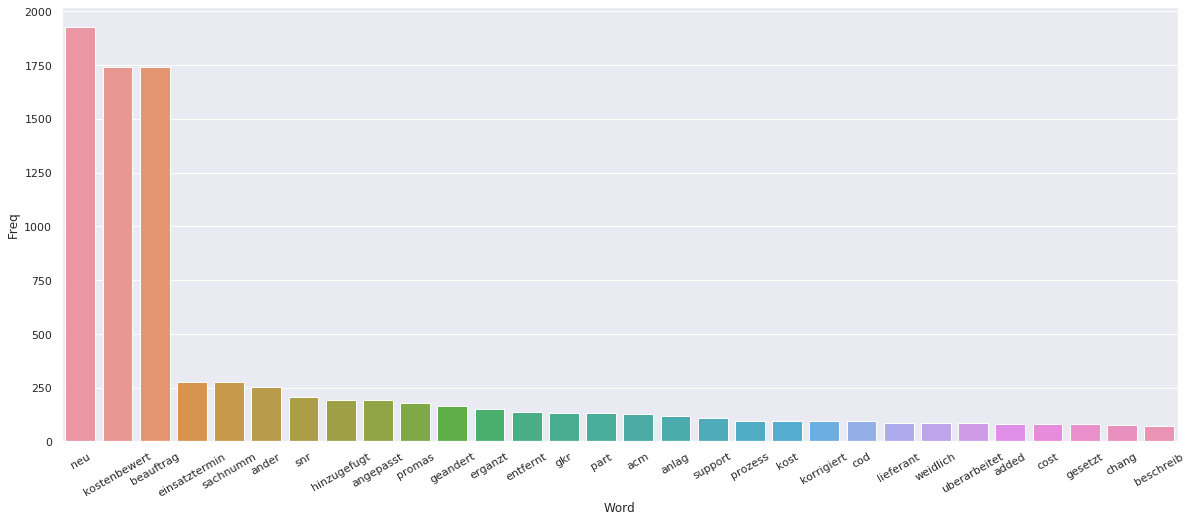

In [634]:
#Convert most freq words to datagrame for plotting bar plot
top_words = get_top_n_words(str_docs, n=30)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word","Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                     Bi-gram  Freq
0           kostenbewert neu  1734
1              neu beauftrag  1733
2                acm support   101
3             support promas    70
4          promas syntaxpruf    66
5        ander einsatztermin    58
6                  part numb    52
7                gkr prozess    40
8    sondervereinbar entfern    37
9               beheb promas    32
10  promas bewertungsproblem    32
11     bewertungsproblem npp    32
12                  npp seri    32
13               seri steuer    32
14       einsatztermin beheb    31
15   einsatztermin angepasst    29
16              flex prozess    25
17              neu sachnumm    25
18        implementation dat    24
19      sachnumm hinzugefugt    22
20      einsatztermin promas    22
21         anlag hinzugefugt    20
22                   neu snr    19
23                 zgs erhoh    18
24         englisch ubersetz    16
25                  new part    14
26               snr erganzt    14
27                  

[Text(0, 0, 'kostenbewert neu'),
 Text(0, 0, 'neu beauftrag'),
 Text(0, 0, 'acm support'),
 Text(0, 0, 'support promas'),
 Text(0, 0, 'promas syntaxpruf'),
 Text(0, 0, 'ander einsatztermin'),
 Text(0, 0, 'part numb'),
 Text(0, 0, 'gkr prozess'),
 Text(0, 0, 'sondervereinbar entfern'),
 Text(0, 0, 'beheb promas'),
 Text(0, 0, 'promas bewertungsproblem'),
 Text(0, 0, 'bewertungsproblem npp'),
 Text(0, 0, 'npp seri'),
 Text(0, 0, 'seri steuer'),
 Text(0, 0, 'einsatztermin beheb'),
 Text(0, 0, 'einsatztermin angepasst'),
 Text(0, 0, 'flex prozess'),
 Text(0, 0, 'neu sachnumm'),
 Text(0, 0, 'implementation dat'),
 Text(0, 0, 'sachnumm hinzugefugt'),
 Text(0, 0, 'einsatztermin promas'),
 Text(0, 0, 'anlag hinzugefugt'),
 Text(0, 0, 'neu snr'),
 Text(0, 0, 'zgs erhoh'),
 Text(0, 0, 'englisch ubersetz'),
 Text(0, 0, 'new part'),
 Text(0, 0, 'snr erganzt'),
 Text(0, 0, 'jira wss'),
 Text(0, 0, 'einsatztermin geandert'),
 Text(0, 0, 'amg termin')]

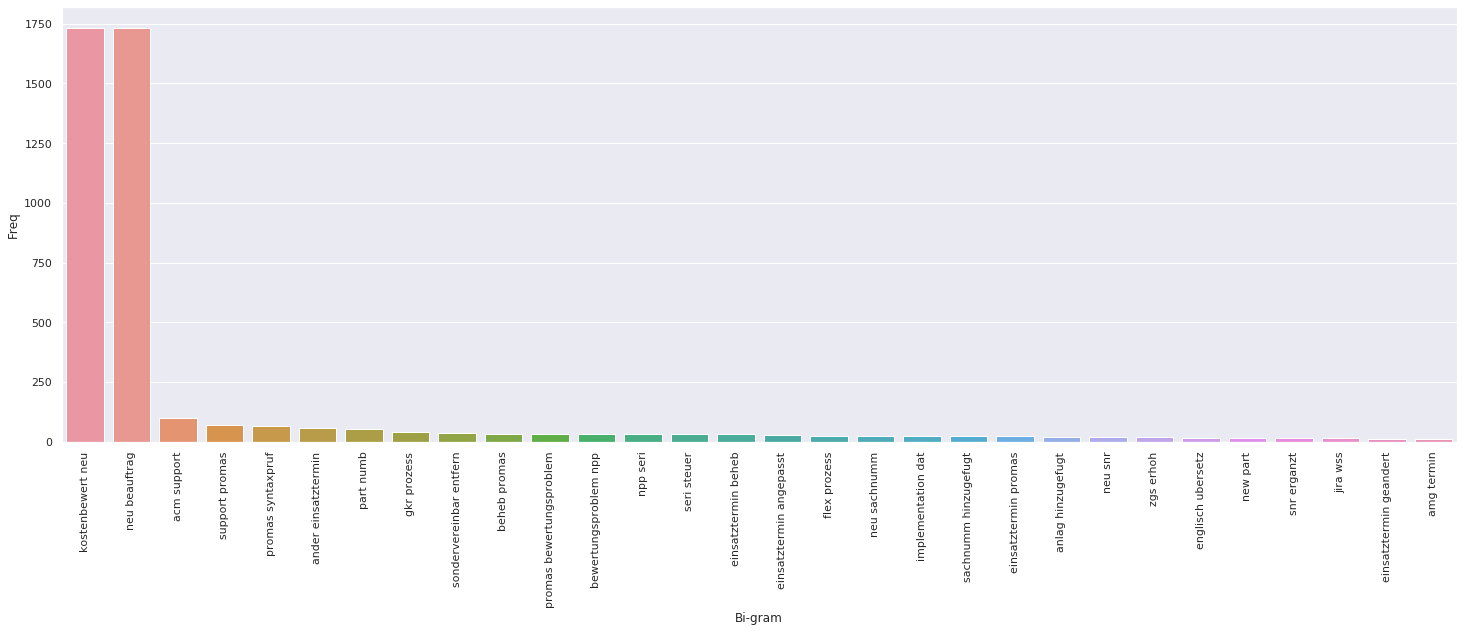

In [635]:
#Most frequently occuring Bi-grams
def get_top_n2_words(docs, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(docs)
    bag_of_words = vec1.transform(docs)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(str_docs, n=30)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(25,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90)

                             Tri-gram  Freq
0          kostenbewert neu beauftrag  1728
1                  acm support promas    70
2           support promas syntaxpruf    64
3      beheb promas bewertungsproblem    32
4        promas bewertungsproblem npp    32
5          bewertungsproblem npp seri    32
6                     npp seri steuer    32
7           ander einsatztermin beheb    31
8          einsatztermin beheb promas    31
9          ander einsatztermin promas    20
10              flex prozess erledigt    12
11               jira wss tragerplatt    11
12              wss tragerplatt ander    11
13  tragerplatt ander staubschutzkapp    11
14                      new part numb    11
15             rucksprach ilmberg ecs    11
16            ilmberg ecs prozessiert    11
17                   acm support mail     9
18                support mail schrad     9
19                  frau ank weidlich     8


[Text(0, 0, 'kostenbewert neu beauftrag'),
 Text(0, 0, 'acm support promas'),
 Text(0, 0, 'support promas syntaxpruf'),
 Text(0, 0, 'beheb promas bewertungsproblem'),
 Text(0, 0, 'promas bewertungsproblem npp'),
 Text(0, 0, 'bewertungsproblem npp seri'),
 Text(0, 0, 'npp seri steuer'),
 Text(0, 0, 'ander einsatztermin beheb'),
 Text(0, 0, 'einsatztermin beheb promas'),
 Text(0, 0, 'ander einsatztermin promas'),
 Text(0, 0, 'flex prozess erledigt'),
 Text(0, 0, 'jira wss tragerplatt'),
 Text(0, 0, 'wss tragerplatt ander'),
 Text(0, 0, 'tragerplatt ander staubschutzkapp'),
 Text(0, 0, 'new part numb'),
 Text(0, 0, 'rucksprach ilmberg ecs'),
 Text(0, 0, 'ilmberg ecs prozessiert'),
 Text(0, 0, 'acm support mail'),
 Text(0, 0, 'support mail schrad'),
 Text(0, 0, 'frau ank weidlich')]

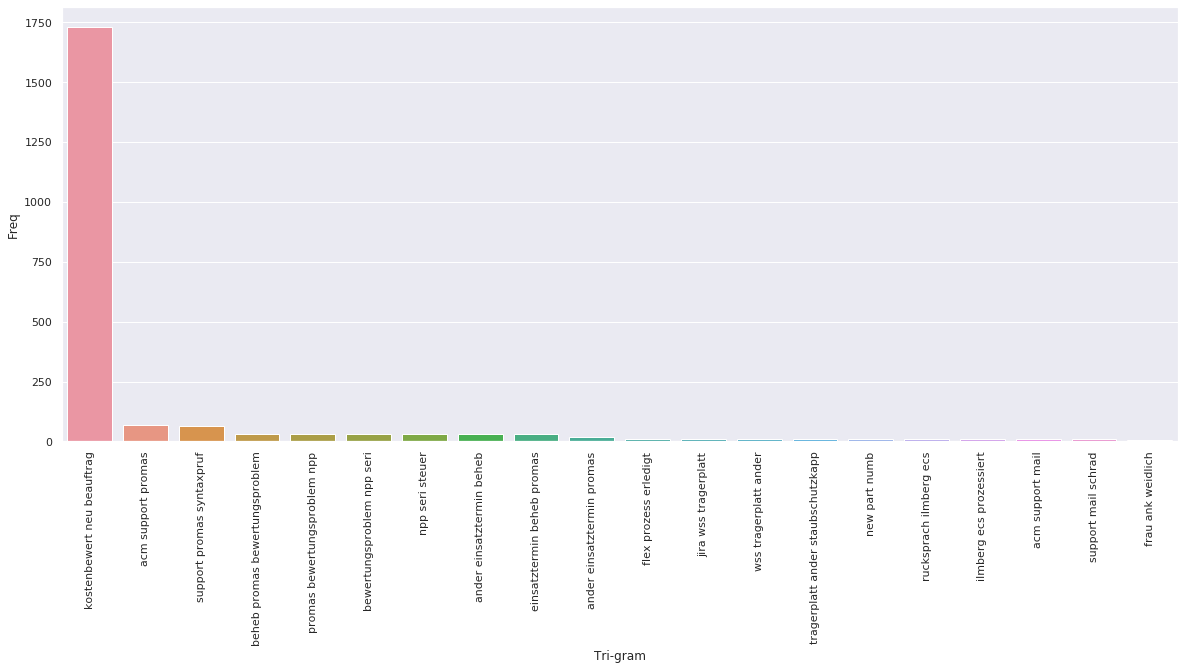

In [636]:
#Most frequently occuring Tri-grams
def get_top_n3_words(docs, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(docs)
    bag_of_words = vec1.transform(docs)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top3_words = get_top_n3_words(str_docs, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=90)

In [637]:
index_ruck_snr = df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('SNR')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()
index_ruck_sachnummer = df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('Sachnummer')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()
index_ruck_teil = df_bnd_s.loc[df_bnd_s['RUECKSPRUNG_KOMMENTAR'].str.contains('Teil')]['RUECKSPRUNG_KOMMENTAR'].index.tolist()

In [638]:
list_ruck_snr_relevant = []
list_ruck_snr_relevant = list(set(index_ruck_snr + index_ruck_sachnummer + index_ruck_teil))
len(list_ruck_snr_relevant)

536

## 4. Analyzing influencing factors of processing time of Bündels

In [639]:
df_bnd_s.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'KAT_x', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK', 'MK_BENENNUNG', 'ProduktKlasse', 'word_count_benennung',
       'word_count_stichwort', 'word_count_rueck', 'word_count_berg_rueck',
       'word_count_ist', 'word_count_soll', 'KAT_y'],
      dtype='object')

In [640]:
# Focus on Abgeschlossen EC
df_bnd_s_abgeschlossen = df_bnd_s.loc[df_bnd_s['PROZESS_STATUS'] == 'ABGESCHLOSSEN']

In [641]:
df_bnd_s_abgeschlossen['BUENDEL_NUMMER'].nunique()

6519

In [642]:
df_bnd_s['BUENDEL_NUMMER'].nunique()

20528

In [643]:
# for S-Class, there are 24462 Bündels
# Focus on 'Abgeschlossen' Bündels
df_bnd_s.groupby(['PROZESS_STATUS'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

PROZESS_STATUS
BEWERTUNG            10329
ABGESCHLOSSEN         6519
ABGEBROCHEN           1624
NACH_NCM_VERSORGT     1369
DETAILLIERUNG          587
VERTEILUNG              98
KOBE                     2
Name: BUENDEL_NUMMER, dtype: int64

In [644]:
df_bnd_s_abgeschlossen.groupby(['RUECKMELDE_DATUM'])['BUENDEL_NUMMER'].nunique()

RUECKMELDE_DATUM
2014-05-07    1
2014-06-11    2
2014-06-17    1
2014-07-04    1
2014-07-21    1
             ..
2020-06-08    1
2020-06-10    1
2020-07-15    1
2020-07-27    1
2099-01-14    1
Name: BUENDEL_NUMMER, Length: 1069, dtype: int64

In [645]:
lisst_ruckdatum = df_bnd_s_abgeschlossen['RUECKMELDE_DATUM'].tolist()

In [646]:
lisst_ruckdatum.sort()

In [647]:
# Feedback date is from 2013 to 2020
lisst_ruckdatum

[Timestamp('2014-05-07 00:00:00'),
 Timestamp('2014-06-11 00:00:00'),
 Timestamp('2014-06-11 00:00:00'),
 Timestamp('2014-06-17 00:00:00'),
 Timestamp('2014-07-04 00:00:00'),
 Timestamp('2014-07-21 00:00:00'),
 Timestamp('2014-08-29 00:00:00'),
 Timestamp('2014-08-29 00:00:00'),
 Timestamp('2014-09-03 00:00:00'),
 Timestamp('2014-09-12 00:00:00'),
 Timestamp('2014-10-01 00:00:00'),
 Timestamp('2014-10-02 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-12-03 00:00:00'),
 Timestamp('2014-12-04 00:00:00'),
 Timestamp('2014-12-10 00:00:00'),
 Timestamp('2014-12-31 00:00:00'),
 Timestamp('2015-01-12 00:00:00'),
 Timestamp('2015-01-12 00:00:00'),
 Timestamp('2015-02-13 00:00:00'),
 Timestamp('2015-02-13 00:00:00'),
 Timestamp('2015-02-26 00:00:00'),
 Timestamp('2015-03-20 00:00:00'),
 Timestamp('2015-03-20 00:00:00'),
 Timestamp('2015-03-24 00:00:00'),
 Timestamp('2015-03-25 00:00:00'),
 Timestamp('2015-04-10 00:00:00'),
 Timestamp('2015-04-13 00:00:00'),
 Timestamp('2015-05-

In [648]:
# Calculate duration of processing time of finished ECs
df_bnd_s_abgeschlossen['CREATION_DATE'] = df_bnd_s_abgeschlossen['CREATION_DATE'].apply(lambda x: pd.to_datetime(x).date())
df_bnd_s_abgeschlossen['RUECKMELDE_DATUM'] = df_bnd_s_abgeschlossen['RUECKMELDE_DATUM'].apply(lambda x: pd.to_datetime(x).date())

df_bnd_s_abgeschlossen['DAUER'] = df_bnd_s_abgeschlossen['RUECKMELDE_DATUM'] - df_bnd_s_abgeschlossen['CREATION_DATE']

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [649]:
df_bnd_s_abgeschlossen[['CREATION_DATE','RUECKMELDE_DATUM','DAUER']]

,CREATION_DATE,RUECKMELDE_DATUM,DAUER
1,2016-05-23,2016-06-21,29 days
2,2018-01-17,2018-02-20,34 days
3,2016-06-14,2016-07-22,38 days
4,2016-02-18,2016-07-13,146 days
5,2016-11-11,2017-01-03,53 days
...,...,...,...
21933,2015-02-25,2015-04-13,47 days
21936,2015-11-06,2015-12-22,46 days
21937,2015-10-16,2015-12-18,63 days
21941,2015-11-04,2015-12-23,49 days


In [650]:
# drop bundels with wrong Ruckmeldung_datum, e.g. in year 2033...2099 
df_bnd_s_abgeschlossen_dauer = df_bnd_s_abgeschlossen.loc[(df_bnd_s_abgeschlossen['DAUER'] > '1000 days')==False]
df_bnd_s_abgeschlossen_dauer

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT_x,new_IST,...,MK_BENENNUNG,ProduktKlasse,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll,KAT_y,DAUER
1,1204830546186,0012789-001,2016-05-23,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,Vorbau,C-Klasse,1,2,1,1,17,4,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,29 days
2,1223690159553,0031522-013,2018-01-17,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,Vorbau,C-Klasse,4,5,1,1,1,21,Gesetzliche Massnahme,34 days
3,1205519126084,0013708-001,2016-06-14,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,Vorbau,C-Klasse,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,38 days
4,1202819084461,0008365-001,2016-02-18,2016-07-13,FERTIG,Standardbündel,DS Dokumentation bei Lenkungsbefestigungsplatten,12,GuK-Fall - Verbesserung Qualitaet,fehlende DS-P Merkmal<E> missing DS-P feature ...,...,Vorbau,C-Klasse,1,4,10,1,11,19,GuK-Fall - Verbesserung Qualitaet,146 days
5,1209327079359,0020703-001,2016-11-11,2017-01-03,FERTIG,Standardbündel,Klebenahtänderung,12,GuK-Fall - Verbesserung Qualitaet,Die Qualitätsanforderungen für die verschieden...,...,Vorbau,C-Klasse,1,1,1,1,13,23,GuK-Fall - Verbesserung Qualitaet,53 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21933,1200968919060,0002909-001,2015-02-25,2015-04-13,FERTIG,Standardbündel,"Toleranz-, Materialänderung U-leitung",31,Marktanforderung,alter LFT kann Teil (Unterdruckleitung für Bre...,...,Bremsgeräte inkl. Leitungen,C-Klasse,1,3,1,1,11,15,Marktanforderung,47 days
21936,1202051982376,0006058-001,2015-11-06,2015-12-22,FERTIG,MRA,CCC_BR203_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,MB Accessories,C-Klasse,1,1,1,1,5,5,Gesetzliche Massnahme,46 days
21937,1202051982080,0005610-002,2015-10-16,2015-12-18,FERTIG,RD/KIA,CCC_BR171_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,MB Accessories,C-Klasse,1,1,1,1,5,5,Gesetzliche Massnahme,63 days
21941,1202051581379,0006005-001,2015-11-04,2015-12-23,FERTIG,RD/KIA,CCC_BR209_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,MB Accessories,C-Klasse,1,1,1,1,5,5,Gesetzliche Massnahme,49 days


In [651]:
# average duration of Bundel processing time for S-Class is 66 days
df_bnd_s_abgeschlossen_dauer['DAUER'].describe()

count                       6907
mean     71 days 11:54:53.528304
std      71 days 01:32:39.585580
min              0 days 00:00:00
25%             34 days 00:00:00
50%             47 days 00:00:00
75%             81 days 00:00:00
max            815 days 00:00:00
Name: DAUER, dtype: object

In [652]:
# Histogram Dauer
quantile_list = [0, .25, .5, .75, 1.]


quantiles = df_bnd_s_abgeschlossen_dauer['DAUER'].quantile(quantile_list).astype('timedelta64[D]').quantile(quantile_list)
quantiles

# quantiles_new = df_bnd_s_abgeschlossen_dauer.loc[input_df_cal_dauer['RUECKSPRUNG_KOMMENTAR'].str.contains('nan')==False]['Dauer'].astype('timedelta64[D]').quantile(quantile_list)
# quantiles_new

0.00      0.0
0.25     34.0
0.50     47.0
0.75     81.0
1.00    815.0
Name: DAUER, dtype: float64

Text(0, 0.5, 'Häufigkeit')

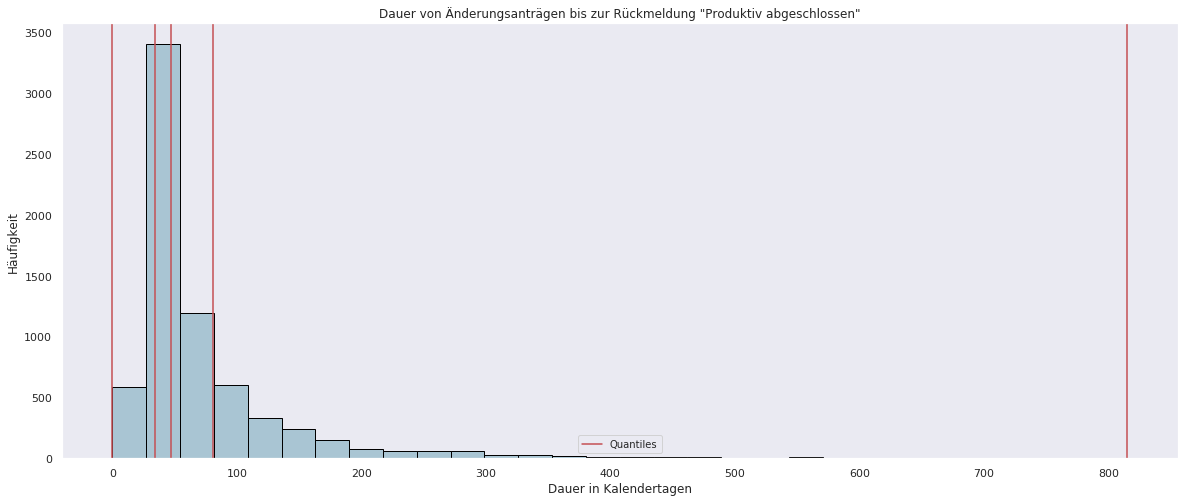

In [653]:
fig, ax = plt.subplots()
df_bnd_s_abgeschlossen_dauer['DAUER'].astype('timedelta64[D]').hist(bins=30, color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Dauer von Änderungsanträgen bis zur Rückmeldung "Produktiv abgeschlossen"', 
             fontsize=12)
ax.set_xlabel('Dauer in Kalendertagen', fontsize=12)
ax.set_ylabel('Häufigkeit', fontsize=12)

In [654]:
# Labeling Bündel with Duration Category
# def dauer_cat(row):
#     if row['DAUER'] > pd.to_timedelta('42 days'):
#         val = 'longer'
#     elif row['DAUER'] < pd.to_timedelta('42 days'):
#         val = 'shorter'
#     else:
#         val = 'equal'
#     return val

def dauer_cat(row):
    if row['DAUER'] <= pd.to_timedelta('43 days'):
        val = 'Shorter'
    #elif (row['DAUER'] > pd.to_timedelta('42 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
        #val = 'Q2'
#     elif (row['DAUER'] > pd.to_timedelta('33 days')) & (row['DAUER'] <= pd.to_timedelta('64 days')):
#         val = 'Q3'
    else:
        val = 'Longer'
    return val

df_bnd_s_abgeschlossen_dauer['DAUER_KAT'] = df_bnd_s_abgeschlossen_dauer.apply(dauer_cat, axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [655]:
df_bnd_s_abgeschlossen_dauer[['DAUER','DAUER_KAT']]

,DAUER,DAUER_KAT
1,29 days,Shorter
2,34 days,Shorter
3,38 days,Shorter
4,146 days,Longer
5,53 days,Longer
...,...,...
21933,47 days,Longer
21936,46 days,Longer
21937,63 days,Longer
21941,49 days,Longer


## 5. Change Impact Analysis

### Load SNR related data

In [656]:
df_snrimbuendel = pd.read_parquet(home_dir_tables + 'T_ACM_EKCRBUSD301_SachnummerImBuendelEntity.parquet', engine='pyarrow')

In [657]:
df_snrimbuendel = df_snrimbuendel[['SACHNUMMER','BUENDEL_FK','MODULSUBKOMPONENTE','ZB_BENENNUNG','MODULGRUPPE']]

In [658]:
# merge with buendel entity to get buendel number
new_df_linkbuendelsnr = df_bnd_s_abgeschlossen_dauer.merge(df_snrimbuendel, left_on='Bnd_ID', right_on='BUENDEL_FK')

In [659]:
# choose relavent columns to form a new dataframe
df_linkbuendelsnr = pd.DataFrame
df_linkbuendelsnr = new_df_linkbuendelsnr[['BUENDEL_NUMMER','SACHNUMMER','MODULSUBKOMPONENTE','ZB_BENENNUNG','MODULGRUPPE']]
df_linkbuendelsnr

,BUENDEL_NUMMER,SACHNUMMER,MODULSUBKOMPONENTE,ZB_BENENNUNG,MODULGRUPPE
0,0012789-001,A2136281200,09001,AUFNAHME,011
1,0031522-013,A0006210000,09001,GEWINDEPLATTE,015
2,0013708-001,A2056220000,08201,QUERTRAEGER VO OB,011
3,0013708-001,A2056220500,09101,LAENGSTRAEGER UT LI,011
4,0013708-001,A2536208500,08301,ZB INTEGRALTRAEGER VST,011
...,...,...,...,...,...
66916,0005610-002,A1716800235,02002,ZB ABDECKSCHIENE RE / UNTER TUER,021
66917,0005610-002,A1716800135,02002,ZB ABDECKSCHIENE LI / UNTER TUER,021
66918,0006005-001,A2098900000,02208,ZB WARNDREIECK,021
66919,0006005-001,A2098900097,02208,ZB WARNDREIECK / MIT FILZ,021


In [660]:
# only focus on A-SNR
df_linkbuendelsnr['Kennbuchstabe'] = df_linkbuendelsnr['SACHNUMMER'].astype(str).str[0]
indexNames_dropsnr_notA = df_linkbuendelsnr.loc[df_linkbuendelsnr['Kennbuchstabe'] != 'A'].index
df_linkbuendelsnr.drop(indexNames_dropsnr_notA, inplace=True)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [661]:
df_linkbuendelsnr['MODULSUBKOMPONENTE'] = df_linkbuendelsnr['MODULSUBKOMPONENTE'].fillna(0)
df_linkbuendelsnr['MODULGRUPPE'] = df_linkbuendelsnr['MODULGRUPPE'].fillna(999)

# convert columns to appropriate datatype
df_linkbuendelsnr['BUENDEL_NUMMER'] = df_linkbuendelsnr['BUENDEL_NUMMER'].astype('str')
df_linkbuendelsnr['SACHNUMMER'] = df_linkbuendelsnr['SACHNUMMER'].astype('str')
df_linkbuendelsnr['MODULSUBKOMPONENTE'] = df_linkbuendelsnr['MODULSUBKOMPONENTE'].astype('int')
df_linkbuendelsnr['ZB_BENENNUNG'] = df_linkbuendelsnr['ZB_BENENNUNG'].astype('str')
df_linkbuendelsnr['MODULGRUPPE'] = df_linkbuendelsnr['MODULGRUPPE'].astype('int')

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [662]:
# extract MK und MSK from the 5-digit MODULSUBKOMPONENT
for i, row in df_linkbuendelsnr.iterrows():
    temp_msk = str(row['MODULSUBKOMPONENTE']).zfill(5)
    #df_linkbuendelsnr.set_value(i,'MSK',temp_msk)
    df_linkbuendelsnr.at[i,'MSK'] = temp_msk

/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [663]:
for i, row in df_linkbuendelsnr.iterrows():
    temp_mk = row['MSK'][0:3]
    temp_msubk = row['MSK'][3:5]
    #df_linkbuendelsnr.set_value(i,'MK',temp_mk)
    #df_linkbuendelsnr.set_value(i,'SUBK',temp_msubk)
    df_linkbuendelsnr.at[i,'MK'] = temp_mk
    df_linkbuendelsnr.at[i,'SUBK'] = temp_msubk

In [664]:
# drop items in which MG or MK is invalid
df_linkbuendelsnr = df_linkbuendelsnr.drop('MODULSUBKOMPONENTE', 1)

### Decompose SNR into:

* Kennbuchstabe (SNR-Kennbuchstabe) → 1. Stelle in der A-Sachnummer
* Typzahl → 2. bis einschließlich 4. Stelle in der A-Sachnummer
* Konstruktions_Haupt_und_Untergruppe (Konstruktions-Haupt- und Untergruppe) → 5. bis einschließlich 7. Stelle der A-Sachnummer
* Fortlaufende_Nummer (Abwandlung oder fortlaufende Nummer) → 8. und 9. Stelle der A-Sachnummer
* Teilnummer_Untergruppe (Teilnummer bezogen auf die Untergruppe) → 10. und 11. Stelle der A-Sachnummer

In [665]:
for i, row in df_linkbuendelsnr.iterrows():
    temp_typzahl = 'No Value'
    temp_kg = 'No Value'
    temp_u = 'No Value'
    temp_kgu = 'No Value'
    temp_fortlaufende_nummer = 'No Value'
    temp_teilnummer_untergruppe = 'No Value'
    
    temp_typzahl = row['SACHNUMMER'][1:4]
    temp_kg = row['SACHNUMMER'][4:6]
    temp_u = row['SACHNUMMER'][6:7]
    temp_kgu = row['SACHNUMMER'][4:7]
    temp_fortlaufende_nummer = row['SACHNUMMER'][7:9]
    temp_teilnummer_untergruppe = row['SACHNUMMER'][9:11]
    
#     df_snrimbuendel.set_value(i,'TypZahl',temp_typzahl)
#     df_snrimbuendel.set_value(i,'Konstruktions_Haupt_und_Untergruppe',temp_k_haupt_untergruppe)
#     df_snrimbuendel.set_value(i,'Fortlaufende_Nummer',temp_fortlaufende_nummer)
#     df_snrimbuendel.set_value(i,'Teilnummer_Untergruppe',temp_teilnummer_untergruppe)
    df_linkbuendelsnr.at[i,'TypZahl'] = temp_typzahl
    df_linkbuendelsnr.at[i,'KG'] = temp_kg
    df_linkbuendelsnr.at[i,'U'] = temp_u
    df_linkbuendelsnr.at[i,'KGU'] = temp_kgu
    df_linkbuendelsnr.at[i,'Fortlaufende_Nummer'] = temp_fortlaufende_nummer
    df_linkbuendelsnr.at[i,'Teilnummer_Untergruppe'] = temp_teilnummer_untergruppe

### Merge two dataframes: df_linkbuendelsnr and df_bnd_s_abgeschlossen_dauer, link SNRs with change description

In [666]:
df_linkbuendelsnr

,BUENDEL_NUMMER,SACHNUMMER,ZB_BENENNUNG,MODULGRUPPE,Kennbuchstabe,MSK,MK,SUBK,TypZahl,KG,U,KGU,Fortlaufende_Nummer,Teilnummer_Untergruppe
0,0012789-001,A2136281200,AUFNAHME,11,A,09001,090,01,213,62,8,628,12,00
1,0031522-013,A0006210000,GEWINDEPLATTE,15,A,09001,090,01,000,62,1,621,00,00
2,0013708-001,A2056220000,QUERTRAEGER VO OB,11,A,08201,082,01,205,62,2,622,00,00
3,0013708-001,A2056220500,LAENGSTRAEGER UT LI,11,A,09101,091,01,205,62,2,622,05,00
4,0013708-001,A2536208500,ZB INTEGRALTRAEGER VST,11,A,08301,083,01,253,62,0,620,85,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66916,0005610-002,A1716800235,ZB ABDECKSCHIENE RE / UNTER TUER,21,A,02002,020,02,171,68,0,680,02,35
66917,0005610-002,A1716800135,ZB ABDECKSCHIENE LI / UNTER TUER,21,A,02002,020,02,171,68,0,680,01,35
66918,0006005-001,A2098900000,ZB WARNDREIECK,21,A,02208,022,08,209,89,0,890,00,00
66919,0006005-001,A2098900097,ZB WARNDREIECK / MIT FILZ,21,A,02208,022,08,209,89,0,890,00,97


In [667]:
df_linkbuendelsnr['BUENDEL_NUMMER'].nunique()

6126

In [668]:
df_buendel_linked = df_linkbuendelsnr.merge(df_bnd_s_abgeschlossen_dauer, left_on = 'BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

In [669]:
df_buendel_linked = df_buendel_linked.drop_duplicates()

In [670]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'Kennbuchstabe', 'MSK', 'MK_x', 'SUBK', 'TypZahl', 'KG', 'U', 'KGU',
       'Fortlaufende_Nummer', 'Teilnummer_Untergruppe', 'Bnd_ID',
       'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS', 'BENENNUNG', 'STICHWORT',
       'VERURSACHER', 'KAT_x', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ',
       'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS',
       'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'MK_y', 'MK_BENENNUNG', 'ProduktKlasse',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'KAT_y',
       'DAUER', 'DAUER_KAT'],
      dtype='object')

In [671]:
df_buendel_linked = df_buendel_linked.drop(columns=['KAT_x'])

In [672]:
df_buendel_linked.columns = ['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'Kennbuchstabe', 'MSK', 'MK', 'SUBK', 'TypZahl', 'KG', 'U', 'KGU',
       'Fortlaufende_Nummer', 'Teilnummer_Untergruppe', 'Bnd_ID',
       'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS', 'BENENNUNG', 'STICHWORT',
        'VERURSACHER','new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse', 'word_count_benennung',
       'word_count_stichwort', 'word_count_rueck', 'word_count_berg_rueck',
       'word_count_ist', 'word_count_soll', 'Bnd_KAT', 'DAUER', 'DAUER_KAT']


In [673]:
df_buendel_linked = df_buendel_linked.merge(df_mk, left_on='MK', right_on='MK')

In [674]:
df_buendel_linked

,BUENDEL_NUMMER,SACHNUMMER,ZB_BENENNUNG,MODULGRUPPE,Kennbuchstabe,MSK,MK,SUBK,TypZahl,KG,...,word_count_benennung,word_count_stichwort,word_count_rueck,word_count_berg_rueck,word_count_ist,word_count_soll,Bnd_KAT,DAUER,DAUER_KAT,MK_BENENNUNG
0,0012789-001,A2136281200,AUFNAHME,11,A,09001,090,01,213,62,...,1,2,1,1,17,4,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,29 days,Shorter,Vorbau
1,0031522-013,A0006210000,GEWINDEPLATTE,15,A,09001,090,01,000,62,...,4,5,1,1,1,21,Gesetzliche Massnahme,34 days,Shorter,Vorbau
2,0013708-001,A2056210100,VERSTAERKUNG VO LI,11,A,09001,090,01,205,62,...,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,38 days,Shorter,Vorbau
3,0013708-001,A2056210200,VERSTAERKUNG VO RE,11,A,09001,090,01,205,62,...,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,38 days,Shorter,Vorbau
4,0013708-001,A2056282100,VERSTEIFUNG VO LI,11,A,09001,090,01,205,62,...,1,3,1,1,19,19,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,38 days,Shorter,Vorbau
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62538,0002970-004,A2316100175,ZB ERSATZRADMULDE VST,11,A,08001,080,01,231,61,...,6,6,4,1,10,8,Marktanforderung,31 days,Shorter,Heckboden/ Heckmittelstück oben
62539,0002970-004,A2316100114,ZB QUERTRAEGER / HINTER KOFFERRAUM,11,A,08001,080,01,231,61,...,6,6,4,1,10,8,Marktanforderung,31 days,Shorter,Heckboden/ Heckmittelstück oben
62540,0002970-004,A2316100062,ZB BODENGRUPPE VST HI,11,A,08701,087,01,231,61,...,6,6,4,1,10,8,Marktanforderung,31 days,Shorter,Hauptboden
62541,0002215-001,A2048870000,DICHTUNG F MOTORHAUBE,11,A,08501,085,01,204,88,...,1,7,1,1,1,33,GuK-Fall - Verbesserung Qualitaet,35 days,Shorter,Motorhaube


In [675]:
# add prefix for MK/KG for better understanding
MK_arr = []
KG_arr = []
MK_arr = ['MK_'+ s for s in df_buendel_linked['MK'].values.astype(str)]
KG_arr = ['KG_'+ s for s in df_buendel_linked['KG'].values.astype(str)]

df_buendel_linked['MK'] = MK_arr
df_buendel_linked['KG'] = KG_arr

In [676]:
# add prefix for MSK/KGU for better understanding
MSK_arr = []
KGU_arr = []
MSK_arr = ['MSK_'+ s for s in df_buendel_linked['MSK'].values.astype(str)]
KGU_arr = ['KGU_'+ s for s in df_buendel_linked['KGU'].values.astype(str)]

df_buendel_linked['MSK'] = MSK_arr
df_buendel_linked['KGU'] = KGU_arr

In [677]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'Kennbuchstabe', 'MSK', 'MK', 'SUBK', 'TypZahl', 'KG', 'U', 'KGU',
       'Fortlaufende_Nummer', 'Teilnummer_Untergruppe', 'Bnd_ID',
       'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS', 'BENENNUNG', 'STICHWORT',
       'VERURSACHER', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ',
       'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS',
       'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'Bnd_KAT',
       'DAUER', 'DAUER_KAT', 'MK_BENENNUNG'],
      dtype='object')

#### delete instances that have less target variable (MK/KG <50)

In [678]:
df_buendel_linked.groupby(['MK_BENENNUNG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=True).head(45)

MK_BENENNUNG
Heckboden/ Heckmittelstück oben                             1
Hauptboden                                                  1
Motorhaube                                                  1
Produktschutz                                               1
Mechanische Motorensteuerung                                2
Einspritzung                                                3
Ölkreislauf                                                 4
Verteilergetriebe                                           4
Seitenwand                                                  4
Aufladung                                                   5
Integralträger                                              6
Grundmotor                                                  6
Riementrieb                                                 6
Innenspiegel                                                7
Anfahrelemente                                              7
Sitzkomfortelektronik                                    

In [679]:
df_buendel_linked.groupby(['KG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=True).head(25)

KG
KG_03     1
KG_93     1
KG_23     1
KG_30     2
KG_85     2
KG_64     2
KG_07     2
KG_26     3
KG_25     3
KG_00     3
KG_84     4
KG_28     4
KG_05     4
KG_87     5
KG_79     8
KG_44    12
KG_31    12
KG_29    13
KG_22    15
KG_80    17
KG_52    22
KG_43    23
KG_61    24
KG_15    25
KG_20    27
Name: BUENDEL_NUMMER, dtype: int64

In [680]:
index_tooless_mk = []
index_tooless_mk = df_buendel_linked.groupby(['MK_BENENNUNG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=True).head(45).index.tolist()
index_tooless_mk

['Heckboden/ Heckmittelstück oben',
 'Hauptboden',
 'Motorhaube',
 'Produktschutz',
 'Mechanische Motorensteuerung',
 'Einspritzung',
 'Ölkreislauf',
 'Verteilergetriebe',
 'Seitenwand',
 'Aufladung',
 'Integralträger',
 'Grundmotor',
 'Riementrieb',
 'Innenspiegel',
 'Anfahrelemente',
 'Sitzkomfortelektronik',
 'E-Motoren',
 'Wasserpumpe',
 'Scharniere und Türantrieb',
 'Elektronik für Antrieb von Türen und Klappen',
 'Lenksäule',
 'Starter/Generator',
 'Pedalanlage und Fahrpedal',
 'MB Accessories',
 'Wisch/Waschsysteme',
 'Getriebekomponenten',
 'Brennstoffzelle',
 'E/E Komponenten passive Sicherheit',
 'Sonderfahrzeuge / Kundenwünsche',
 'Kombiinstrument',
 'Vorderachsgetriebe',
 'Bremsgeräte inkl. Leitungen',
 'Türen Rohbau,/ Dichtungen/ Zierrat',
 'Oberfläche',
 'Rückwandtür',
 'Motor vollständig',
 'Türmodul',
 'Lenkgetriebe',
 'Zugangs und Fahrberechtigungssystem/Diebstahlwarnanlage',
 'Hochvoltverkabelung',
 'Antennen',
 'Vorderachse',
 'AGR System',
 'Außenspiegel',
 'Dachzie

In [681]:
list_index_tooless_mk = []
list_index_tooless_mk= df_buendel_linked.loc[df_buendel_linked['MK_BENENNUNG'].isin(index_tooless_mk)].index
list_index_tooless_mk

Int64Index([ 2572,  2573,  2574,  2575,  2576,  2577,  2578,  2579,  2580,
             2581,
            ...
            62533, 62534, 62535, 62536, 62537, 62538, 62539, 62540, 62541,
            62542],
           dtype='int64', length=4777)

In [682]:
df_buendel_linked.drop(list_index_tooless_mk,inplace=True)

In [683]:
index_tooless_kg = []
index_tooless_kg = df_buendel_linked.groupby(['KG'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=True).head(25).index.tolist()
index_tooless_kg

['KG_93',
 'KG_03',
 'KG_26',
 'KG_23',
 'KG_85',
 'KG_05',
 'KG_64',
 'KG_00',
 'KG_84',
 'KG_87',
 'KG_43',
 'KG_79',
 'KG_44',
 'KG_20',
 'KG_31',
 'KG_22',
 'KG_33',
 'KG_80',
 'KG_76',
 'KG_14',
 'KG_15',
 'KG_52',
 'KG_61',
 'KG_41',
 'KG_77']

In [684]:
list_index_tooless_kg = []
list_index_tooless_kg = df_buendel_linked.loc[df_buendel_linked['KG'].isin(index_tooless_kg)].index
list_index_tooless_kg

Int64Index([   59,    60,    61,   159,   160,   161,   162,   163,   190,
              191,
            ...
            62504, 62505, 62506, 62507, 62508, 62509, 62510, 62511, 62512,
            62513],
           dtype='int64', length=1471)

In [685]:
df_buendel_linked.drop(list_index_tooless_kg,inplace=True)

#### Combine multi variables into one.

In [686]:
df_buendel_typ = df_buendel_linked[['BUENDEL_NUMMER','TypZahl']].drop_duplicates()
concat_df_buendel_typ = df_buendel_typ.groupby(['BUENDEL_NUMMER'])['TypZahl'].apply(';'.join).reset_index()
concat_df_buendel_typ

,BUENDEL_NUMMER,TypZahl
0,0001809-001,205
1,0001937-001,212;204
2,0001974-001,000
3,0001988-001,205
4,0002002-001,272;273
...,...,...
5124,0075248-001,000;206;204
5125,0076215-001,651
5126,0077420-001,000
5127,0078485-001,204


In [687]:
df_buendel_mk = df_buendel_linked[['BUENDEL_NUMMER','MK']].drop_duplicates()
concat_df_buendel_mk = df_buendel_mk.groupby(['BUENDEL_NUMMER'])['MK'].apply(';'.join).reset_index()
concat_df_buendel_mk

,BUENDEL_NUMMER,MK
0,0001809-001,MK_022
1,0001937-001,MK_024
2,0001974-001,MK_027
3,0001988-001,MK_015
4,0002002-001,MK_054
...,...,...
5124,0075248-001,MK_093;MK_046
5125,0076215-001,MK_054
5126,0077420-001,MK_054
5127,0078485-001,MK_043


In [688]:
df_buendel_subk = df_buendel_linked[['BUENDEL_NUMMER','SUBK']].drop_duplicates()
concat_df_buendel_subk = df_buendel_subk.groupby(['BUENDEL_NUMMER'])['SUBK'].apply(';'.join).reset_index()
concat_df_buendel_subk

,BUENDEL_NUMMER,SUBK
0,0001809-001,07
1,0001937-001,03
2,0001974-001,01
3,0001988-001,01
4,0002002-001,01
...,...,...
5124,0075248-001,02;01
5125,0076215-001,01
5126,0077420-001,05
5127,0078485-001,03


In [689]:
df_buendel_msk = df_buendel_linked[['BUENDEL_NUMMER','MSK']].drop_duplicates()
concat_df_buendel_msk = df_buendel_msk.groupby(['BUENDEL_NUMMER'])['MSK'].apply(';'.join).reset_index()
concat_df_buendel_msk

,BUENDEL_NUMMER,MSK
0,0001809-001,MSK_02207
1,0001937-001,MSK_02403
2,0001974-001,MSK_02701
3,0001988-001,MSK_01501
4,0002002-001,MSK_05401
...,...,...
5124,0075248-001,MSK_09302;MSK_04601
5125,0076215-001,MSK_05401
5126,0077420-001,MSK_05405
5127,0078485-001,MSK_04303


In [690]:
df_buendel_kat=df_buendel_linked[['BUENDEL_NUMMER','Bnd_KAT']].drop_duplicates()
df_buendel_kat['Bnd_KAT'] = df_buendel_kat['Bnd_KAT'].astype('str')
concat_df_buendel_kat = df_buendel_kat.groupby(['BUENDEL_NUMMER'])['Bnd_KAT'].apply(';'.join).reset_index()

# sort strings in column EC_KATEGORIE of df_x
for i, row in concat_df_buendel_kat.iterrows():
    tmp_cat = list(row['Bnd_KAT'].split(sep=';'))
    tmp_cat.sort()
    cat = ','.join([str(elem) for elem in tmp_cat]) 
    #temp_art = ' '.join(set(row['ProduktArt'].split(sep=',')))
    concat_df_buendel_kat.at[i,'Bnd_KAT'] = cat

concat_df_buendel_kat

,BUENDEL_NUMMER,Bnd_KAT
0,0001809-001,Gesetzliche Massnahme
1,0001937-001,GuK-Fall - Verbesserung Qualitaet
2,0001974-001,GuK-Fall - Verbesserung Qualitaet
3,0001988-001,GuK-Fall - Verbesserung Qualitaet
4,0002002-001,GuK-Fall - Verbesserung Qualitaet
...,...,...
5124,0075248-001,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
5125,0076215-001,Marktanforderung
5126,0077420-001,Marktanforderung
5127,0078485-001,GuK-Fall - Verbesserung Qualitaet


In [691]:
concat_df_buendel_kat['Bnd_KAT'].nunique()

13

In [692]:
df_buendel_kg = df_buendel_linked[['BUENDEL_NUMMER','KG']].drop_duplicates()
df_buendel_kg['KG'] = df_buendel_kg['KG'].astype('str')
concat_df_buendel_kg = df_buendel_kg.groupby(['BUENDEL_NUMMER'])['KG'].apply(';'.join).reset_index()
concat_df_buendel_kg

,BUENDEL_NUMMER,KG
0,0001809-001,KG_58
1,0001937-001,KG_90
2,0001974-001,KG_91
3,0001988-001,KG_73;KG_72
4,0002002-001,KG_90
...,...,...
5124,0075248-001,KG_99;KG_35
5125,0076215-001,KG_90
5126,0077420-001,KG_90
5127,0078485-001,KG_54;KG_90


In [693]:
df_buendel_u = df_buendel_linked[['BUENDEL_NUMMER','U']].drop_duplicates()
df_buendel_u['U'] = df_buendel_u['U'].astype('str')
concat_df_buendel_u = df_buendel_u.groupby(['BUENDEL_NUMMER'])['U'].apply(';'.join).reset_index()
concat_df_buendel_u

,BUENDEL_NUMMER,U
0,0001809-001,4
1,0001937-001,2
2,0001974-001,0
3,0001988-001,0
4,0002002-001,3
...,...,...
5124,0075248-001,0;2
5125,0076215-001,2;3
5126,0077420-001,3;2
5127,0078485-001,0;5


In [694]:
df_buendel_kgu = df_buendel_linked[['BUENDEL_NUMMER','KGU']].drop_duplicates()
df_buendel_kgu['KGU'] = df_buendel_kgu['KGU'].astype('str')
concat_df_buendel_kgu = df_buendel_kgu.groupby(['BUENDEL_NUMMER'])['KGU'].apply(';'.join).reset_index()
concat_df_buendel_kgu

,BUENDEL_NUMMER,KGU
0,0001809-001,KGU_584
1,0001937-001,KGU_902
2,0001974-001,KGU_910
3,0001988-001,KGU_730;KGU_720
4,0002002-001,KGU_903
...,...,...
5124,0075248-001,KGU_990;KGU_352;KGU_350
5125,0076215-001,KGU_902;KGU_903
5126,0077420-001,KGU_903;KGU_902
5127,0078485-001,KGU_540;KGU_905


### Merge all variables via bnd-nummer

In [695]:
concat_df_buendel_typ_mk = pd.merge(concat_df_buendel_typ, concat_df_buendel_mk, 
                                   left_on='BUENDEL_NUMMER', right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_typ_mk

,BUENDEL_NUMMER,TypZahl,MK
0,0001809-001,205,MK_022
1,0001937-001,212;204,MK_024
2,0001974-001,000,MK_027
3,0001988-001,205,MK_015
4,0002002-001,272;273,MK_054
...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046
5125,0076215-001,651,MK_054
5126,0077420-001,000,MK_054
5127,0078485-001,204,MK_043


In [696]:
concat_df_buendel_mk_subk = pd.merge(concat_df_buendel_typ_mk, concat_df_buendel_subk, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_subk

,BUENDEL_NUMMER,TypZahl,MK,SUBK
0,0001809-001,205,MK_022,07
1,0001937-001,212;204,MK_024,03
2,0001974-001,000,MK_027,01
3,0001988-001,205,MK_015,01
4,0002002-001,272;273,MK_054,01
...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01
5125,0076215-001,651,MK_054,01
5126,0077420-001,000,MK_054,05
5127,0078485-001,204,MK_043,03


In [697]:
concat_df_buendel_mk_subk_msk = pd.merge(concat_df_buendel_mk_subk, concat_df_buendel_msk, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_subk_msk

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK
0,0001809-001,205,MK_022,07,MSK_02207
1,0001937-001,212;204,MK_024,03,MSK_02403
2,0001974-001,000,MK_027,01,MSK_02701
3,0001988-001,205,MK_015,01,MSK_01501
4,0002002-001,272;273,MK_054,01,MSK_05401
...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601
5125,0076215-001,651,MK_054,01,MSK_05401
5126,0077420-001,000,MK_054,05,MSK_05405
5127,0078485-001,204,MK_043,03,MSK_04303


In [698]:
concat_df_buendel_mk_cat = pd.merge(concat_df_buendel_mk_subk_msk,concat_df_buendel_kat, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK,Bnd_KAT
0,0001809-001,205,MK_022,07,MSK_02207,Gesetzliche Massnahme
1,0001937-001,212;204,MK_024,03,MSK_02403,GuK-Fall - Verbesserung Qualitaet
2,0001974-001,000,MK_027,01,MSK_02701,GuK-Fall - Verbesserung Qualitaet
3,0001988-001,205,MK_015,01,MSK_01501,GuK-Fall - Verbesserung Qualitaet
4,0002002-001,272;273,MK_054,01,MSK_05401,GuK-Fall - Verbesserung Qualitaet
...,...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...
5125,0076215-001,651,MK_054,01,MSK_05401,Marktanforderung
5126,0077420-001,000,MK_054,05,MSK_05405,Marktanforderung
5127,0078485-001,204,MK_043,03,MSK_04303,GuK-Fall - Verbesserung Qualitaet


In [699]:
concat_df_buendel_mk_cat_kg = pd.merge(concat_df_buendel_mk_cat, concat_df_buendel_kg, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat_kg

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK,Bnd_KAT,KG
0,0001809-001,205,MK_022,07,MSK_02207,Gesetzliche Massnahme,KG_58
1,0001937-001,212;204,MK_024,03,MSK_02403,GuK-Fall - Verbesserung Qualitaet,KG_90
2,0001974-001,000,MK_027,01,MSK_02701,GuK-Fall - Verbesserung Qualitaet,KG_91
3,0001988-001,205,MK_015,01,MSK_01501,GuK-Fall - Verbesserung Qualitaet,KG_73;KG_72
4,0002002-001,272;273,MK_054,01,MSK_05401,GuK-Fall - Verbesserung Qualitaet,KG_90
...,...,...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_99;KG_35
5125,0076215-001,651,MK_054,01,MSK_05401,Marktanforderung,KG_90
5126,0077420-001,000,MK_054,05,MSK_05405,Marktanforderung,KG_90
5127,0078485-001,204,MK_043,03,MSK_04303,GuK-Fall - Verbesserung Qualitaet,KG_54;KG_90


In [700]:
concat_df_buendel_mk_cat_kg_u = pd.merge(concat_df_buendel_mk_cat_kg, concat_df_buendel_u, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_mk_cat_kg_u

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK,Bnd_KAT,KG,U
0,0001809-001,205,MK_022,07,MSK_02207,Gesetzliche Massnahme,KG_58,4
1,0001937-001,212;204,MK_024,03,MSK_02403,GuK-Fall - Verbesserung Qualitaet,KG_90,2
2,0001974-001,000,MK_027,01,MSK_02701,GuK-Fall - Verbesserung Qualitaet,KG_91,0
3,0001988-001,205,MK_015,01,MSK_01501,GuK-Fall - Verbesserung Qualitaet,KG_73;KG_72,0
4,0002002-001,272;273,MK_054,01,MSK_05401,GuK-Fall - Verbesserung Qualitaet,KG_90,3
...,...,...,...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_99;KG_35,0;2
5125,0076215-001,651,MK_054,01,MSK_05401,Marktanforderung,KG_90,2;3
5126,0077420-001,000,MK_054,05,MSK_05405,Marktanforderung,KG_90,3;2
5127,0078485-001,204,MK_043,03,MSK_04303,GuK-Fall - Verbesserung Qualitaet,KG_54;KG_90,0;5


In [701]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_mk_cat_kg_u, concat_df_buendel_kgu, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_linked

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK,Bnd_KAT,KG,U,KGU
0,0001809-001,205,MK_022,07,MSK_02207,Gesetzliche Massnahme,KG_58,4,KGU_584
1,0001937-001,212;204,MK_024,03,MSK_02403,GuK-Fall - Verbesserung Qualitaet,KG_90,2,KGU_902
2,0001974-001,000,MK_027,01,MSK_02701,GuK-Fall - Verbesserung Qualitaet,KG_91,0,KGU_910
3,0001988-001,205,MK_015,01,MSK_01501,GuK-Fall - Verbesserung Qualitaet,KG_73;KG_72,0,KGU_730;KGU_720
4,0002002-001,272;273,MK_054,01,MSK_05401,GuK-Fall - Verbesserung Qualitaet,KG_90,3,KGU_903
...,...,...,...,...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_99;KG_35,0;2,KGU_990;KGU_352;KGU_350
5125,0076215-001,651,MK_054,01,MSK_05401,Marktanforderung,KG_90,2;3,KGU_902;KGU_903
5126,0077420-001,000,MK_054,05,MSK_05405,Marktanforderung,KG_90,3;2,KGU_903;KGU_902
5127,0078485-001,204,MK_043,03,MSK_04303,GuK-Fall - Verbesserung Qualitaet,KG_54;KG_90,0;5,KGU_540;KGU_905


In [702]:
df_amount_snr = df_buendel_linked.groupby(['BUENDEL_NUMMER'])['SACHNUMMER'].nunique().reset_index()

df_amount_snr_benennung = df_buendel_linked.groupby(['BUENDEL_NUMMER'])['ZB_BENENNUNG'].nunique().reset_index()

In [703]:
df_amount_snr.columns = ['BUENDEL_NUMMER','ANZAHL_SACHNUMMER']
df_amount_snr

,BUENDEL_NUMMER,ANZAHL_SACHNUMMER
0,0001809-001,25
1,0001937-001,4
2,0001974-001,8
3,0001988-001,24
4,0002002-001,20
...,...,...
5124,0075248-001,32
5125,0076215-001,2
5126,0077420-001,3
5127,0078485-001,6


In [704]:
df_amount_snr_benennung.columns = ['BUENDEL_NUMMER','ANZAHL_ZB_BENENNUNG']
df_amount_snr_benennung

,BUENDEL_NUMMER,ANZAHL_ZB_BENENNUNG
0,0001809-001,25
1,0001937-001,1
2,0001974-001,8
3,0001988-001,2
4,0002002-001,2
...,...,...
5124,0075248-001,30
5125,0076215-001,2
5126,0077420-001,2
5127,0078485-001,5


In [705]:
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, df_amount_snr, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_linked = pd.merge(concat_df_buendel_linked, df_amount_snr_benennung, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')
concat_df_buendel_linked

,BUENDEL_NUMMER,TypZahl,MK,SUBK,MSK,Bnd_KAT,KG,U,KGU,ANZAHL_SACHNUMMER,ANZAHL_ZB_BENENNUNG
0,0001809-001,205,MK_022,07,MSK_02207,Gesetzliche Massnahme,KG_58,4,KGU_584,25,25
1,0001937-001,212;204,MK_024,03,MSK_02403,GuK-Fall - Verbesserung Qualitaet,KG_90,2,KGU_902,4,1
2,0001974-001,000,MK_027,01,MSK_02701,GuK-Fall - Verbesserung Qualitaet,KG_91,0,KGU_910,8,8
3,0001988-001,205,MK_015,01,MSK_01501,GuK-Fall - Verbesserung Qualitaet,KG_73;KG_72,0,KGU_730;KGU_720,24,2
4,0002002-001,272;273,MK_054,01,MSK_05401,GuK-Fall - Verbesserung Qualitaet,KG_90,3,KGU_903,20,2
...,...,...,...,...,...,...,...,...,...,...,...
5124,0075248-001,000;206;204,MK_093;MK_046,02;01,MSK_09302;MSK_04601,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_99;KG_35,0;2,KGU_990;KGU_352;KGU_350,32,30
5125,0076215-001,651,MK_054,01,MSK_05401,Marktanforderung,KG_90,2;3,KGU_902;KGU_903,2,2
5126,0077420-001,000,MK_054,05,MSK_05405,Marktanforderung,KG_90,3;2,KGU_903;KGU_902,3,2
5127,0078485-001,204,MK_043,03,MSK_04303,GuK-Fall - Verbesserung Qualitaet,KG_54;KG_90,0;5,KGU_540;KGU_905,6,5


### Merge description with part info

In [706]:
input_df = pd.merge(df_bnd_s_abgeschlossen_dauer, concat_df_buendel_linked, left_on='BUENDEL_NUMMER',right_on='BUENDEL_NUMMER', how='inner')

input_df

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,KAT_x,new_IST,...,TypZahl,MK_y,SUBK,MSK,Bnd_KAT,KG,U,KGU,ANZAHL_SACHNUMMER,ANZAHL_ZB_BENENNUNG
0,1204830546186,0012789-001,2016-05-23,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Teil ist an neuen Lieferanten vergeben worden....,...,213,MK_090,01,MSK_09001,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_62,8,KGU_628,1,1
1,1223690159553,0031522-013,2018-01-17,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Gesetzliche Massnahme,Serie,...,000,MK_090,01,MSK_09001,Gesetzliche Massnahme,KG_62,1,KGU_621,1,1
2,1205519126084,0013708-001,2016-06-14,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,Belieferungsabsicherung des Aluminiumwerkstoff...,...,205;253,MK_090;MK_082;MK_091;MK_021,01;02,MSK_09001;MSK_08201;MSK_09101;MSK_02102,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_62,1;8;2,KGU_621;KGU_628;KGU_622,16,16
3,1209327079359,0020703-001,2016-11-11,2017-01-03,FERTIG,Standardbündel,Klebenahtänderung,12,GuK-Fall - Verbesserung Qualitaet,Die Qualitätsanforderungen für die verschieden...,...,213;011,MK_090;MK_093,01;02,MSK_09001;MSK_09302,GuK-Fall - Verbesserung Qualitaet,KG_62;KG_98,0;9,KGU_620;KGU_989,12,12
4,1207791129234,0017607-001,2016-09-06,2016-10-06,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,12,GuK-Fall - Verbesserung Qualitaet,Bei Montage des Unterfahrschutzes kann es zu a...,...,213,MK_090,01,MSK_09001,GuK-Fall - Verbesserung Qualitaet,KG_62,8,KGU_628,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,1247263173344,0072143-001,2019-12-16,2020-01-16,FERTIG,MSLV2 Fahrerairbag,MSLV2 Fahrerairbag,31,Gesetzliche Massnahme,MSLV2 Fahrerairbag aktueller Stand Serie für E...,...,000,MK_048,02,MSK_04802,Gesetzliche Massnahme,KG_86,0,KGU_860,2,2
5448,1202051982376,0006058-001,2015-11-06,2015-12-22,FERTIG,MRA,CCC_BR203_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,203,MK_019,04,MSK_01904,Gesetzliche Massnahme,KG_86,0,KGU_860,4,4
5449,1202051982080,0005610-002,2015-10-16,2015-12-18,FERTIG,RD/KIA,CCC_BR171_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,171,MK_022;MK_028;MK_079;MK_020;MK_025,02;07;01;03,MSK_02202;MSK_02802;MSK_07907;MSK_02002;MSK_02...,Gesetzliche Massnahme,KG_69;KG_81;KG_68,0;4;3,KGU_690;KGU_810;KGU_680;KGU_694;KGU_693,16,15
5450,1202051581379,0006005-001,2015-11-04,2015-12-23,FERTIG,RD/KIA,CCC_BR209_ET,27,Gesetzliche Massnahme,siehe EC <E> see EC\r\n,...,209,MK_022,08,MSK_02208,Gesetzliche Massnahme,KG_89,0,KGU_890,2,2


In [707]:
input_df = input_df.drop(columns=['KAT_x','KAT_y'])

In [708]:
input_df['ProduktKlasse']

0       C-Klasse
1       C-Klasse
2       C-Klasse
3       C-Klasse
4       C-Klasse
          ...   
5447    C-Klasse
5448    C-Klasse
5449    C-Klasse
5450    C-Klasse
5451    C-Klasse
Name: ProduktKlasse, Length: 5452, dtype: object

In [709]:
input_df.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'MK_x', 'MK_BENENNUNG', 'ProduktKlasse', 'word_count_benennung',
       'word_count_stichwort', 'word_count_rueck', 'word_count_berg_rueck',
       'word_count_ist', 'word_count_soll', 'DAUER', 'DAUER_KAT', 'TypZahl',
       'MK_y', 'SUBK', 'MSK', 'Bnd_KAT', 'KG', 'U', 'KGU', 'ANZAHL_SACHNUMMER',
       'ANZAHL_ZB_BENENNUNG'],
      dtype='object')

In [710]:
input_df.columns = ['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER','new_IST', 'new_SOLL',
       'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
       'PROZESS_STATUS', 'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 
       'DAUER', 'DAUER_KAT', 'TypZahl', 'MK', 'SUBK', 'MSK', 'Bnd_KAT', 'KG',
       'U', 'KGU', 'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG']

In [712]:
input_df[['Bnd_MK','Bnd_MK_BENENNUNG','MK','KG']]

,Bnd_MK,Bnd_MK_BENENNUNG,MK,KG
0,090,Vorbau,MK_090,KG_62
1,090,Vorbau,MK_090,KG_62
2,090,Vorbau,MK_090;MK_082;MK_091;MK_021,KG_62
3,090,Vorbau,MK_090;MK_093,KG_62;KG_98
4,090,Vorbau,MK_090,KG_62
...,...,...,...,...
5447,048,Lenkrad/Fahrerairbag,MK_048,KG_86
5448,099,MB Accessories,MK_019,KG_86
5449,099,MB Accessories,MK_022;MK_028;MK_079;MK_020;MK_025,KG_69;KG_81;KG_68
5450,099,MB Accessories,MK_022,KG_89


### Delete instances with duplicated change description
based on 'new_IST' and 'MK' (suppose same 'new_IST' has also the same 'new_SOLL' and 'Stichwort'
- delete duplicate data, otherwise in test data may overlap with train data
- concat MK based on the same 'new_IST', just like above: merge MK on the same BuendelNummer

In [713]:
input_df_final = input_df.drop_duplicates(subset=['BENENNUNG','STICHWORT','new_IST','new_SOLL'],keep='first')
input_df_final

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,new_IST,new_SOLL,...,TypZahl,MK,SUBK,MSK,Bnd_KAT,KG,U,KGU,ANZAHL_SACHNUMMER,ANZAHL_ZB_BENENNUNG
0,1204830546186,0012789-001,2016-05-23,2016-06-21,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,31,Teil ist an neuen Lieferanten vergeben worden....,Geometrische Optimierungen am Bauteil.,...,213,MK_090,01,MSK_09001,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_62,8,KGU_628,1,1
1,1223690159553,0031522-013,2018-01-17,2018-02-20,FERTIG,BR253 Integration Soundgenerator,2. Soundgenerator zur Erfüllung Zertifizierung,34,Serie,Ab ÄJ18/1 muss die BR253 mit dem zweit Soundge...,...,000,MK_090,01,MSK_09001,Gesetzliche Massnahme,KG_62,1,KGU_621,1,1
2,1205519126084,0013708-001,2016-06-14,2016-07-22,FERTIG,Standardbündel,Integralträger 4x4 (BR205/213/238/257/290/253),31,Belieferungsabsicherung des Aluminiumwerkstoff...,Al-Leg.EN 485-2 +DBL 4921.20 wahlweise DBL 492...,...,205;253,MK_090;MK_082;MK_091;MK_021,01;02,MSK_09001;MSK_08201;MSK_09101;MSK_02102,Kostenoptimierung > 50 TEuro (inkl. Verbesseru...,KG_62,1;8;2,KGU_621;KGU_628;KGU_622,16,16
3,1209327079359,0020703-001,2016-11-11,2017-01-03,FERTIG,Standardbündel,Klebenahtänderung,12,Die Qualitätsanforderungen für die verschieden...,Für die verschiedenen Klebenähte wird der Eint...,...,213;011,MK_090;MK_093,01;02,MSK_09001;MSK_09302,GuK-Fall - Verbesserung Qualitaet,KG_62;KG_98,0;9,KGU_620;KGU_989,12,12
4,1207791129234,0017607-001,2016-09-06,2016-10-06,FERTIG,Standardbündel,BR213 Wagenheberaufnahme,12,Bei Montage des Unterfahrschutzes kann es zu a...,Vergrösserung der Radien.,...,213,MK_090,01,MSK_09001,GuK-Fall - Verbesserung Qualitaet,KG_62,8,KGU_628,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,1247263173344,0072143-001,2019-12-16,2020-01-16,FERTIG,MSLV2 Fahrerairbag,MSLV2 Fahrerairbag,31,MSLV2 Fahrerairbag aktueller Stand Serie für E...,MSLV2 Fahrerairbag - Anpassung Zeichnung und O...,...,000,MK_048,02,MSK_04802,Gesetzliche Massnahme,KG_86,0,KGU_860,2,2
5448,1202051982376,0006058-001,2015-11-06,2015-12-22,FERTIG,MRA,CCC_BR203_ET,27,siehe EC <E> see EC\r\n,siehe EC <E> see EC\r\n,...,203,MK_019,04,MSK_01904,Gesetzliche Massnahme,KG_86,0,KGU_860,4,4
5449,1202051982080,0005610-002,2015-10-16,2015-12-18,FERTIG,RD/KIA,CCC_BR171_ET,27,siehe EC <E> see EC\r\n,siehe EC <E> see EC\r\n,...,171,MK_022;MK_028;MK_079;MK_020;MK_025,02;07;01;03,MSK_02202;MSK_02802;MSK_07907;MSK_02002;MSK_02...,Gesetzliche Massnahme,KG_69;KG_81;KG_68,0;4;3,KGU_690;KGU_810;KGU_680;KGU_694;KGU_693,16,15
5450,1202051581379,0006005-001,2015-11-04,2015-12-23,FERTIG,RD/KIA,CCC_BR209_ET,27,siehe EC <E> see EC\r\n,siehe EC <E> see EC\r\n,...,209,MK_022,08,MSK_02208,Gesetzliche Massnahme,KG_89,0,KGU_890,2,2


### Text Preprocessing + NLP Pipeline

In [714]:
%matplotlib inline

from wordcloud import WordCloud
import matplotlib.pyplot as plt 

stops = set(stopwords.words('german'))
stops.update(set(stopwords.words('english')))
    
stops.update(['snr','oder','kommen','neuen','no','sachnummern',
                   'führt','aber','vorgesehen','bis','current','teile',
                    'gemäß','erfolgt','änderung','at','aktuellen',
                   'from','currently','as','parts','vergeben','sa',
                   'notwendig','zwei','müssen','lieferanten','release','bauteil',
                   'soll','verwendet','werk','hi','was','dieser',
                    'part','erforderlich','position','line','dies','kommt',
                   'serie','lieferant','varianten','mm','be','fahrzeuge',
                   'war','dadurch','bündel','unter','benötigt','00',
                   'vergabestand','mehr','fahrzeug','alle','001','bisher',
                   'variante','können','ab','änderungen','auch','bzw',
                    'aktuelle','china','bauteile','möglich','on','zeus',
                   'muss','neue','siehe','dokumentiert','dass','are',
                    'mopf','einem','da','not','einen','reifegrad',
                   'br','blank','wurden','haben','vorhanden','verbaut',
                    'gibt','über','diese','kein','vergabe','um',
                   'code','derzeit','einer','fzg','with','stand',
                   'zwischen','vom','aufgrund','als','bereich','ec',
                   'nur','sich','freigabe','noch','ohne','freigegeben',
                   'and','to','hat','nach','for','zb',
                    'wurde','beim','of','is','durch','zum',
                   'kann','keine','ein','am','aus','es',
                    'aktuell','dem','zur','von','eine','das',
                   'sind','wird','an','the','bei','auf',
                   'werden','zu','des','den','im','ist',
                   'nicht','mit','für','in','und','die',
                    'der','de','waren','übernahme','worden','dafür',
                   'hierzu','bekommt','jedoch','wegen','baureihen','baureihe',
                   'heute','stattfinden','geöffnetem','geöffneten','neben','geschehen',
                   'beigelegt','select','sollten','well','geänderte','aktueller',
                   'somit','bundel','hinzu','zwei','bereits','seit',
                   'bnd','lasst','beide','beiden','neu','neuer',
                   'alt','alter','alten','alte','liegt','dieseein',
                    'ec','freigabe','blankfreigegeben','change','neues','optimization',
                   'to','edition','optimierungen','code','entfall','standardbündel',
                   'standard','doku','mopf','freigeben','falsch','angepasst',
                   'berücksicht','berucksicht','teilweis','beid','entsprech',
                    'ausreich','teil','released','design','per','http'
                    'intra','corpintra','net','itp','html','yyyy'])
  

In [715]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer
from gensim import utils

from nltk.stem import SnowballStemmer

import spacy
nlp = spacy.load('de_core_news_sm')

### Replacement of Abbreviations

In [716]:
df_sbreviation_list = pd.read_excel("abbreviation_ecr_des_20200511.xlsx")
df_sbreviation_list.columns = ['Abkuerzung', 'Bedeutung']
s_sbreviation_list = set(df_sbreviation_list['Abkuerzung'].map(lambda s: s.lower()))

In [717]:
d_all_id_sbreviations = {}
for index,row in df_sbreviation_list.iterrows():
    if row['Abkuerzung'].lower() in s_sbreviation_list:
        
        d_all_id_sbreviations[row['Abkuerzung'].lower()] = row['Bedeutung'].lower().replace(u'\xa0', u'')

In [718]:
def pre_sbv (s):
    s = s.lower()
    s = gsp.strip_punctuation(s)
    return s

# Hinweis: Wenn Abkürzungen Leerzeichen beinhalten (bsp. a / c) werden diese noch nicht korrigiert
def replace_with_sbreviations(d):
    ds = d.split()
    new_d = []
    for t in ds:
        if t.lower() in d_all_id_sbreviations:
            new_d.append(d_all_id_sbreviations[t.lower()])
        else:
            new_d.append(t)
    return " ".join(new_d)


# Hinweis: Wenn Abkürzungen Leerzeichen beinhalten (bsp. a / c) werden diese noch nicht korrigiert
def note_replaced_sbreviations(d):
    ds = d.split()
    replaced = []
    for t in ds:
        if t.lower() in d_all_id_sbreviations:
            replaced.append(t.lower())
    return set(replaced)

In [719]:
from gensim import utils
import gensim.parsing.preprocessing as gsp


stemmer = SnowballStemmer('german')

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.strip_short
           #gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    
    s = ' '.join([token.lemma_ for token in nlp(s)])
    s = ' '.join([word for word in s.split() if word not in stops]) # delete stopwords from text
    s = ' '.join([stemmer.stem(word) for word in s.split()]) # stem german words
    return s


In [720]:
input_df_final['new_IST_rep'] = input_df_final['new_IST'].apply(lambda x: pre_sbv(x))
input_df_final['IST_replaced_sb'] = input_df_final['new_IST_rep'].map(note_replaced_sbreviations)
input_df_final['new_IST_rep'] = input_df_final['new_IST_rep'].map(replace_with_sbreviations)

input_df_final['new_SOLL_rep'] = input_df_final['new_SOLL'].apply(lambda x: pre_sbv(x))
input_df_final['SOLL_replaced_sb'] = input_df_final['new_SOLL_rep'].map(note_replaced_sbreviations)
input_df_final['new_SOLL_rep'] = input_df_final['new_SOLL_rep'].map(replace_with_sbreviations)

input_df_final['Stichwort_rep'] = input_df_final['STICHWORT'].apply(lambda x: pre_sbv(x))
input_df_final['Stichwort_replaced_sb'] = input_df_final['Stichwort_rep'].map(note_replaced_sbreviations)
input_df_final['Stichwort_rep'] = input_df_final['Stichwort_rep'].map(replace_with_sbreviations)

input_df_final['Benennung_rep'] = input_df_final['BENENNUNG'].apply(lambda x: pre_sbv(x))
input_df_final['Benennung_replaced_sb'] = input_df_final['Benennung_rep'].map(note_replaced_sbreviations)
input_df_final['Benennung_rep'] = input_df_final['Benennung_rep'].map(replace_with_sbreviations)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [721]:
input_df_final['cleaned_IST'] = input_df_final['new_IST_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_SOLL'] = input_df_final['new_SOLL_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_Stichwort'] = input_df_final['Stichwort_rep'].apply(lambda x: clean_text(x))
input_df_final['cleaned_Benennung'] = input_df_final['Benennung_rep'].apply(lambda x: clean_text(x))

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [722]:
input_df_final.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse', 'word_count_benennung',
       'word_count_stichwort', 'word_count_rueck', 'word_count_berg_rueck',
       'word_count_ist', 'word_count_soll', 'DAUER', 'DAUER_KAT', 'TypZahl',
       'MK', 'SUBK', 'MSK', 'Bnd_KAT', 'KG', 'U', 'KGU', 'ANZAHL_SACHNUMMER',
       'ANZAHL_ZB_BENENNUNG', 'new_IST_rep', 'IST_replaced_sb', 'new_SOLL_rep',
       'SOLL_replaced_sb', 'Stichwort_rep', 'Stichwort_replaced_sb',
       'Benennung_rep', 'Benennung_replaced_sb', 'cleaned_IST', 'cleaned_SOLL',
       'cleaned_Stichwort', 'cleaned_Benennung

In [723]:
lem_s = 'das abschirmblech hat im hinteren bereich eine kleine kollision mit dem tankspannband und eine engstelle zur abgasanlage fa autoneum herr hielscher'
lem = ' '.join([token.lemma_ for token in nlp(lem_s)])

In [724]:
lem

'der abschirmblech haben im hinter bereich einen kleine kollision mit der tankspannband und einen engstelle zur abgasanlage fa autoneum herr hielscher'

In [725]:
stop_s = 'der abschirmblech haben im hinter bereich einen kleine kollision mit der tankspannband und einen engstelle zur abgasanlage '
stop_result = ' '.join([word for word in stop_s.split() if word not in stops]) # delete stopwords from text
#s = ' '.join([stemmer.stem(word) for word in s.split()]) # stem german words
stop_result

'abschirmblech kleine kollision tankspannband engstelle abgasanlage'

In [726]:
stem_s = 'abschirmblech kleine kollision tankspannband engstelle abgasanlage'
stem_result = ' '.join([stemmer.stem(word) for word in stem_s.split()]) # stem german words
stem_result

'abschirmblech klein kollision tankspannband engstell abgasanlag'

In [727]:
input_df_final.loc[input_df_final['new_IST'].str.contains('AGA')]

,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,new_IST,new_SOLL,...,new_SOLL_rep,SOLL_replaced_sb,Stichwort_rep,Stichwort_replaced_sb,Benennung_rep,Benennung_replaced_sb,cleaned_IST,cleaned_SOLL,cleaned_Stichwort,cleaned_Benennung
1443,1204869723387,0013204-001,2016-06-02,2016-10-27,FERTIG,Standardbündel,Transportschutz AGR-Klappe,15,Transportschutz AGR-Klappe ist im Oberen ZB de...,Transportschutz AGR-Klappe in Unter-ZB integri...,...,transportschutz abgasrückführung klappe in unt...,{agr},transportschutz abgasrückführung klappe,{agr},standardbündel,{},transportschutz abgasruckfuhr klapp ober liefe...,transportschutz abgasruckfuhr klapp integri,transportschutz abgasruckfuhr klapp,
1444,1204830546252,0012907-001,2016-05-24,2016-06-30,FERTIG,Standardbündel,PÄV: 177187 NAG3-Halter Betriebsfestigkeit,22,Unzureichende Betriebsfestigkeit von dem linke...,Nach Validierung und Festigektisüberprüfung si...,...,nach validierung und festigektisüberprüfung si...,{},päv 177187 nag3 halter betriebsfestigkeit,{},standardbündel,{},unzureich betriebsfest link nag abgasanlag hal...,validier festigektisuberpruf folgend massnahm ...,pav nag halt betriebsfest,
1459,1212303048422,0024170-001,2017-02-01,2017-03-14,FERTIG,Standardbündel,BR253 OM654 CE - Anpassung SSP- Variante,10,AGA-Design mit PÄV174739 beschlossen und Packa...,Anpassung Rohrverlauf im Bereich Kraftstofffil...,...,anpassung rohrverlauf im bereich kraftstofffil...,{},br253 om654 ce anpassung ssp variante,{},standardbündel,{},abgasanlag pav beschliess packag pruf rahm pac...,anpass rohrverlauf kraftstofffilt tankbereich,anpass ssp,
1468,1225818914097,0025678-005,2018-02-28,2018-05-22,FERTIG,BR253 MOPF OM654 - SSP- AGA,BR253 MOPF OM654/6 Coldend,15,SSP- AGA noch anzupassen,SSP -AGA mit Dopplepin zur HA wie ECE,...,ssp abgasanlage mit dopplepin zur ha wie ece,{aga},br253 mopf om654 6 coldend,{},br253 mopf om654 ssp abgasanlage,{aga},ssp abgasanlag anpass,ssp abgasanlag dopplepin ece,coldend,ssp abgasanlag
1470,1230315979220,0025678-006,2018-07-26,2018-08-29,FERTIG,AGA hi OM656,BR253 MOPF OM654/6 Coldend,15,Situation im B-Fzg ( Brummigkeit bei Regenerat...,"AGA hi mit Rohr D65, Absoroptions-NSD in Schal...",...,abgasanlage hi mit rohr d65 absoroptions nach-...,"{nsd, aga}",br253 mopf om654 6 coldend,{},abgasanlage hi om656,{aga},situation brummig regeneration stromungsrausch...,abgasanlag rohr absoroption schall dampf nachs...,coldend,abgasanlag
1478,1218221679410,0032239-001,2017-07-18,2018-04-24,FERTIG,Standardbündel,Anpassung Abgasanlage an X/C253 Mopf,27,AGA mit geraden Endrohren für SFF-Endrohrblend...,Anpassung Abgasanlagen an MOPF und Motor M264 ...,...,anpassung abgasanlagen an mopf und motor m264 ...,"{nsd, aga, opf, rl, rde}",anpassung abgasanlage an x c253 mopf,{},standardbündel,{},abgasanlag gerad endrohr sff endrohrbl analog ...,anpass abgasanlag motor innenaufbau schall dam...,anpass abgasanlag,
1481,1239815981466,0062541-001,2019-05-15,2019-07-16,FERTIG,MOVE - C/X 253 OM654 AGA hinten,BR253 OM654 AGA hinten - Move,15,AGA hinten A253 490 20 21 (ÜN OM642) für alle ...,AGA hinten A 253 490 18 21 (ÜN OM651) für Fahr...,...,abgasanlage hinten a 253 490 18 21 ün om651 fü...,{aga},br253 om654 abgasanlage hinten move,{aga},move c x 253 om654 abgasanlage hinten,{aga},abgasanlag hint,abgasanlag hint stufig auflad gewichtsreduzier,abgasanlag hint mov,mov abgasanlag hint
1482,1237547097595,0059578-001,2019-03-14,2019-04-16,FERTIG,Optimierung CE BR253 OM654,AGA CE BR253 OM654/656 - Move,15,AGA Coldend mit Tilgerkonsole ausgeführt,AGA Coldend ohne Tilgerkonsole,...,abgasanlage coldend ohne tilgerkonsole,{aga},abgasanlage ce br253 om654 656 move,{aga},optimierung ce br253 om654,{},abgasanlag coldend tilgerkonsol ausfuhr,abgasanlag coldend tilgerkonsol,abgasanlag mov,optimier
1483,1237547097649,0059578-002,2019-03-15,2019-10-16,FERTIG,Optimierung CE BR253 OM656,AGA CE BR253 OM654/656 - Move,15,AGA Coldend mit Tilgerkonsole ausgeführt,AGA Cold

In [728]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

input_df_final.loc[input_df_final['BUENDEL_NUMMER']=='0045524-002']


,Bnd_ID,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,new_IST,new_SOLL,...,new_SOLL_rep,SOLL_replaced_sb,Stichwort_rep,Stichwort_replaced_sb,Benennung_rep,Benennung_replaced_sb,cleaned_IST,cleaned_SOLL,cleaned_Stichwort,cleaned_Benennung


In [729]:
input_df_final.columns

Index(['Bnd_ID', 'BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST',
       'new_SOLL', 'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT',
       'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS', 'VERANTWORTLICHER_FK',
       'GREMIUM_ENTSCHEIDUNG_MANUELL', 'STATUS_GENEHMIGUNG',
       'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART', 'BEGR_RUECKSPRUNG',
       'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse', 'word_count_benennung',
       'word_count_stichwort', 'word_count_rueck', 'word_count_berg_rueck',
       'word_count_ist', 'word_count_soll', 'DAUER', 'DAUER_KAT', 'TypZahl',
       'MK', 'SUBK', 'MSK', 'Bnd_KAT', 'KG', 'U', 'KGU', 'ANZAHL_SACHNUMMER',
       'ANZAHL_ZB_BENENNUNG', 'new_IST_rep', 'IST_replaced_sb', 'new_SOLL_rep',
       'SOLL_replaced_sb', 'Stichwort_rep', 'Stichwort_replaced_sb',
       'Benennung_rep', 'Benennung_replaced_sb', 'cleaned_IST', 'cleaned_SOLL',
       'cleaned_Stichwort', 'cleaned_Benennung

In [730]:
input_df_final_clean = input_df_final[['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM',
       'STATUS', 'BENENNUNG', 'STICHWORT', 'VERURSACHER','new_IST', 'new_SOLL',
       'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
       'PROZESS_STATUS', 'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'DAUER',
       'DAUER_KAT', 'TypZahl','MK','MSK', 'Bnd_KAT', 'KG', 'KGU',
       'cleaned_IST', 'cleaned_SOLL','cleaned_Stichwort', 'cleaned_Benennung',
        'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG']]

### Building the Machine Learning model & pipeline for Multilabel Classification

After all data exploration, let’s concentrate now on building the actual model. As it is a hierarchical multi-label classification, we need to convert our target label into a binarised vector with multiple bits set as 1.

‘MultiLabelBinarizer’ of ‘scikit-learn’ can do that

In [731]:
# delete duplicate strings in column ProduktArt 
for i, row in input_df_final_clean.iterrows():
    temp_typ = ';'.join(set(row['TypZahl'].split(sep=';')))
    input_df_final_clean.at[i,'TypZahl'] = temp_typ
    
# delete duplicate strings in column MK 
for i, row in input_df_final_clean.iterrows():
    temp_mk = ';'.join(set(row['MK'].split(sep=';')))
    input_df_final_clean.at[i,'MK'] = temp_mk



# delete duplicate strings in column KG
for i, row in input_df_final_clean.iterrows():
    temp_kg = ';'.join(set(row['KG'].split(sep=';')))
    input_df_final_clean.at[i,'KG'] = temp_kg


    
# delete duplicate strings in column KGU
for i, row in input_df_final_clean.iterrows():
    temp_kgu = ';'.join(set(row['KGU'].split(sep=';')))
    input_df_final_clean.at[i,'KGU'] = temp_kgu
    
# delete duplicate strings in column SUBK 
for i, row in input_df_final_clean.iterrows():
    temp_msk = ';'.join(set(row['MSK'].split(sep=';')))
    input_df_final_clean.at[i,'MSK'] = temp_msk
       

In [732]:
input_df_final_clean.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS',
       'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST', 'new_SOLL',
       'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
       'PROZESS_STATUS', 'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG'],
      dtype='object')

In [733]:
#input_df_final_clean['MK_KG'] = input_df_final_clean[['MK_BENENNUNG', 'KG']].apply(lambda x: ';'.join(x), axis=1)
input_df_final_clean['MK_KG'] = input_df_final_clean[['MK', 'KG']].apply(lambda x: ';'.join(x), axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [734]:
input_df_final_clean['MSK_KGU'] = input_df_final_clean[['MSK', 'KGU']].apply(lambda x: ';'.join(x), axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [735]:
input_df_final_clean['Target'] = input_df_final_clean[['MK_KG', 'MSK_KGU']].apply(lambda x: ';'.join(x), axis=1)

/opt/conda/Miniconda/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Statistics of Data Source

In [736]:
copy_df_kg = pd.DataFrame()
copy_df_kg['KG'] = input_df_final_clean['KG'].copy()
copy_df_kg['KG_count'] = copy_df_kg['KG'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_kg_count = pd.DataFrame(copy_df_kg.groupby('KG_count').size())
tmp_buendel_kg_count

,0
KG_count,
1,4431
2,525
3,93
4,22
5,4
6,2


In [737]:
copy_df_kg['KG_count'].mean()

1.1581642702383297

In [738]:
copy_df_mk = pd.DataFrame()
copy_df_mk['MK'] = input_df_final_clean['MK'].copy()
copy_df_mk['MK_count'] = copy_df_mk['MK'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_mk_count = pd.DataFrame(copy_df_mk.groupby('MK_count').size())
tmp_buendel_mk_count

,0
MK_count,
1,4476
2,464
3,114
4,16
5,5
6,2


In [739]:
copy_df_mk['MK_count'].mean()

1.151664368721686

In [740]:
copy_df_msk = pd.DataFrame()
copy_df_msk['MSK'] = input_df_final_clean['MSK'].copy()
copy_df_msk['MSK_count'] = copy_df_msk['MSK'].apply(lambda x: len(str(x).split(";")))
tmp_buendel_msk_count = pd.DataFrame(copy_df_msk.groupby('MSK_count').size())
tmp_buendel_msk_count

,0
MSK_count,
1,4053
2,754
3,170
4,67
5,16
6,10
7,4
8,3


In [741]:
copy_df_msk['MSK_count'].mean()

1.2863896001575734

In [742]:
copy_df_mk_kg = pd.DataFrame()
copy_df_mk_kg['MK_KG'] = input_df_final_clean['MK_KG'].copy()
copy_df_mk_kg['MK_KG_count'] = copy_df_mk_kg['MK_KG'].apply(lambda x: len(str(x).split(";")))

In [743]:
tmp_buendel_mk_kg_count = pd.DataFrame()
tmp_buendel_mk_kg_count['ECR_count']= copy_df_mk_kg.groupby('MK_KG_count').size()
tmp_buendel_mk_kg_count

,ECR_count
MK_KG_count,
2,4264
3,343
4,308
5,93
6,40
7,11
8,13
9,1
10,2


In [744]:
copy_df_mk_kg['MK_KG_count'].mean()

2.3098286389600156

In [745]:
copy_df_msk_kgu = pd.DataFrame()
copy_df_msk_kgu['MSK_KGU'] = input_df_final_clean['MSK_KGU'].copy()
copy_df_msk_kgu['MSK_KGU_count'] = copy_df_msk_kgu['MSK_KGU'].apply(lambda x: len(str(x).split(";")))

In [746]:
copy_df_msk_kgu['MSK_KGU_count'].mean()

2.7522158755170376

In [747]:
tmp_buendel_msk_kgu_count = pd.DataFrame()
tmp_buendel_msk_kgu_count['ECR_count']= copy_df_msk_kgu.groupby('MSK_KGU_count').size()
tmp_buendel_msk_kgu_count

,ECR_count
MSK_KGU_count,
2,3252
3,911
4,471
5,181
6,106
7,80
8,27
9,21
10,9


In [748]:
input_df_final_clean['MSK_KGU']

0                                       MSK_09001;KGU_628
1                                       MSK_09001;KGU_621
2       MSK_09101;MSK_02102;MSK_08201;MSK_09001;KGU_62...
3                     MSK_09302;MSK_09001;KGU_620;KGU_989
4                                       MSK_09001;KGU_628
                              ...                        
5447                                    MSK_04802;KGU_860
5448                                    MSK_01904;KGU_860
5449    MSK_02503;MSK_07907;MSK_02507;MSK_02002;MSK_02...
5450                                    MSK_02208;KGU_890
5451                                    MSK_02208;KGU_890
Name: MSK_KGU, Length: 5077, dtype: object

In [749]:
input_df_final_clean['MSK_KGU']

0                                       MSK_09001;KGU_628
1                                       MSK_09001;KGU_621
2       MSK_09101;MSK_02102;MSK_08201;MSK_09001;KGU_62...
3                     MSK_09302;MSK_09001;KGU_620;KGU_989
4                                       MSK_09001;KGU_628
                              ...                        
5447                                    MSK_04802;KGU_860
5448                                    MSK_01904;KGU_860
5449    MSK_02503;MSK_07907;MSK_02507;MSK_02002;MSK_02...
5450                                    MSK_02208;KGU_890
5451                                    MSK_02208;KGU_890
Name: MSK_KGU, Length: 5077, dtype: object

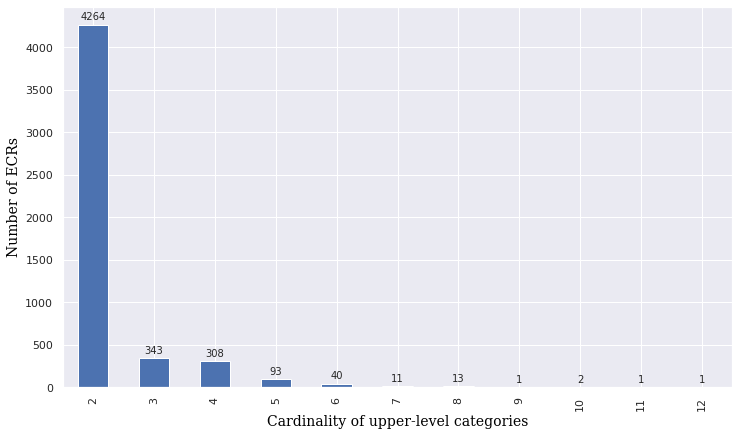

In [750]:
# plot the distribution of KG among Bündles (when Bundle's istzustand is not NULL)
plt.figure(figsize=(12,7))

ax = tmp_buendel_mk_kg_count['ECR_count'].plot(kind='bar')

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    #label = "{:.1f}".format(y_value)
    label=y_value

    # Create annotation
    plt.annotate(                     # Use `label` as label
        label,
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }


plt.xlabel("Cardinality of upper-level categories",fontdict=font)
plt.ylabel("Number of ECRs",fontdict=font)

plt.show()

In [757]:
copy_df_target = pd.DataFrame()
copy_df_target['Target'] = input_df_final_clean['Target'].copy()
copy_df_target['Target_count'] = copy_df_target['Target'].apply(lambda x: len(str(x).split(";")))

tmp_buendel_target_count = pd.DataFrame()
tmp_buendel_target_count['ECR_count'] = copy_df_target.groupby('Target_count').size()

In [758]:
copy_df_target

,Target,Target_count
0,MK_090;KG_62;MSK_09001;KGU_628,4
1,MK_090;KG_62;MSK_09001;KGU_621,4
2,MK_090;MK_091;MK_082;MK_021;KG_62;MSK_09101;MS...,12
3,MK_090;MK_093;KG_98;KG_62;MSK_09302;MSK_09001;...,8
4,MK_090;KG_62;MSK_09001;KGU_628,4
...,...,...
5447,MK_048;KG_86;MSK_04802;KGU_860,4
5448,MK_019;KG_86;MSK_01904;KGU_860,4
5449,MK_020;MK_079;MK_022;MK_025;MK_028;KG_68;KG_81...,20
5450,MK_022;KG_89;MSK_02208;KGU_890,4


In [759]:
tmp_buendel_target_count

,ECR_count
Target_count,
4,3252
5,741
6,355
7,166
8,232
9,95
10,61
11,46
12,50


In [760]:
copy_df_target['Target_count'].mean()

5.062044514477053

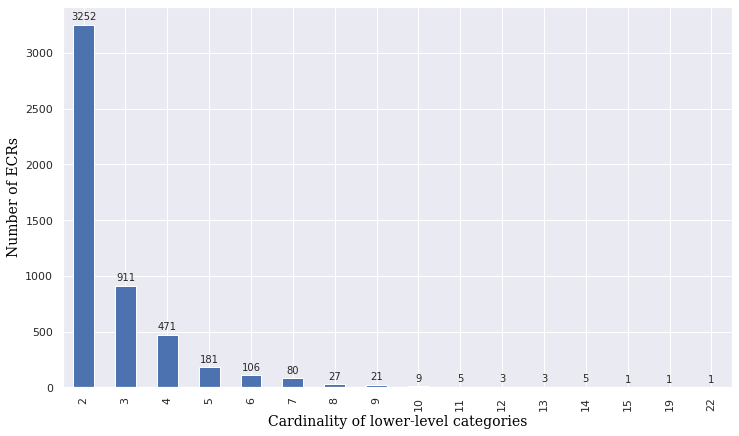

In [761]:
# plot the distribution of KG among Bündles (when Bundle's istzustand is not NULL)
plt.figure(figsize=(12,7))

ax = tmp_buendel_msk_kgu_count['ECR_count'].plot(kind='bar')

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    #label = "{:.1f}".format(y_value)
    label=y_value

    # Create annotation
    plt.annotate(                     # Use `label` as label
        label,
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }


plt.xlabel("Cardinality of lower-level categories",fontdict=font)
plt.ylabel("Number of ECRs",fontdict=font)

plt.show()

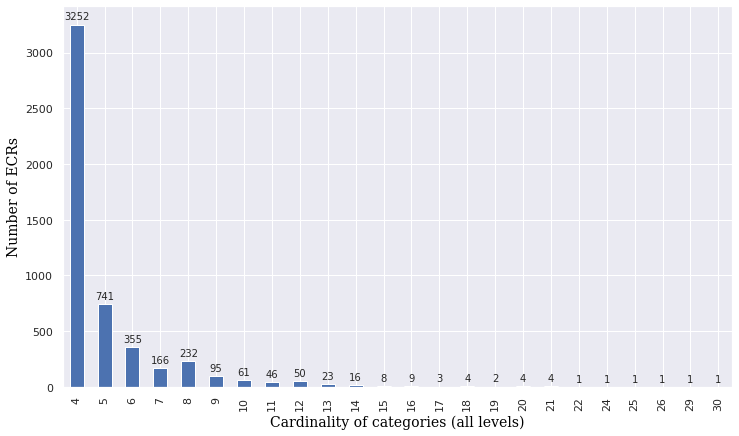

In [762]:
# plot the distribution of KG among Bündles (when Bundle's istzustand is not NULL)
plt.figure(figsize=(12,7))

ax = tmp_buendel_target_count['ECR_count'].plot(kind='bar')

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    #label = "{:.1f}".format(y_value)
    label=y_value

    # Create annotation
    plt.annotate(                     # Use `label` as label
        label,
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }


plt.xlabel("Cardinality of categories (all levels)",fontdict=font)
plt.ylabel("Number of ECRs",fontdict=font)

plt.show()

In [763]:
df_buendel_linked.groupby(['VERANTWORTLICHER_FK'])['SACHNUMMER'].nunique().sort_values(ascending=False).head(10)

VERANTWORTLICHER_FK
MESSEDO    1127
ACHINNU    1056
BRUECK      966
MARSTO1     875
ARMINJE     806
BRAENDL     766
KARADAT     685
MAIBAUM     624
TJKOERB     550
WITTMEV     537
Name: SACHNUMMER, dtype: int64

In [764]:
input_df_final_clean.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS',
       'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST', 'new_SOLL',
       'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
       'PROZESS_STATUS', 'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'MK_KG', 'MSK_KGU',
       'Target'],
      dtype='object')

In [765]:
df_buendel_mk.groupby(['MK'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

MK
MK_093    508
MK_035    425
MK_091    359
MK_027    332
MK_021    320
MK_054    219
MK_007    217
MK_033    210
MK_028    203
MK_022    200
MK_079    168
MK_024    155
MK_015    145
MK_053    141
MK_001    137
MK_004    132
MK_011    130
MK_092    126
MK_006    124
MK_020    122
MK_044     95
MK_017     84
MK_073     76
MK_025     75
MK_051     75
MK_097     63
MK_045     59
MK_046     58
MK_026     58
MK_094     56
MK_010     55
MK_036     54
MK_048     54
MK_019     53
MK_038     52
MK_043     45
MK_078     45
MK_023     45
MK_090     44
MK_039     39
MK_062     39
MK_082     39
MK_012     38
MK_030     35
MK_041     34
MK_061     34
MK_103     34
MK_064     32
MK_016     30
MK_081     26
MK_077     22
MK_058      8
Name: BUENDEL_NUMMER, dtype: int64

In [766]:
df_count_mk = pd.DataFrame()
df_count_mk['MK_count'] = df_buendel_mk.groupby(['MK'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False)

In [767]:
df_count_mk

,MK_count
MK,
MK_093,508
MK_035,425
MK_091,359
MK_027,332
MK_021,320
MK_054,219
MK_007,217
MK_033,210
MK_028,203


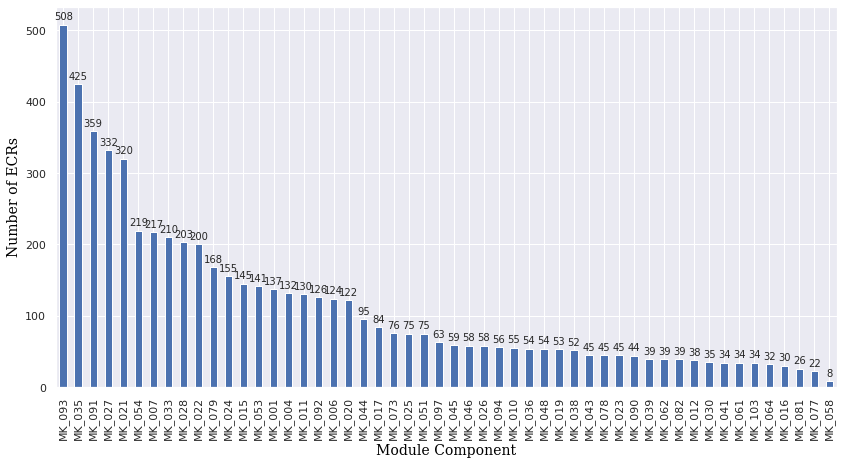

In [768]:
# plot the distribution of KG among Bündles (when Bundle's istzustand is not NULL)
plt.figure(figsize=(14,7))

ax = df_count_mk['MK_count'].plot(kind='bar')

rects = ax.patches

for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 3
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    #label = "{:.1f}".format(y_value)
    label=y_value

    # Create annotation
    plt.annotate(                     # Use `label` as label
        label,
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }


plt.xlabel("Module Component",fontdict=font)
plt.ylabel("Number of ECRs",fontdict=font)

plt.show()

In [769]:
df_buendel_mk['BUENDEL_NUMMER'].nunique()

5129

In [770]:
copy_df_target = pd.DataFrame()
copy_df_target['Target'] = input_df_final_clean['Target'].copy()
copy_df_target['Target_count'] = copy_df_target['Target'].apply(lambda x: len(str(x).split(" ")))

tmp_buendel_target_count = pd.DataFrame()
tmp_buendel_target_count['ECR_count'] = copy_df_target.groupby('Target_count').size()

In [771]:
df_buendel_linked.groupby(['VERANTWORTLICHER_FK'])['BUENDEL_NUMMER'].nunique().sort_values(ascending=False).head(10)

VERANTWORTLICHER_FK
WITTMEV    89
VHEGENE    82
MARSTO1    69
STEPKAT    66
BRIBITZ    63
OJARAMI    47
ACHINNU    47
RBERNHA    41
BRAENDL    39
DFEINAU    35
Name: BUENDEL_NUMMER, dtype: int64

In [772]:
df_buendel_linked.groupby('VERANTWORTLICHER_FK')['SACHNUMMER'].nunique().sort_values(ascending=False).mean()

40.58299180327869

In [773]:
df_buendel_linked.groupby(['BUENDEL_NUMMER'])['ZB_BENENNUNG'].nunique()

BUENDEL_NUMMER
0001809-001    25
0001937-001     1
0001974-001     8
0001988-001     2
0002002-001     2
               ..
0075248-001    30
0076215-001     2
0077420-001     2
0078485-001     5
0079014-001     1
Name: ZB_BENENNUNG, Length: 5129, dtype: int64

In [774]:
df_buendel_linked.groupby(['BUENDEL_NUMMER'])['SACHNUMMER'].nunique().mean()

10.140183271592903

In [775]:
input_df_final_clean.nunique()

BUENDEL_NUMMER                  5077
CREATION_DATE                   1028
RUECKMELDE_DATUM                1026
STATUS                             2
BENENNUNG                       2888
STICHWORT                       3907
VERURSACHER                       28
new_IST                         4294
new_SOLL                        4370
GEWUENSCHTER_EINSATZ              22
KOSTEN_RELEVANT                    3
ZERTIFIZIERUNGS_RELEVANT           3
PROZESS_STATUS                     1
VERANTWORTLICHER_FK              975
GREMIUM_ENTSCHEIDUNG_MANUELL      55
STATUS_GENEHMIGUNG                 2
RUECKSPRUNG_KOMMENTAR            725
KOSTENBEWERTUNGS_ART               3
BEGR_RUECKSPRUNG                 434
Bnd_MK                            95
Bnd_MK_BENENNUNG                  95
DAUER                            358
DAUER_KAT                          2
TypZahl                          545
MK                               295
MSK                              685
Bnd_KAT                           13
K

In [776]:
index_empty_zerti = input_df_final_clean.loc[input_df_final_clean['ZERTIFIZIERUNGS_RELEVANT']=='EMPTY'].index.tolist()
index_empty_zerti

[2396]

In [777]:
input_df_final_clean.drop(index_empty_zerti,inplace=True)

/home/yuwepan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [778]:
input_df_final_clean.loc[input_df_final_clean['ZERTIFIZIERUNGS_RELEVANT']=='EMPTY']

,BUENDEL_NUMMER,CREATION_DATE,RUECKMELDE_DATUM,STATUS,BENENNUNG,STICHWORT,VERURSACHER,new_IST,new_SOLL,GEWUENSCHTER_EINSATZ,...,KGU,cleaned_IST,cleaned_SOLL,cleaned_Stichwort,cleaned_Benennung,ANZAHL_SACHNUMMER,ANZAHL_ZB_BENENNUNG,MK_KG,MSK_KGU,Target


In [779]:
input_df_final_clean.columns

Index(['BUENDEL_NUMMER', 'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS',
       'BENENNUNG', 'STICHWORT', 'VERURSACHER', 'new_IST', 'new_SOLL',
       'GEWUENSCHTER_EINSATZ', 'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT',
       'PROZESS_STATUS', 'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'DAUER', 'DAUER_KAT',
       'TypZahl', 'MK', 'MSK', 'Bnd_KAT', 'KG', 'KGU', 'cleaned_IST',
       'cleaned_SOLL', 'cleaned_Stichwort', 'cleaned_Benennung',
       'ANZAHL_SACHNUMMER', 'ANZAHL_ZB_BENENNUNG', 'MK_KG', 'MSK_KGU',
       'Target'],
      dtype='object')

In [780]:
input_df_final_clean.nunique()

BUENDEL_NUMMER                  5076
CREATION_DATE                   1028
RUECKMELDE_DATUM                1026
STATUS                             2
BENENNUNG                       2887
STICHWORT                       3906
VERURSACHER                       28
new_IST                         4293
new_SOLL                        4369
GEWUENSCHTER_EINSATZ              22
KOSTEN_RELEVANT                    3
ZERTIFIZIERUNGS_RELEVANT           2
PROZESS_STATUS                     1
VERANTWORTLICHER_FK              975
GREMIUM_ENTSCHEIDUNG_MANUELL      55
STATUS_GENEHMIGUNG                 2
RUECKSPRUNG_KOMMENTAR            725
KOSTENBEWERTUNGS_ART               3
BEGR_RUECKSPRUNG                 434
Bnd_MK                            95
Bnd_MK_BENENNUNG                  95
DAUER                            358
DAUER_KAT                          2
TypZahl                          545
MK                               295
MSK                              685
Bnd_KAT                           13
K

In [781]:
input_df_final_clean.groupby(['GREMIUM_ENTSCHEIDUNG_MANUELL'])['BUENDEL_NUMMER'].nunique()

GREMIUM_ENTSCHEIDUNG_MANUELL
AK-BR205-A-C                        10
AK-BR205-W-S-V                     125
AK-BR206                             7
AK-BR213                            53
AK-BR222                             9
AK-BR253                            86
AK-D1789-M40-NPP                    11
AK-D2569                             2
AK-D2709-M16/M20-NPP                30
AK-D2769-M30/M35-SERIE               4
AK-D6079-M15-NPP                     1
AK-D6428-M30-NPP                     1
AK-D6519-M22-SERIE                   6
AK-D6549-M16/M20                    39
AK-D7250-GA5/GA7-NPP                 7
AK-D7530-GX-SERIE                    2
AK-D7532-G183-NPP                    1
AK-H068-LA1/LA2/LA3-SERIE            1
AMG BR-PRO/TECH                     37
AMG PT-SW-Tech                      25
AMG ÄK Sportmotor                    2
AMG-F02A-INNENAUSST-RUECKHALTES      1
AMG-Getriebe-Tech                    3
AMG-KT-F03A-E/E-HOCHVOLT-DERIV       1
AMG-KT-F05-FAHRW-RAEDER-REIFEN     

### Build Feature Extractor for text and categorial data

In [782]:
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
        

In [846]:
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        fh_ec_verursacher = FeatureHasher(n_features=30, input_type='string')
        fh_ec_mk = FeatureHasher(n_features=103, input_type='string')
        fh_verantwortlicher = FeatureHasher(n_features=1100, input_type='string')
        #fh_zerti = FeatureHasher(n_features=2, input_type='string')
        #fh_cost = FeatureHasher(n_features=2, input_type='string')
        #fh_grem = FeatureHasher(n_features=40, input_type='string')

        ec_verursacher_vectorizer = fh_ec_verursacher.transform(X['VERURSACHER'])       
        ec_mk_vectorizer = fh_ec_mk.transform(X['Bnd_MK_BENENNUNG'])
        verantwort_vectorizer = fh_verantwortlicher.transform(X['VERANTWORTLICHER_FK'])
        #zerti_vectorizer = fh_zerti.transform(X['ZERTIFIZIERUNGS_RELEVANT'])
        #cost_vectorizer = fh_cost.transform(X['KOSTEN_RELEVANT'])
        #grem_vectorizer = fh_grem.transform(X['GREMIUM_ENTSCHEIDUNG_MANUELL'])


        return np.hstack(((np.asmatrix(ec_verursacher_vectorizer.toarray())), 
                         (np.asmatrix(ec_mk_vectorizer.toarray())),
                         (np.asmatrix(verantwort_vectorizer.toarray())),
                         #(np.asmatrix(zerti_vectorizer.toarray())),
                         #(np.asmatrix(cost_vectorizer.toarray())),
                         #(np.asmatrix(grem_vectorizer.toarray()))
                         ))

In [784]:
# Create the tf-idf representation using the bag-of-words matrix
class TextBowTfidfTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self,field=None, min_df=None, stop_words=None):
        self.field = field
        self.min_df = min_df
        
    def fit(self, X, y=None):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        bow_transform = CountVectorizer(min_df=self.min_df, stop_words=stops)
        #bow_transform = CountVectorizer(min_df = self.min_df, stop_words=stops, ngram_range=(2,2))
        train_x_bow = bow_transform.fit_transform(train_x[str(self.field)])
        X_bow= bow_transform.transform(X[str(self.field)])
        
        tfidf_trfm = TfidfTransformer(norm=None)
        train_x_tfidf = tfidf_trfm.fit_transform(train_x_bow)
        X_tfidf = tfidf_trfm.transform(X_bow)
       
        return np.asmatrix(X_tfidf.toarray())

In [785]:
#Categrical features to pass down the categorical pipeline 
categorical_features = []
categorical_features = ['VERURSACHER', 'Bnd_MK_BENENNUNG','VERANTWORTLICHER_FK','ZERTIFIZIERUNGS_RELEVANT',
                        'KOSTEN_RELEVANT','GREMIUM_ENTSCHEIDUNG_MANUELL']


#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', SelectColumns(categorical_features) ),
                                           ( 'cat_transformer', CategoricalTransformer() ) ] )

In [786]:
#Tf-idf: 
text_pipeline = FeatureUnion(transformer_list=[ ('benennung_trans', TextBowTfidfTransformer(field='cleaned_Benennung', min_df=3)),
                                                ('stichwort_trans', TextBowTfidfTransformer(field='cleaned_Stichwort', min_df=3)),
                                                ('ist_trans', TextBowTfidfTransformer(field='cleaned_IST', min_df=2))])

In [787]:
# numeric features for predicting processing time of Bündel
numeric_features = []
numeric_features = ['ANZAHL_SACHNUMMER','ANZAHL_ZB_BENENNUNG']
numeric_pipeline = SelectColumns(numeric_features)

In [788]:
preprocessing_pipeline = FeatureUnion( transformer_list = [ ( 'cat_pip', categorical_pipeline), 
                                                            ( 'text_pip', text_pipeline)] )


preprocessing_pipeline_it = FeatureUnion( transformer_list = [ ( 'cat_pip', categorical_pipeline), 
                                                            ( 'text_pip', text_pipeline),
                                                            ('num_pip',numeric_pipeline)] )



#### (New)  preprocessing pipeline

In [849]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
# Categorical with low-to-moderate cardinality
MAX_OH_CARDINALITY = 45

def select_oh_features(df):
    
    oh_features =\
        df\
        .select_dtypes(['object', 'category'])\
        .apply(lambda col: col.nunique())\
        .loc[lambda x: x <= MAX_OH_CARDINALITY]\
        .index\
        .tolist()
        
    return oh_features

#remove_cat_features = ['STATUS']
oh_features = select_oh_features(input_df_final_clean)

oh_features.remove('STATUS')
oh_features.remove('PROZESS_STATUS')
oh_features.remove('STATUS_GENEHMIGUNG')
oh_features.remove('KOSTENBEWERTUNGS_ART')
#oh_features.remove('Bnd_MK')
oh_features.remove('DAUER_KAT')
oh_features.remove('Bnd_KAT')
oh_features.remove('ZERTIFIZIERUNGS_RELEVANT')
oh_features.remove('KOSTEN_RELEVANT')
oh_features.remove('VERURSACHER')

#oh_features.remove('GREMIUM_ENTSCHEIDUNG_MANUELL')

#oh_features.remove('WERKZEUGAENDERUNG_ERFORDERLICH')
oh_features.append('VERANTWORTLICHER_FK')
oh_features.append('Bnd_MK_BENENNUNG')

#oh_pipeline = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
oh_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

print(f'N oh_features: {len(oh_features)} \n')
print(', '.join(oh_features))

N oh_features: 2 

VERANTWORTLICHER_FK, Bnd_MK_BENENNUNG


In [790]:
import category_encoders as ce
#hc_features = ['VERANTWORTLICHER_FK', 'VERURSACHER', 'Bnd_MK_BENENNUNG', 'GREMIUM_ENTSCHEIDUNG_MANUELL']
hc_features = ['Bnd_MK_BENENNUNG']
hc_pipeline = make_pipeline(ce.TargetEncoder())
# hc_pipeline_verantwortlicher = make_pipeline(ce.HashingEncoder(n_components=1000))
# hc_pipeline_verursacher = make_pipeline(ce.HashingEncoder(n_components=30))
# hc_pipeline_mk = make_pipeline(ce.HashingEncoder(n_components=100))
# hc_pipeline_gre = make_pipeline(ce.HashingEncoder(n_components=40))


print(f'N hc_features: {len(hc_features)} \n')
print(', '.join(hc_features))

N hc_features: 1 

Bnd_MK_BENENNUNG


In [850]:
from sklearn.compose import ColumnTransformer
column_transformer =\
    ColumnTransformer(transformers=\
                          [('txt_ist_pipeline', TfidfVectorizer(min_df=2,stop_words=stops), 'cleaned_IST'),\
                           ('txt_benennung_pipeline', TfidfVectorizer(min_df=3,stop_words=stops), 'cleaned_Benennung'),\
                           ('txt_stichwort_pipeline', TfidfVectorizer (min_df=3, stop_words=stops), 'cleaned_Stichwort'),\
                            ('oh_pipeline', OneHotEncoder(handle_unknown='ignore'), oh_features)],\
                            #('hc_pipeline', ce.TargetEncoder(), hc_features)],\
                            n_jobs=-1,remainder='drop')

In [792]:
input_df_final_clean['DAUER_KAT'].describe()

count       5076
unique         2
top       Longer
freq        2817
Name: DAUER_KAT, dtype: object

In [793]:
tar_labels = []
tar_labels = [
        row['MK_KG'].split(";")
        for index,row in input_df_final_clean.iterrows()
        ]

In [794]:
tar_labels

[['MK_090', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_090', 'MK_091', 'MK_082', 'MK_021', 'KG_62'],
 ['MK_090', 'MK_093', 'KG_98', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_090', 'MK_082', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_082', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_090', 'MK_082', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_090', 'MK_082', 'KG_62'],
 ['MK_090', 'MK_082', 'KG_62'],
 ['MK_090', 'MK_093', 'KG_99', 'KG_62'],
 ['MK_082', 'KG_62'],
 ['MK_090', 'KG_62'],
 ['MK_093', 'KG_98'],
 ['MK_082', 'MK_024', 'KG_62'],
 ['MK_082', 'KG_62'],
 ['MK_097', 'KG_60'],
 ['MK_090', 'MK_082', 'KG_62'],
 ['MK_091', 'KG_63'],
 ['MK_093', 'KG_99'],
 ['MK_093', 'KG_99'],
 ['MK_093', 'KG_98'],
 ['MK_022', 'MK_028', 'KG_69'],
 ['MK_093', 'MK_097', 'KG_98', 'KG_60'],
 ['MK_093', 'MK_097', 'KG_98', 'KG_60', 'KG_99'],
 ['MK_093', 'KG_98'],
 ['MK_093', 'KG_99'],
 ['MK_093', 'MK_082', 'KG_99', 'KG_62'],
 ['MK_093', 'KG_99'],
 ['MK_093', 'KG_98'],
 ['MK_093', 'KG_99'],
 ['MK_093', 'KG_98'],
 ['M

In [795]:
df_mk.loc[df_mk['MK_BENENNUNG'].str.contains('Motorlager/Getriebelager')]

,MK,MK_BENENNUNG
77,078,Motorlager/Getriebelager


In [796]:
from sklearn.preprocessing import MultiLabelBinarizer

y = []    
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tar_labels)

In [797]:
y.shape

(5076, 91)

In [798]:
mlb.classes_

array(['KG_01', 'KG_09', 'KG_24', 'KG_27', 'KG_32', 'KG_34', 'KG_35',
       'KG_40', 'KG_42', 'KG_46', 'KG_47', 'KG_49', 'KG_50', 'KG_54',
       'KG_58', 'KG_60', 'KG_62', 'KG_63', 'KG_65', 'KG_67', 'KG_68',
       'KG_69', 'KG_72', 'KG_73', 'KG_74', 'KG_75', 'KG_78', 'KG_81',
       'KG_82', 'KG_83', 'KG_86', 'KG_88', 'KG_89', 'KG_90', 'KG_91',
       'KG_92', 'KG_97', 'KG_98', 'KG_99', 'MK_001', 'MK_004', 'MK_006',
       'MK_007', 'MK_010', 'MK_011', 'MK_012', 'MK_015', 'MK_016',
       'MK_017', 'MK_019', 'MK_020', 'MK_021', 'MK_022', 'MK_023',
       'MK_024', 'MK_025', 'MK_026', 'MK_027', 'MK_028', 'MK_030',
       'MK_033', 'MK_035', 'MK_036', 'MK_038', 'MK_039', 'MK_041',
       'MK_043', 'MK_044', 'MK_045', 'MK_046', 'MK_048', 'MK_051',
       'MK_053', 'MK_054', 'MK_058', 'MK_061', 'MK_062', 'MK_064',
       'MK_073', 'MK_077', 'MK_078', 'MK_079', 'MK_081', 'MK_082',
       'MK_090', 'MK_091', 'MK_092', 'MK_093', 'MK_094', 'MK_097',
       'MK_103'], dtype=object)

In [799]:
df_x = pd.DataFrame(input_df_final_clean.copy())

In [800]:
# df_x['Bnd_MK_BENENNUNG'] = df_x['Bnd_MK_BENENNUNG'].astype('str')
# df_x['VERURSACHER'] = df_x['VERURSACHER'].astype('str')
# df_x['ZERTIFIZIERUNGS_RELEVANT'] = df_x['ZERTIFIZIERUNGS_RELEVANT'].astype('str')
# df_x['GREMIUM_ENTSCHEIDUNG_MANUELL'] = df_x['GREMIUM_ENTSCHEIDUNG_MANUELL'].astype('str')

df_x['cleaned_IST'] = df_x['cleaned_IST'].astype('str')
df_x['cleaned_Benennung'] = df_x['cleaned_Benennung'].astype('str')
df_x['cleaned_Stichwort'] = df_x['cleaned_Stichwort'].astype('str')

df_x['VERURSACHER'] = df_x['VERURSACHER'].fillna('None')
df_x['VERURSACHER'] = df_x['VERURSACHER'].astype('category')

df_x['KOSTEN_RELEVANT'] = df_x['KOSTEN_RELEVANT'].fillna('None')
df_x['KOSTEN_RELEVANT'] = df_x['KOSTEN_RELEVANT'].astype('category')

df_x['ZERTIFIZIERUNGS_RELEVANT'] = df_x['ZERTIFIZIERUNGS_RELEVANT'].fillna('None')
df_x['ZERTIFIZIERUNGS_RELEVANT'] = df_x['ZERTIFIZIERUNGS_RELEVANT'].astype('category')
#df_x['GREMIUM_ENTSCHEIDUNG_MANUELL'] = df_x['GREMIUM_ENTSCHEIDUNG_MANUELL'].astype('category')
df_x['Bnd_MK_BENENNUNG'] = df_x['Bnd_MK_BENENNUNG'].fillna('None')
df_x['Bnd_MK_BENENNUNG'] = df_x['Bnd_MK_BENENNUNG'].astype('category')
# df_x['EMISSIONSKENNZEICHEN'] = df_x['EMISSIONSKENNZEICHEN'].astype('category')
# df_x['BESCHAFFUNGSART'] = df_x['BESCHAFFUNGSART'].astype('category')
# df_x['SICHERHEITSRELEVANT'] = df_x['SICHERHEITSRELEVANT'].astype('category')
# df_x['TEILEART'] = df_x['TEILEART'].astype('category')
# df_x['WERKZEUGAENDERUNG_ERFORDERLICH'] = df_x['WERKZEUGAENDERUNG_ERFORDERLICH'].astype('category')
# df_x['EE_STEUERGERAET_BETROFFEN'] = df_x['EE_STEUERGERAET_BETROFFEN'].astype('category')
# df_x['BETRIEBSANLEITUNG_BETROFFEN'] = df_x['BETRIEBSANLEITUNG_BETROFFEN'].astype('category')
# df_x['LEITUNGSSATZ_BETROFFEN'] = df_x['LEITUNGSSATZ_BETROFFEN'].astype('category')
# df_x['LASTENHEFTAENDERUNG_ERFORDERLICH'] = df_x['LASTENHEFTAENDERUNG_ERFORDERLICH'].astype('category')
# df_x['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'] = df_x['VERSUCHSTEIL_ASACHNUMMER_BETROFFEN'].astype('category')
# df_x['DAUER_KAT_num'] = df_x['DAUER_KAT'].astype('category').cat.codes
df_x['MK_KG_num'] = df_x['MK_KG'].astype('category').cat.codes

In [801]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in msss.split(df_x, y):
    print("TRAIN:", train_index, "TEST:", test_index)

/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass test_size=0.2, train_size=None, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


TRAIN: [   0    1    2 ... 5073 5074 5075] TEST: [  15   20   22 ... 5056 5060 5067]
TRAIN: [   0    1    2 ... 5072 5074 5075] TEST: [   3    9   11 ... 5062 5065 5073]


In [223]:
np.savetxt("train_index_c_20201224.csv", train_index, delimiter=",")
np.savetxt("test_index_c_20201224.csv", test_index, delimiter=",")

In [224]:
# train_index = np.loadtxt("train_index_ab_20200915.csv", dtype='i', delimiter=',')
# test_index =  np.loadtxt("test_index_ab_20200915.csv", dtype='i', delimiter=',')

In [802]:
train_x, test_x = df_x.iloc[train_index], df_x.iloc[test_index]
train_y, test_y = y[train_index], y[test_index]

In [803]:
test_y.shape

(1016, 91)

In [840]:
train_y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [230]:
# cat_train = categorical_pipeline.fit_transform(train_x)
# cat_train

In [844]:
df_x.dtypes

BUENDEL_NUMMER                           object
CREATION_DATE                            object
RUECKMELDE_DATUM                         object
STATUS                                   object
BENENNUNG                                object
STICHWORT                                object
VERURSACHER                            category
new_IST                                  object
new_SOLL                                 object
GEWUENSCHTER_EINSATZ             datetime64[ns]
KOSTEN_RELEVANT                        category
ZERTIFIZIERUNGS_RELEVANT               category
PROZESS_STATUS                           object
VERANTWORTLICHER_FK                      object
GREMIUM_ENTSCHEIDUNG_MANUELL             object
STATUS_GENEHMIGUNG                       object
RUECKSPRUNG_KOMMENTAR                    object
KOSTENBEWERTUNGS_ART                     object
BEGR_RUECKSPRUNG                         object
Bnd_MK                                   object
Bnd_MK_BENENNUNG                       c

### Multilabel Classification

In [804]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from tqdm import tqdm_notebook as tqdm

In [805]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

### Label Community Detection

In [806]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster import NetworkXLabelGraphClusterer

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

In [807]:
graph_builder.transform(train_y)

{(16, 84): 34.0,
 (16, 51): 6.0,
 (16, 83): 31.0,
 (51, 83): 5.0,
 (51, 84): 2.0,
 (83, 84): 9.0,
 (16, 85): 2.0,
 (51, 85): 1.0,
 (83, 85): 2.0,
 (84, 85): 1.0,
 (16, 38): 7.0,
 (38, 84): 4.0,
 (16, 87): 10.0,
 (38, 87): 303.0,
 (84, 87): 4.0,
 (37, 87): 73.0,
 (16, 54): 3.0,
 (54, 83): 3.0,
 (15, 89): 50.0,
 (15, 37): 6.0,
 (15, 87): 7.0,
 (37, 89): 6.0,
 (87, 89): 7.0,
 (15, 38): 3.0,
 (37, 38): 24.0,
 (38, 89): 3.0,
 (38, 83): 4.0,
 (83, 87): 6.0,
 (17, 85): 240.0,
 (7, 71): 56.0,
 (14, 52): 31.0,
 (13, 61): 292.0,
 (33, 73): 169.0,
 (33, 66): 35.0,
 (31, 44): 90.0,
 (33, 67): 61.0,
 (33, 64): 19.0,
 (64, 67): 5.0,
 (28, 33): 18.0,
 (28, 67): 14.0,
 (31, 87): 8.0,
 (44, 87): 12.0,
 (15, 17): 6.0,
 (15, 85): 9.0,
 (17, 89): 6.0,
 (85, 89): 9.0,
 (18, 85): 45.0,
 (15, 18): 5.0,
 (18, 89): 5.0,
 (17, 20): 12.0,
 (17, 81): 12.0,
 (20, 81): 112.0,
 (20, 85): 13.0,
 (81, 85): 12.0,
 (17, 25): 4.0,
 (25, 85): 11.0,
 (21, 58): 117.0,
 (17, 31): 1.0,
 (17, 44): 1.0,
 (31, 85): 4.0,
 (44, 85

In [808]:
# display as graph
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

nlabel = train_y.shape[1]
label_names = mlb.classes_.copy()
edge_map = graph_builder.transform(train_y)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))


91 labels, 880 edges


In [809]:
print(edge_map)

{(16, 84): 34.0, (16, 51): 6.0, (16, 83): 31.0, (51, 83): 5.0, (51, 84): 2.0, (83, 84): 9.0, (16, 85): 2.0, (51, 85): 1.0, (83, 85): 2.0, (84, 85): 1.0, (16, 38): 7.0, (38, 84): 4.0, (16, 87): 10.0, (38, 87): 303.0, (84, 87): 4.0, (37, 87): 73.0, (16, 54): 3.0, (54, 83): 3.0, (15, 89): 50.0, (15, 37): 6.0, (15, 87): 7.0, (37, 89): 6.0, (87, 89): 7.0, (15, 38): 3.0, (37, 38): 24.0, (38, 89): 3.0, (38, 83): 4.0, (83, 87): 6.0, (17, 85): 240.0, (7, 71): 56.0, (14, 52): 31.0, (13, 61): 292.0, (33, 73): 169.0, (33, 66): 35.0, (31, 44): 90.0, (33, 67): 61.0, (33, 64): 19.0, (64, 67): 5.0, (28, 33): 18.0, (28, 67): 14.0, (31, 87): 8.0, (44, 87): 12.0, (15, 17): 6.0, (15, 85): 9.0, (17, 89): 6.0, (85, 89): 9.0, (18, 85): 45.0, (15, 18): 5.0, (18, 89): 5.0, (17, 20): 12.0, (17, 81): 12.0, (20, 81): 112.0, (20, 85): 13.0, (81, 85): 12.0, (17, 25): 4.0, (25, 85): 11.0, (21, 58): 117.0, (17, 31): 1.0, (17, 44): 1.0, (31, 85): 4.0, (44, 85): 4.0, (17, 18): 15.0, (17, 37): 5.0, (18, 37): 3.0, (37, 8

In [810]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

# setup the clusterer to use, we selected the fast greedy modularity-maximization approach
clusterer_ig = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='fastgreedy')
partition_ig = clusterer_ig.fit_predict(train_x, train_y)

In [811]:
mlb.classes_[71]

'MK_051'

In [812]:
partition_ig

array([list([0, 1, 12, 16, 29, 42, 54, 78, 83, 84]), list([2, 80]),
       list([3, 11, 31, 44, 72, 88, 90]),
       list([4, 6, 68, 69, 74, 75, 77]),
       list([5, 33, 39, 56, 59, 60, 62, 63, 64, 66, 67, 73, 76]),
       list([7, 71]), list([8, 65]), list([9, 30, 49, 53, 70]),
       list([10, 15, 17, 18, 25, 37, 38, 41, 47, 79, 82, 85, 87, 89]),
       list([13, 28, 61]),
       list([14, 20, 21, 27, 32, 48, 50, 51, 52, 55, 58, 81]),
       list([19, 22, 23, 24, 40, 45, 46, 86]), list([26, 43]),
       list([34, 35, 36, 57])], dtype=object)

In [813]:
len(partition_ig)

14

In [814]:
# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }


In [815]:
label_names

array(['KG_01', 'KG_09', 'KG_24', 'KG_27', 'KG_32', 'KG_34', 'KG_35',
       'KG_40', 'KG_42', 'KG_46', 'KG_47', 'KG_49', 'KG_50', 'KG_54',
       'KG_58', 'KG_60', 'KG_62', 'KG_63', 'KG_65', 'KG_67', 'KG_68',
       'KG_69', 'KG_72', 'KG_73', 'KG_74', 'KG_75', 'KG_78', 'KG_81',
       'KG_82', 'KG_83', 'KG_86', 'KG_88', 'KG_89', 'KG_90', 'KG_91',
       'KG_92', 'KG_97', 'KG_98', 'KG_99', 'MK_001', 'MK_004', 'MK_006',
       'MK_007', 'MK_010', 'MK_011', 'MK_012', 'MK_015', 'MK_016',
       'MK_017', 'MK_019', 'MK_020', 'MK_021', 'MK_022', 'MK_023',
       'MK_024', 'MK_025', 'MK_026', 'MK_027', 'MK_028', 'MK_030',
       'MK_033', 'MK_035', 'MK_036', 'MK_038', 'MK_039', 'MK_041',
       'MK_043', 'MK_044', 'MK_045', 'MK_046', 'MK_048', 'MK_051',
       'MK_053', 'MK_054', 'MK_058', 'MK_061', 'MK_062', 'MK_064',
       'MK_073', 'MK_077', 'MK_078', 'MK_079', 'MK_081', 'MK_082',
       'MK_090', 'MK_091', 'MK_092', 'MK_093', 'MK_094', 'MK_097',
       'MK_103'], dtype=object)

In [816]:
mlb.classes_

array(['KG_01', 'KG_09', 'KG_24', 'KG_27', 'KG_32', 'KG_34', 'KG_35',
       'KG_40', 'KG_42', 'KG_46', 'KG_47', 'KG_49', 'KG_50', 'KG_54',
       'KG_58', 'KG_60', 'KG_62', 'KG_63', 'KG_65', 'KG_67', 'KG_68',
       'KG_69', 'KG_72', 'KG_73', 'KG_74', 'KG_75', 'KG_78', 'KG_81',
       'KG_82', 'KG_83', 'KG_86', 'KG_88', 'KG_89', 'KG_90', 'KG_91',
       'KG_92', 'KG_97', 'KG_98', 'KG_99', 'MK_001', 'MK_004', 'MK_006',
       'MK_007', 'MK_010', 'MK_011', 'MK_012', 'MK_015', 'MK_016',
       'MK_017', 'MK_019', 'MK_020', 'MK_021', 'MK_022', 'MK_023',
       'MK_024', 'MK_025', 'MK_026', 'MK_027', 'MK_028', 'MK_030',
       'MK_033', 'MK_035', 'MK_036', 'MK_038', 'MK_039', 'MK_041',
       'MK_043', 'MK_044', 'MK_045', 'MK_046', 'MK_048', 'MK_051',
       'MK_053', 'MK_054', 'MK_058', 'MK_061', 'MK_062', 'MK_064',
       'MK_073', 'MK_077', 'MK_078', 'MK_079', 'MK_081', 'MK_082',
       'MK_090', 'MK_091', 'MK_092', 'MK_093', 'MK_094', 'MK_097',
       'MK_103'], dtype=object)

In [817]:
df_buendel_linked[['MK','MK_BENENNUNG']]

,MK,MK_BENENNUNG
0,MK_090,Vorbau
1,MK_090,Vorbau
2,MK_090,Vorbau
3,MK_090,Vorbau
4,MK_090,Vorbau
...,...,...
62417,MK_016,Verdecksysteme
62418,MK_016,Verdecksysteme
62419,MK_016,Verdecksysteme
62420,MK_016,Verdecksysteme


In [841]:
df_buendel_linked.columns

Index(['BUENDEL_NUMMER', 'SACHNUMMER', 'ZB_BENENNUNG', 'MODULGRUPPE',
       'Kennbuchstabe', 'MSK', 'MK', 'SUBK', 'TypZahl', 'KG', 'U', 'KGU',
       'Fortlaufende_Nummer', 'Teilnummer_Untergruppe', 'Bnd_ID',
       'CREATION_DATE', 'RUECKMELDE_DATUM', 'STATUS', 'BENENNUNG', 'STICHWORT',
       'VERURSACHER', 'new_IST', 'new_SOLL', 'GEWUENSCHTER_EINSATZ',
       'KOSTEN_RELEVANT', 'ZERTIFIZIERUNGS_RELEVANT', 'PROZESS_STATUS',
       'VERANTWORTLICHER_FK', 'GREMIUM_ENTSCHEIDUNG_MANUELL',
       'STATUS_GENEHMIGUNG', 'RUECKSPRUNG_KOMMENTAR', 'KOSTENBEWERTUNGS_ART',
       'BEGR_RUECKSPRUNG', 'Bnd_MK', 'Bnd_MK_BENENNUNG', 'ProduktKlasse',
       'word_count_benennung', 'word_count_stichwort', 'word_count_rueck',
       'word_count_berg_rueck', 'word_count_ist', 'word_count_soll', 'Bnd_KAT',
       'DAUER', 'DAUER_KAT', 'MK_BENENNUNG'],
      dtype='object')

In [819]:
for i,element in enumerate(label_names):
    label_names[i] = label_names[i].replace('KG_01','KG_Motorgehäuse') 
    label_names[i] = label_names[i].replace('KG_09','KG_Kraftstoffförder- / Ladepumpe') 
    label_names[i] = label_names[i].replace('KG_24','KG_Motor- / Aggregateaufhängung im Fahrgestell')
    label_names[i] = label_names[i].replace('KG_27','KG_Automat. / Hydr. Getriebe')
    
    label_names[i] = label_names[i].replace('KG_32','KG_Federn und Federaufhängung')
    label_names[i] = label_names[i].replace('KG_33','KG_Vorderachse')
    
    label_names[i] = label_names[i].replace('KG_34','KG_Altern. Antriebe/ Energieumw.')
    label_names[i] = label_names[i].replace('KG_35','KG_Hinterachse')
    label_names[i] = label_names[i].replace('KG_40','KG_Räder und Bereifung')
    label_names[i] = label_names[i].replace('KG_41','KG_Gelenkwelle / Achsantrieb')
    label_names[i] = label_names[i].replace('KG_42','KG_Bremse')
    label_names[i] = label_names[i].replace('KG_46','KG_Lenkung')
    label_names[i] = label_names[i].replace('KG_47','KG_Kraftstoffanlage')
    label_names[i] = label_names[i].replace('KG_49','KG_Abgas- / Abluftanlage')
    label_names[i] = label_names[i].replace('KG_50','KG_Kühler / Wärmetauscher')
    label_names[i] = label_names[i].replace('KG_52','KG_Fahrgestellanbauteile')
    label_names[i] = label_names[i].replace('KG_54','KG_Elektr. Ausrüstung Fahrgestell')
    label_names[i] = label_names[i].replace('KG_58','KG_Werkzeug und Zubehör')
    label_names[i] = label_names[i].replace('KG_60','kG_Aufbau')
    label_names[i] = label_names[i].replace('KG_61','KG_Unterbau')
    label_names[i] = label_names[i].replace('KG_62','KG_Vorderwand')
    label_names[i] = label_names[i].replace('KG_63','KG_Seitenwände')
    label_names[i] = label_names[i].replace('KG_64','KG_Rückwand, Heck')
    label_names[i] = label_names[i].replace('KG_65','KG_Dach')
    label_names[i] = label_names[i].replace('KG_67','KG_Fensteranlage')
    label_names[i] = label_names[i].replace('KG_68','KG_Verkleidung_A')
    label_names[i] = label_names[i].replace('KG_69','KG_Verkleidung_B')
    label_names[i] = label_names[i].replace('KG_72','KG_Seitentür vorn')
    label_names[i] = label_names[i].replace('KG_73','KG_Seitentür hinten, Mitteltür')
    label_names[i] = label_names[i].replace('KG_74','KG_Rückwandtür')
    label_names[i] = label_names[i].replace('KG_75','KG_Aussenklappen')
    label_names[i] = label_names[i].replace('KG_77','KG_Verdeck')
  
    label_names[i] = label_names[i].replace('KG_78','KG_Dachsysteme')
    label_names[i] = label_names[i].replace('KG_79','KG_Aufsätze, Spriegelk., Klappdach')
    
    label_names[i] = label_names[i].replace('KG_81','KG_Ausstattung, Inneneinrichtung')
    label_names[i] = label_names[i].replace('KG_82','KG_Elektrische Anlage')
    label_names[i] = label_names[i].replace('KG_83','KG_Lüftung, Heizung, Klimatisierung')
    label_names[i] = label_names[i].replace('KG_86','KG_Sicherheitssys. Notger. San.Ausr.')
    label_names[i] = label_names[i].replace('KG_88','KG_Kotflügel, Motorhaube, Stoßfänger usw')
    label_names[i] = label_names[i].replace('KG_89','KG_Sondereinb., Fahrzg.-Zub.')
    
    label_names[i] = label_names[i].replace('KG_90','KG_Elektrik- / Elektronik-Komponenten (Pkw)')
    label_names[i] = label_names[i].replace('KG_91','KG_Vordersitze, Fahrersitz')
    label_names[i] = label_names[i].replace('KG_92','KG_Rücksitz, Sitzbank')
    label_names[i] = label_names[i].replace('KG_97','KG_Sitzzubehör, Liege')
    label_names[i] = label_names[i].replace('KG_98','KG_Allgemein / KG übergreifende Teile')
    label_names[i] = label_names[i].replace('KG_99','KG_Normähnliche Teile')

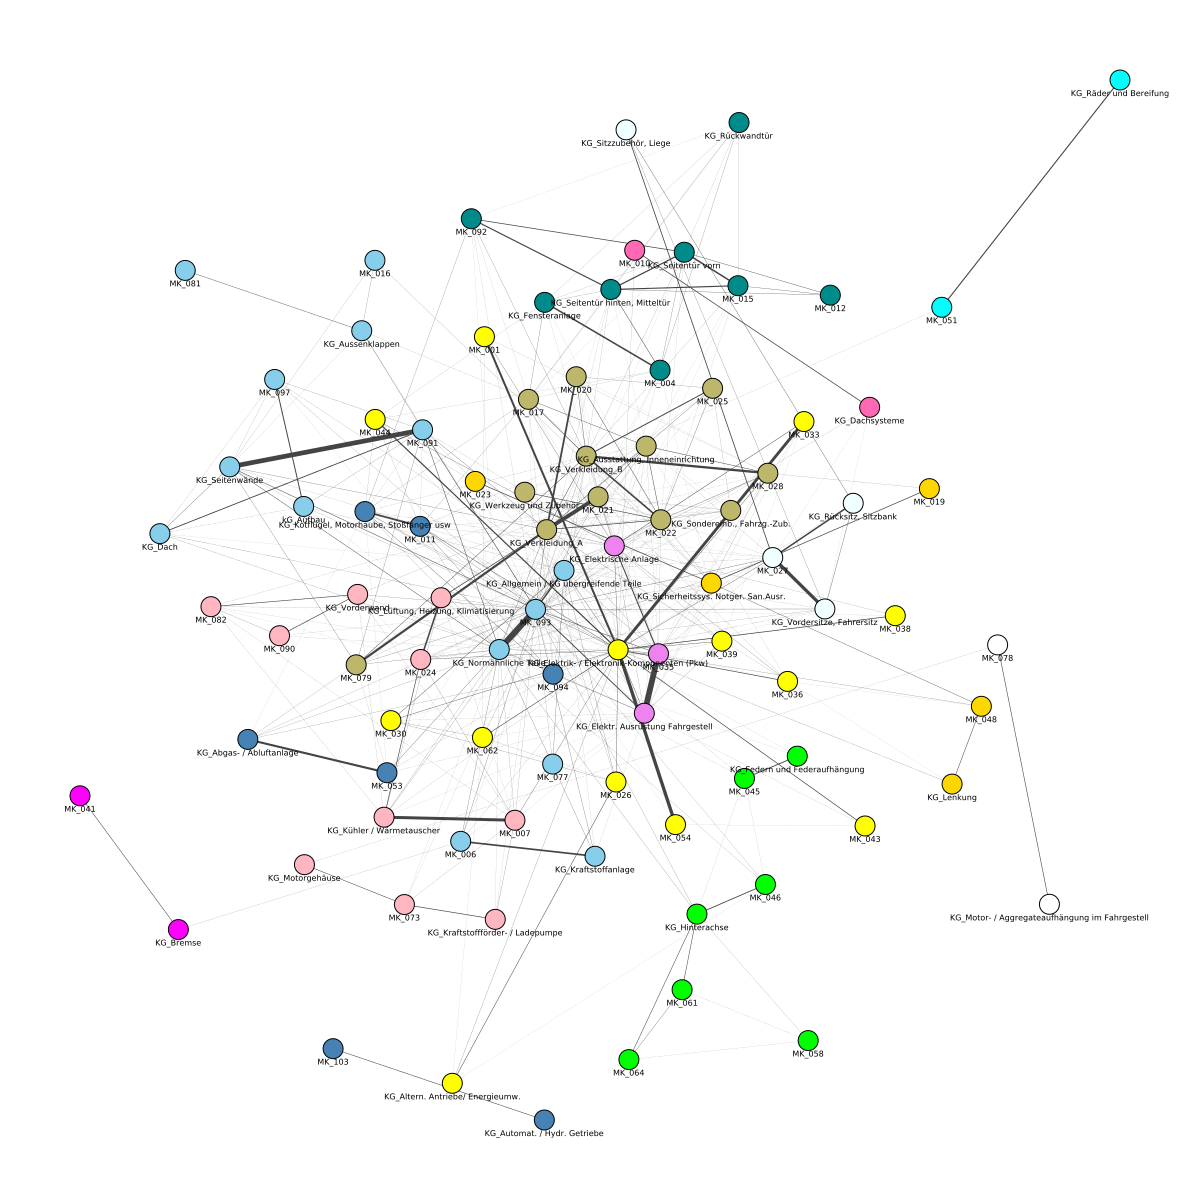

In [820]:
colors = ['lightpink', 'white', 'steelblue','green','yellow','cyan','magenta','gold','skyblue','violet','darkkhaki','darkcyan','hotpink','azure']
membership_vector = to_membership_vector(partition_ig)
visual_style = {
    "vertex_size" : 20,
    "vertex_label": [x for x in label_names],
    "vertex_label_size": 8,
    "vertex_label_dist": 1,
    "edge_width" : [80*x/train_y.shape[0] for x in clusterer_ig.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(train_y.shape[1])],
    "bbox": (1200,1200),
    "margin": 80,
    #"layout": clusterer_ig.graph_.layout_drl()
    "layout": 'large'

}

ig.plot(clusterer_ig.graph_, **visual_style)

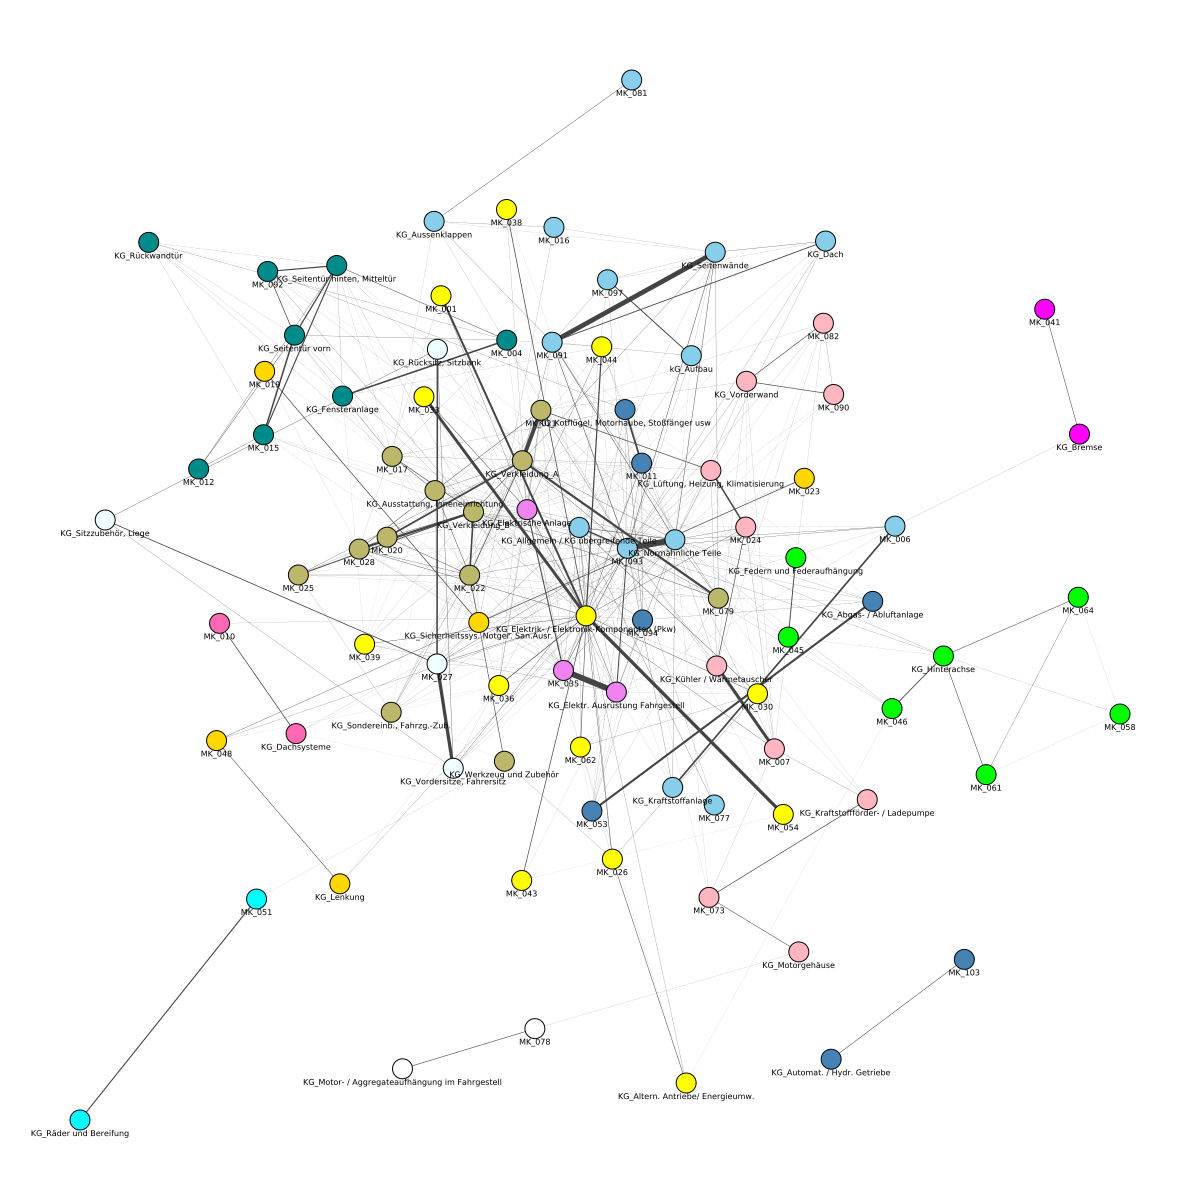

In [821]:
ig.plot(clusterer_ig.graph_, "community_ab.pdf", **visual_style)

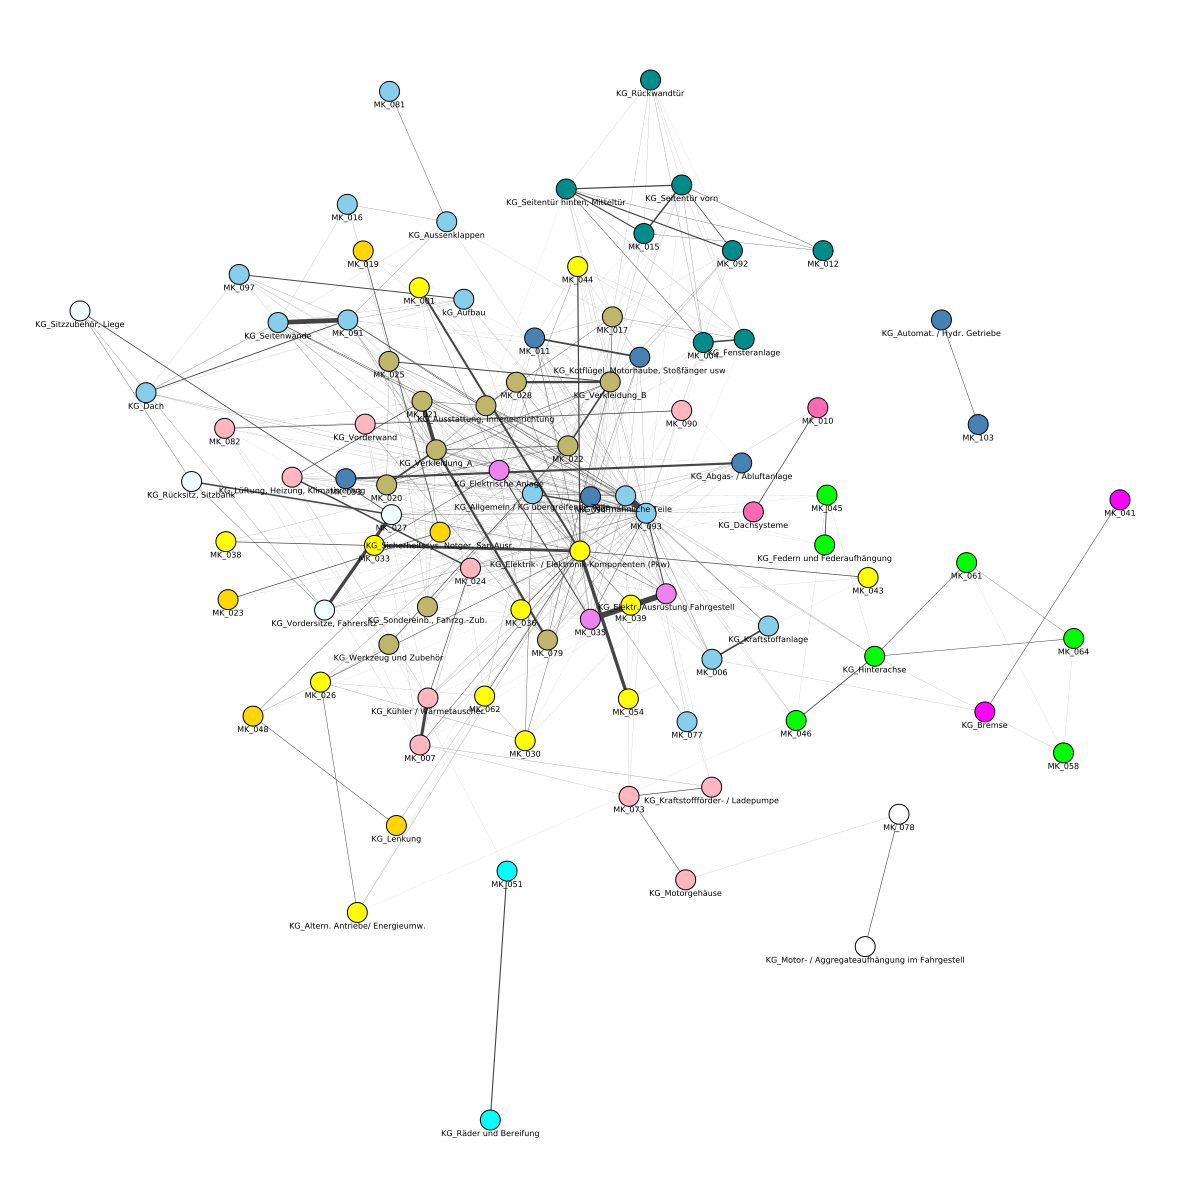

In [822]:
ig.plot(clusterer_ig.graph_, "community_ab.png", **visual_style)

In [823]:
membership_vector

{0: 0,
 1: 0,
 12: 0,
 16: 0,
 29: 0,
 42: 0,
 54: 0,
 78: 0,
 83: 0,
 84: 0,
 2: 1,
 80: 1,
 3: 2,
 11: 2,
 31: 2,
 44: 2,
 72: 2,
 88: 2,
 90: 2,
 4: 3,
 6: 3,
 68: 3,
 69: 3,
 74: 3,
 75: 3,
 77: 3,
 5: 4,
 33: 4,
 39: 4,
 56: 4,
 59: 4,
 60: 4,
 62: 4,
 63: 4,
 64: 4,
 66: 4,
 67: 4,
 73: 4,
 76: 4,
 7: 5,
 71: 5,
 8: 6,
 65: 6,
 9: 7,
 30: 7,
 49: 7,
 53: 7,
 70: 7,
 10: 8,
 15: 8,
 17: 8,
 18: 8,
 25: 8,
 37: 8,
 38: 8,
 41: 8,
 47: 8,
 79: 8,
 82: 8,
 85: 8,
 87: 8,
 89: 8,
 13: 9,
 28: 9,
 61: 9,
 14: 10,
 20: 10,
 21: 10,
 27: 10,
 32: 10,
 48: 10,
 50: 10,
 51: 10,
 52: 10,
 55: 10,
 58: 10,
 81: 10,
 19: 11,
 22: 11,
 23: 11,
 24: 11,
 40: 11,
 45: 11,
 46: 11,
 86: 11,
 26: 12,
 43: 12,
 34: 13,
 35: 13,
 36: 13,
 57: 13}

In [824]:
membership_vector[6]

3

In [825]:
dict_community_label = dict(enumerate(label_names))

In [826]:
dict_community_label

{0: 'KG_Motorgehäuse',
 1: 'KG_Kraftstoffförder- / Ladepumpe',
 2: 'KG_Motor- / Aggregateaufhängung im Fahrgestell',
 3: 'KG_Automat. / Hydr. Getriebe',
 4: 'KG_Federn und Federaufhängung',
 5: 'KG_Altern. Antriebe/ Energieumw.',
 6: 'KG_Hinterachse',
 7: 'KG_Räder und Bereifung',
 8: 'KG_Bremse',
 9: 'KG_Lenkung',
 10: 'KG_Kraftstoffanlage',
 11: 'KG_Abgas- / Abluftanlage',
 12: 'KG_Kühler / Wärmetauscher',
 13: 'KG_Elektr. Ausrüstung Fahrgestell',
 14: 'KG_Werkzeug und Zubehör',
 15: 'kG_Aufbau',
 16: 'KG_Vorderwand',
 17: 'KG_Seitenwände',
 18: 'KG_Dach',
 19: 'KG_Fensteranlage',
 20: 'KG_Verkleidung_A',
 21: 'KG_Verkleidung_B',
 22: 'KG_Seitentür vorn',
 23: 'KG_Seitentür hinten, Mitteltür',
 24: 'KG_Rückwandtür',
 25: 'KG_Aussenklappen',
 26: 'KG_Dachsysteme',
 27: 'KG_Ausstattung, Inneneinrichtung',
 28: 'KG_Elektrische Anlage',
 29: 'KG_Lüftung, Heizung, Klimatisierung',
 30: 'KG_Sicherheitssys. Notger. San.Ausr.',
 31: 'KG_Kotflügel, Motorhaube, Stoßfänger usw',
 32: 'KG_Sonder

In [827]:
dict_membership_vector = dict((dict_community_label[key], value) for (key, value) in membership_vector.items())
dict_membership_vector

{'KG_Motorgehäuse': 0,
 'KG_Kraftstoffförder- / Ladepumpe': 0,
 'KG_Kühler / Wärmetauscher': 0,
 'KG_Vorderwand': 0,
 'KG_Lüftung, Heizung, Klimatisierung': 0,
 'MK_007': 0,
 'MK_024': 0,
 'MK_073': 0,
 'MK_082': 0,
 'MK_090': 0,
 'KG_Motor- / Aggregateaufhängung im Fahrgestell': 1,
 'MK_078': 1,
 'KG_Automat. / Hydr. Getriebe': 2,
 'KG_Abgas- / Abluftanlage': 2,
 'KG_Kotflügel, Motorhaube, Stoßfänger usw': 2,
 'MK_011': 2,
 'MK_053': 2,
 'MK_094': 2,
 'MK_103': 2,
 'KG_Federn und Federaufhängung': 3,
 'KG_Hinterachse': 3,
 'MK_045': 3,
 'MK_046': 3,
 'MK_058': 3,
 'MK_061': 3,
 'MK_064': 3,
 'KG_Altern. Antriebe/ Energieumw.': 4,
 'KG_Elektrik- / Elektronik-Komponenten (Pkw)': 4,
 'MK_001': 4,
 'MK_026': 4,
 'MK_030': 4,
 'MK_033': 4,
 'MK_036': 4,
 'MK_038': 4,
 'MK_039': 4,
 'MK_043': 4,
 'MK_044': 4,
 'MK_054': 4,
 'MK_062': 4,
 'KG_Räder und Bereifung': 5,
 'MK_051': 5,
 'KG_Bremse': 6,
 'MK_041': 6,
 'KG_Lenkung': 7,
 'KG_Sicherheitssys. Notger. San.Ausr.': 7,
 'MK_019': 7,
 'MK_

In [828]:
# test_txt_pre = text_pipeline.fit_transform(test_x)
# test_txt_pre.shape

In [829]:
txt_pre = text_pipeline.fit_transform(train_x)
txt_pre.shape

(4060, 5498)

In [847]:
text_cat_pre = categorical_pipeline.fit_transform(train_x)
text_cat_pre.shape

TypeError: 'NoneType' object is not iterable

In [ ]:
# num_pre = numeric_pipeline.fit_transform(train_x)
# num_pre.shape

In [ ]:
#df_pre = column_transformer.fit_transform(df_x, df_x['MK_KG_num'])

In [851]:
df_pre = column_transformer.fit_transform(df_x)

# df_pre = column_transformer.fit_transform(df_x_it)
df_pre.shape

(5076, 7579)

In [852]:
train_pre = column_transformer.transform(train_x)
train_pre.shape

(4060, 7579)

In [853]:
test_pre = column_transformer.transform(test_x)
test_pre.shape

(1016, 7579)

In [260]:
#df_x.nunique()

In [854]:
test_y.shape

(1016, 91)

In [856]:
# dimension of categorical attributes: 
columns_txt = np.array(range(0,5498))
columns_cat = np.array(range(5498,7578))


In [ ]:
train_pre.toarray()[0][11700:11710]

In [ ]:
#del lsp, lsp_model

In [ ]:
#del pred_lsp

In [ ]:
#lsp.classifiers_[4].classifier.clfs_[0][1].estimators_[0]

In [857]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from skmultilearn.problem_transform import LabelPowerset, ClassifierChain
import time
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.multioutput import ClassifierChain

# #base_classifier = SGDClassifier(loss='log', penalty='l2', n_jobs=16, verbose=True)
lg = LogisticRegression(max_iter=4000)
#lsvc = LinearSVC()
base_rf = RandomForestClassifier(bootstrap=False, criterion='gini', 
                                 random_state=42, n_estimators=100, n_jobs=-1, verbose=True)

#gb = GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=True)
#clf_svm = svm.SVC(random_state=42, verbose=True)
#mnb = MultinomialNB()
#knn = KNeighborsClassifier(n_jobs=16)

pip_cat = make_pipeline(ColumnSelector(cols=(columns_cat)),base_rf)
pip_txt = make_pipeline(ColumnSelector(cols=(columns_txt)),base_rf)

sclf_cv = StackingCVClassifier(classifiers=[pip_cat, pip_txt], 
                          meta_classifier=lg, use_probas=True, random_state=42, cv=3)


# problem transformation from multi-label to single-label multi-class
transformation_classifier = LabelPowerset(sclf_cv)
#transformation_classifier = BinaryRelevance(sclf_cv)
#transformation_classifier = LabelPowerset(base_rf)
#transformation_classifier = ClassifierChain(sclf_cv)

# ensemble
lsp = LabelSpacePartitioningClassifier(transformation_classifier, clusterer_ig)
#lsp = LabelPowerset(base_rf)
#lsp = ClassifierChain(base_rf)

#lsp_model = make_pipeline(preprocessing_pipeline, lsp)
#lsp_model = make_pipeline(categorical_pipeline, lsp)

start=time.time()
#lsp_model.fit(train_x,train_y)
lsp.fit(train_pre,train_y)
print('training time taken: ',round(time.time()-start,0),'seconds')
#print (lsp_model.best_params_, lsp_model.best_score_)

/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (27) does not match total number of classes (30). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (14) does not match total number of classes (15). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (39) does not match total number of classes (42). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sk

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (10) does not match total number of classes (11). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (7) does not match total number of classes (8). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (30) does not match total number of classes (32). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sk

training time taken:  130.0 seconds


In [264]:
import joblib
joblib.dump(lsp, 'ab_lsp_20210119.pkl')

['ab_lsp_20210119.pkl']

In [837]:
train_x.to_csv("train_x_ab_20210119.csv",encoding='utf-8-sig')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [838]:
df_buendel_linked.to_csv("df_buendel_linked_ab_20210119.csv",encoding='utf-8-sig')

In [843]:
input_df_final_clean.to_csv("input_df_final_clean_ab_20210119.csv",encoding='utf-8-sig')

In [661]:
# Gridsearch
import time
from skmultilearn.problem_transform import ClassifierChain
base_rf = RandomForestClassifier(bootstrap=False, criterion='gini', 
                                 random_state=42, n_estimators=100, n_jobs=-1, verbose=True)

#lsp_cv = LabelPowerset(base_rf)

#lsp_model_cv = make_pipeline(preprocessing_pipeline, lsp_cv)

parameters = [
    {
        'classifier': [base_rf]
    }
]

#score = 'f1_micro'
score = 'precision_micro'
#score = 'recall_micro'
#score = 'accuracy'
#score = make_scorer(metrics.hamming_loss, greater_is_better=False)
clf = GridSearchCV(BinaryRelevance(), parameters, scoring= score,cv=3)
clf.fit(train_pre, train_y)

start=time.time()
#lsp_model_cv.fit(train_x,train_y)
#lsp.fit(sparse_train_x_pre,train_y)
print('training time taken: ',round(time.time()-start,0),'seconds')
#print (lsp_model.best_params_, lsp_model.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend Loky

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend Loky

[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n

training time taken:  0.0 seconds


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [317]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [662]:
clf.cv_results_

{'mean_fit_time': array([130.41711442]),
 'std_fit_time': array([1.09291298]),
 'mean_score_time': array([17.50413585]),
 'std_score_time': array([0.09207212]),
 'param_classifier': masked_array(data=[RandomForestClassifier(bootstrap=False, n_jobs=-1, random_state=42,
                        verbose=True)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier': RandomForestClassifier(bootstrap=False, n_jobs=-1, random_state=42,
                          verbose=True)}],
 'split0_test_score': array([0.890625]),
 'split1_test_score': array([0.89661427]),
 'split2_test_score': array([0.8632]),
 'mean_test_score': array([0.88347976]),
 'std_test_score': array([0.01454692]),
 'rank_test_score': array([1], dtype=int32)}

In [435]:
clf.classes_

AttributeError: 'BinaryRelevance' object has no attribute 'classes_'

In [319]:
pred_lsp_cv = clf.predict(test_pre)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


In [431]:
pred_lsp_cv_proba = clf.predict_proba(test_pre)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


In [434]:
pred_lsp_cv_proba.shape

(2107, 83)

In [858]:
pred_lsp= lsp.predict(test_pre)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


In [320]:
# Performance of original model
print("Accuracy_CV = ",round(accuracy_score(test_y,pred_lsp_cv.toarray()),ndigits=3))
print("Accuracy_perLabel_CV = ",round(hamming_score(test_y,pred_lsp_cv.toarray()),ndigits=3))
print("Hamming_Loss_Stacking_CV = ",round(metrics.hamming_loss(test_y,pred_lsp_cv),ndigits=3))
print('\n')

print("Micro_Precision_CV= ",round(precision_score(test_y, pred_lsp_cv, average='micro'),ndigits=3))
print("Precision_per class_CV = ",precision_score(test_y, pred_lsp_cv, average=None))
print('\n')

print("Micro_Recall_CV = ",round(recall_score(test_y, pred_lsp_cv, average='micro'),ndigits=3))
print("Weighted_Recall_CV = ",round(recall_score(test_y, pred_lsp_cv, average='weighted'),ndigits=3))
print('\n')

# Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
n_classes = train_y.shape[1] -1
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_y[:, i],
                                                        pred_lsp_cv.toarray()[:, i])
    average_precision[i] = average_precision_score(test_y[:, i], pred_lsp_cv.toarray()[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_y.ravel(),
    pred_lsp_cv.toarray().ravel())
average_precision["micro"] = average_precision_score(test_y, pred_lsp_cv.toarray(),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

print("micro_F1 Score = ",round(f1_score(test_y, pred_lsp_cv, average='micro'),ndigits=3))
print("F1_Score_per class = ",f1_score(test_y, pred_lsp_cv, average=None))

Accuracy_CV =  0.001
Accuracy_perLabel_CV =  0.001
Hamming_Loss_Stacking_CV =  0.029


Micro_Precision_CV=  1.0
Precision_per class_CV =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Micro_Recall_CV =  0.001
Weighted_Recall_CV =  0.001


Average precision score, micro-averaged over all classes: 0.03
micro_F1 Score =  0.002
F1_Score_per class =  [0.         0.07407407 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08695652 0.
 0.         0.         0.         0.07692308 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [859]:
# Performance of original model
print("Accuracy_LSP_LP = ",round(accuracy_score(test_y,pred_lsp.toarray()),ndigits=3))
print("Accuracy_perLabel = ",round(hamming_score(test_y,pred_lsp.toarray()),ndigits=3))
print("Hamming_Loss_Stacking = ",round(metrics.hamming_loss(test_y,pred_lsp),ndigits=3))
print('\n')

print("Micro_Precision = ",round(precision_score(test_y, pred_lsp, average='micro'),ndigits=3))
print("Precision_per class = ",precision_score(test_y, pred_lsp, average=None))
print('\n')

print("Micro_Recall = ",round(recall_score(test_y, pred_lsp, average='micro'),ndigits=3))
print("Weighted_Recall = ",round(recall_score(test_y, pred_lsp, average='weighted'),ndigits=3))
print('\n')

# Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
n_classes = train_y.shape[1] -1
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_y[:, i],
                                                        pred_lsp.toarray()[:, i])
    average_precision[i] = average_precision_score(test_y[:, i], pred_lsp.toarray()[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_y.ravel(),
    pred_lsp.toarray().ravel())
average_precision["micro"] = average_precision_score(test_y, pred_lsp.toarray(),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

print("micro_F1 Score = ",round(f1_score(test_y, pred_lsp, average='micro'),ndigits=3))
print("F1_Score_per class = ",f1_score(test_y, pred_lsp, average=None))

Accuracy_LSP_LP =  0.627
Accuracy_perLabel =  0.709
Hamming_Loss_Stacking =  0.011


Micro_Precision =  0.875
Precision_per class =  [1.         0.875      1.         1.         0.92307692 1.
 0.9375     1.         1.         1.         0.82608696 0.95652174
 0.85714286 0.86842105 1.         1.         1.         0.828125
 1.         0.86363636 0.8125     0.88       0.75       0.83333333
 1.         0.5        0.8        0.6        0.9        0.76
 0.92       0.92       0.         0.93333333 0.83333333 0.8125
 1.         0.8        0.65217391 0.95454545 0.95652174 0.95652174
 0.92682927 0.77777778 0.91304348 0.66666667 0.95       0.
 0.66666667 0.90909091 0.6875     0.88888889 0.8        1.
 0.79310345 1.         1.         0.96923077 0.93333333 1.
 0.95121951 0.83333333 1.         1.         0.         1.
 1.         0.85714286 0.92307692 0.83333333 0.90909091 1.
 0.95652174 0.90909091 0.         0.71428571 1.         1.
 0.84615385 1.         1.         0.8        0.5        1.
 0.5 

/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average precision score, micro-averaged over all classes: 0.60
micro_F1 Score =  0.765
F1_Score_per class =  [0.85714286 0.73684211 0.85714286 0.83333333 0.96       0.85714286
 0.81081081 0.92307692 0.76923077 0.92307692 0.84444444 0.8627451
 0.82758621 0.81987578 0.66666667 0.55555556 0.33333333 0.848
 0.77777778 0.86363636 0.79591837 0.75862069 0.48979592 0.74626866
 0.5        0.33333333 0.8        0.22222222 0.43902439 0.71698113
 0.86792453 0.90196078 0.         0.84337349 0.88888889 0.74285714
 0.33333333 0.25806452 0.49180328 0.85714286 0.89795918 0.91666667
 0.9047619  0.73684211 0.85714286 0.4        0.80851064 0.
 0.2        0.95238095 0.56410256 0.88888889 0.54237288 1.
 0.76666667 0.44444444 0.85714286 0.96183206 0.8115942  0.44444444
 0.93975904 0.77464789 0.9        0.75       0.         0.83333333
 0.8        0.72727273 0.96       0.55555556 0.90909091 0.92307692
 0.84615385 0.86956522 0.         0.71428571 0.4        0.90909091
 0.78571429 0.4        0.8        0.689655

In [848]:
mlb.classes_

array(['KG_01', 'KG_09', 'KG_24', 'KG_27', 'KG_32', 'KG_34', 'KG_35',
       'KG_40', 'KG_42', 'KG_46', 'KG_47', 'KG_49', 'KG_50', 'KG_54',
       'KG_58', 'KG_60', 'KG_62', 'KG_63', 'KG_65', 'KG_67', 'KG_68',
       'KG_69', 'KG_72', 'KG_73', 'KG_74', 'KG_75', 'KG_78', 'KG_81',
       'KG_82', 'KG_83', 'KG_86', 'KG_88', 'KG_89', 'KG_90', 'KG_91',
       'KG_92', 'KG_97', 'KG_98', 'KG_99', 'MK_001', 'MK_004', 'MK_006',
       'MK_007', 'MK_010', 'MK_011', 'MK_012', 'MK_015', 'MK_016',
       'MK_017', 'MK_019', 'MK_020', 'MK_021', 'MK_022', 'MK_023',
       'MK_024', 'MK_025', 'MK_026', 'MK_027', 'MK_028', 'MK_030',
       'MK_033', 'MK_035', 'MK_036', 'MK_038', 'MK_039', 'MK_041',
       'MK_043', 'MK_044', 'MK_045', 'MK_046', 'MK_048', 'MK_051',
       'MK_053', 'MK_054', 'MK_058', 'MK_061', 'MK_062', 'MK_064',
       'MK_073', 'MK_077', 'MK_078', 'MK_079', 'MK_081', 'MK_082',
       'MK_090', 'MK_091', 'MK_092', 'MK_093', 'MK_094', 'MK_097',
       'MK_103'], dtype=object)

In [328]:
mlb.classes_[4]

'Außenbeleuchtung'

In [277]:
y.shape

(10604, 83)

In [278]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [279]:
feature_names = np.array(get_feature_names(column_transformer))

In [280]:
feature_names.shape

(11711,)

In [281]:
feature_names[10708:11710]

array(['oh_pipeline__x3_ANDREAR', 'oh_pipeline__x3_ANDRMEY',
       'oh_pipeline__x3_ANDRWA', ..., 'oh_pipeline__x4_Wasserpumpe',
       'oh_pipeline__x4_Wisch/Waschsysteme',
       'oh_pipeline__x4_Zentrale Steuergeräte'], dtype='<U71')

In [634]:
train_x.iloc[0:5]['VERURSACHER']

2    12
4    12
5    12
6    12
7    12
Name: VERURSACHER, dtype: category
Categories (30, object): [10, 11, 12, 13, ..., 36, 8, 9, None]

### Visualizting Random Forest

In [344]:
clf.best_estimator_.classifiers_[4].classes_

array([0, 1])

In [427]:
lsp.classifiers_[4].classifier.clfs_[0]

Pipeline(steps=[('columnselector',
                 ColumnSelector(cols=array([10621, 10622, 10623, ..., 11708, 11709, 11710]))),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=5, n_jobs=-1,
                                        random_state=42, verbose=True))])

In [326]:
lsp.classifier.classifier.classifiers[0]['randomforestclassifier']

RandomForestClassifier(bootstrap=False, criterion='entropy', n_jobs=-1,
                       random_state=42, verbose=True)

In [419]:
import os
import pydot
from sklearn.tree import export_graphviz

#class_names = ['NO_Außenbeleuchtung','Außenbeleuchtung']
class_names = str(lsp.classifiers_[4].classifier.clfs_[0][1].estimators_[0].classes_)

export_graphviz(lsp.classifiers_[4].classifier.clfs_[0][1].estimators_[0], out_file = 'tree.dot',
               feature_names=feature_names[10621:11711],
               class_names=class_names,
               rounded=True, proportion=False,
               precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree_amg.png', '-Gdpi=600'])

# Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

0

In [420]:
feature_names[100:140]

array(['txt_ist_pipeline__abstandhalt',
       'txt_ist_pipeline__abstandsverhaltnis',
       'txt_ist_pipeline__absteck', 'txt_ist_pipeline__absteh',
       'txt_ist_pipeline__abstell', 'txt_ist_pipeline__abstellbar',
       'txt_ist_pipeline__abstimm', 'txt_ist_pipeline__abstimmungsfahrt',
       'txt_ist_pipeline__abstimmungsschleif',
       'txt_ist_pipeline__abstreif', 'txt_ist_pipeline__abstromoffn',
       'txt_ist_pipeline__abstuetz', 'txt_ist_pipeline__abstutz',
       'txt_ist_pipeline__abstutzeb', 'txt_ist_pipeline__abstutzripp',
       'txt_ist_pipeline__abstutzschaum', 'txt_ist_pipeline__abtropf',
       'txt_ist_pipeline__abweich', 'txt_ist_pipeline__abzeichn',
       'txt_ist_pipeline__abzieh', 'txt_ist_pipeline__abzugskraft',
       'txt_ist_pipeline__acceptabl', 'txt_ist_pipeline__accepted',
       'txt_ist_pipeline__access', 'txt_ist_pipeline__accessibl',
       'txt_ist_pipeline__accordanc', 'txt_ist_pipeline__according',
       'txt_ist_pipeline__accordingly', 'txt_

In [426]:
train_x.loc[train_x['Bnd_MK_BENENNUNG'].str.contains('Cockpit')].head(6)[['new_IST']]

,new_IST
3006,IT wie bisher benötigt - keine Rippen für Edge-Clip
3007,Für Ambi Licht Leitungssatz hinter der Display Halter braucht der Zugang & Befestigungsrippen für Draht.\r\n
3009,Verblockung EKE-Mittel-Düsen Leitungssatz beim X247 nicht möglich-> Variante für LL und RL X247 erforderlich
3010,"Der Sicherungskasten ist auf der Fahrerseite am Cockpit-Querträger verbaut, Zugänglichkeit ist durch einen Deckel in der I-Tafel gegeben (Vergabestand).\r\nThe fusebox is mounted to crosscarbeam on driver side, a cover in the IP lwr allows the accessability to the fuse in the service case (award of contract)."
3012,Es gibt für die Ecktypmittelkonsole ein extra Zierteil.\r\nThere is a separate trim part for the reference type center console.
3014,Vergabe 247 keine Blende vorgesehen. Düsen Montage von Sichtseite mittels Klammern direkt in Slush. (Konzept analog Vergabe 177/118)\r\n\r\n<E> EC: Sourcing 247 no covers planned. Nozzle installation from visible side using clamps directly in Slush. (Concept as in sourcing of 177/118)


### Explanation

In [438]:
test_sample = train_x.loc[train_x['new_IST'].str.contains('Das Abschirmblech hat im hinteren')]
test_sample_pre = column_transformer.transform(test_sample)

In [436]:
from collections import OrderedDict
#from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer

class_names = str(clf.best_estimator_.classifiers_[4].classes_)
#explainer = LimeTextExplainer(class_names=class_names)
explainer = LimeTabularExplainer(train_pre,feature_names=feature_names, class_names=class_names, discretize_continuous=True)
#explanation = explainer.explain_instance(train_it_pre, clf.predict_proba, num_features=6)

# explanation.as_pyplot_figure();
# plt.show()

In [443]:
exp = explainer.explain_instance(test_sample_pre, clf.best_estimator_.classifiers_[4].predict_proba, num_features=5)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


In [444]:
exp.as_list()

[('oh_pipeline__x0_13', 5.866371961298819e-05),
 ('txt_ist_pipeline__klein', 2.5017130652022324e-05),
 ('txt_ist_pipeline__engstell', 1.8736145219917395e-05),
 ('txt_ist_pipeline__tankspannband', -2.0432702358362084e-06),
 ('txt_ist_pipeline__herr', 3.858343350254291e-07)]

### Calculating cross-validation results in each community

In [307]:
partition_ig[0]

[0, 3, 4, 5, 11, 15, 41, 42, 45, 46, 68, 72, 78, 82]

In [335]:
# calculate result of CV in Community [4]

list_target_com_11 = mlb.classes_[partition_ig[11]].tolist()

train_x_com_11 = train_x[train_x['MK_KG'].str.contains('|'.join(list_target_com_11))]

#train_x_com_11_pre = preprocessing_pipeline.fit_transform(train_x_com_11)
train_x_com_11_pre = column_transformer.transform(train_x_com_11)

train_y_com_11 = train_x_com_11['MK_KG']


for clf_percommunity, label in zip([pip_cat, pip_txt, sclf_cv], 
                      ['CAT', 
                       'TXT', 
                       'StackingCVClassifier']):

    scores = model_selection.cross_val_score(clf_percommunity, train_x_com_11_pre, train_y_com_11, 
                                              cv=3, scoring='accuracy')
    print("F1 Score: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)

F1 Score: 0.56 (+/- 0.12) [CAT]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_s

F1 Score: 0.57 (+/- 0.04) [TXT]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (12) does not match total number of classes (15). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes i

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/yuwepan/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:905: RuntimeWarning: Number of classes in training fold (13) does not match total number of classes (17). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  RuntimeWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapse

F1 Score: 0.63 (+/- 0.08) [StackingCVClassifier]


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


In [357]:
clf_percommunity.classifiers[0].steps[1].index(1)

ValueError: tuple.index(x): x not in tuple

In [358]:
sclf_cv

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=array([10621, 10622, 10623, ..., 11708, 11709, 11710]))),
                                                  ('randomforestclassifier',
                                                   RandomForestClassifier(bootstrap=False,
                                                                          criterion='entropy',
                                                                          n_jobs=-1,
                                                                          random_state=42,
                                                                          verbose=True))]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=array([    0,     1,     2, ..., 10618, 10619, 10620]))),
                                                  ('randomforestclassifie

In [857]:
train_x.loc[train_x['MK_KG'].str.contains('Zentrale Steuergeräte')]['BUENDEL_NUMMER'].nunique()

31

In [858]:
test_x.loc[test_x['MK_KG'].str.contains('Zentrale Steuergeräte')]['BUENDEL_NUMMER'].nunique()

8

In [701]:
mlb.classes_

array(['AMG', 'Abgasnachbehandlung', 'Airbags',
       'Antriebselektronik und SG', 'Außenbeleuchtung',
       'Befestigungselemente', 'Boden', 'Bordnetzkomponenten', 'Cockpit',
       'E/E Regelsysteme Fahrwerk', 'Einglasung',
       'Fahrerassistenzsysteme', 'Federung/Dämpfung',
       'Frontend Trägerwerk', 'Gelenkwelle', 'Getriebe vollständig',
       'Gurtsysteme', 'HV-Batterie', 'Headunit/Telematik', 'Heckdeckel',
       'Heckend-Trägerteil', 'Heckmittelstück unten', 'Hinterachse',
       'Hinterachsgetriebe', 'KG_01', 'KG_09', 'KG_24', 'KG_27', 'KG_32',
       'KG_34', 'KG_35', 'KG_40', 'KG_42', 'KG_46', 'KG_47', 'KG_49',
       'KG_50', 'KG_54', 'KG_58', 'KG_60', 'KG_62', 'KG_63', 'KG_65',
       'KG_67', 'KG_68', 'KG_69', 'KG_72', 'KG_73', 'KG_74', 'KG_75',
       'KG_78', 'KG_81', 'KG_82', 'KG_83', 'KG_86', 'KG_88', 'KG_89',
       'KG_90', 'KG_91', 'KG_92', 'KG_97', 'KG_98', 'KG_99',
       'Kar.-Rohbau / Ascending Order', 'Klimatisierung', 'Kofferraum',
       'Kraftstoffan